Mutual Learning Training Script for Six Teacher Models and Student on CIFAR-10
- Models: ViT-B16, EfficientNetB0, InceptionV3, MobileNetV3, ResNet50, DenseNet121, Student (EfficientNetB0-scaled)
- All models are trained concurrently with knowledge exchange and calibration awareness

Part of the research: 
"Comparative Analysis of Ensemble Distillation and Mutual Learning: 
A Unified Framework for Uncertainty-Calibrated Vision Systems"

Target Hardware: RTX 3060 Laptop (6GB VRAM)
Optimizations: AMP, gradient accumulation, memory-efficient techniques, GPU cache clearing

In [46]:
import os
import sys
import random
import time
import json
import logging
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.amp import autocast, GradScaler
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision.transforms.functional as TF
from tensorboardX import SummaryWriter
# Replace broad imports with specific model imports
from torchvision.models import (
    vit_b_16, ViT_B_16_Weights,
    efficientnet_b0, EfficientNet_B0_Weights,
    inception_v3, Inception_V3_Weights,
    mobilenet_v3_large, MobileNet_V3_Large_Weights,
    resnet50, ResNet50_Weights,
    densenet121, DenseNet121_Weights
)
import timm
from datetime import datetime
import gc  # For explicit garbage collection
from sklearn.metrics import f1_score, precision_score, recall_score
import traceback  # Add missing import for traceback

# Define base paths
BASE_PATH = "C:\\Users\\Gading\\Downloads\\Research"
DATASET_PATH = os.path.join(BASE_PATH, "Dataset")
RESULTS_PATH = os.path.join(BASE_PATH, "Results")
MODELS_PATH = os.path.join(BASE_PATH, "Models")
SCRIPTS_PATH = os.path.join(BASE_PATH, "Scripts")

# Create model-specific paths
MODEL_NAME = "MutualLearning"
MODEL_RESULTS_PATH = os.path.join(RESULTS_PATH, MODEL_NAME)
MODEL_CHECKPOINT_PATH = os.path.join(MODELS_PATH, MODEL_NAME, "checkpoints")
MODEL_EXPORT_PATH = os.path.join(MODELS_PATH, MODEL_NAME, "exports")

# Create necessary directories
os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(MODEL_RESULTS_PATH, exist_ok=True)
os.makedirs(MODEL_CHECKPOINT_PATH, exist_ok=True)
os.makedirs(MODEL_EXPORT_PATH, exist_ok=True)
os.makedirs(SCRIPTS_PATH, exist_ok=True)
os.makedirs(os.path.join(MODEL_RESULTS_PATH, "logs"), exist_ok=True)
os.makedirs(os.path.join(MODEL_RESULTS_PATH, "plots"), exist_ok=True)

# Setup logging
log_file = os.path.join(MODEL_RESULTS_PATH, "logs", "mutual_learning.log")
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s [%(levelname)s] - %(message)s',
    handlers=[
        logging.FileHandler(log_file),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger()

# Set up tensorboard writer
writer = SummaryWriter(log_dir=os.path.join(MODEL_RESULTS_PATH, "logs"))

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info(f"Using device: {device}")
if torch.cuda.is_available():
    logger.info(f"GPU: {torch.cuda.get_device_name(0)}")
    logger.info(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
    logger.info(f"CUDA Version: {torch.version.cuda}")
    # Enable cuDNN benchmark for optimal performance
    torch.backends.cudnn.benchmark = True
    logger.info("cuDNN benchmark mode enabled")

# Set seeds for reproducibility
def set_seed(seed=42):
    """Set all random seeds for reproducibility"""
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False  # Slightly faster with False
    logger.info(f"Random seed set to {seed}")

# Hyperparameters and configuration
class Config:
    def __init__(self):
        # General settings
        self.seed = 42
        self.model_name = "mutual_learning"
        self.dataset = "CIFAR-10"
        
        # Hardware-specific optimizations - FIXED VALUES for RTX 3060 Laptop (6GB)
        self.use_amp = True  # Automatic Mixed Precision
        self.memory_efficient_attention = True  # Memory-efficient attention
        self.prefetch_factor = 2  # DataLoader prefetch factor
        self.pin_memory = True  # Pin memory for faster CPU->GPU transfers
        self.persistent_workers = True  # Keep workers alive between epochs
        
        # RTX 3060 Laptop specific fixes
        self.batch_size = 48  # Even more conservative than distillation for multiple models
        self.gradient_accumulation_steps = 8  # Accumulate for effective batch of 384
        self.find_batch_size = False  # Disable auto-finding (using known values)
        self.gpu_memory_fraction = 0.75  # More conservative memory usage
        
        # Data settings
        self.input_size = 32  # Original CIFAR-10 image size
        self.model_input_size = 224  # Required size for pretrained models
        self.num_workers = 4  # For data loading
        self.val_split = 0.1  # 10% validation split
        self.dataset_path = DATASET_PATH
        
        self.clear_cache_every_n_batches = 50  # Clear cache every 50 batches due to memory pressure
        
        # Model settings
        self.pretrained = True  # Use pretrained models
        self.num_classes = 10  # CIFAR-10 has 10 classes
        
        # Models for mutual learning
        self.models = ['vit', 'efficientnet', 'inception', 'mobilenet', 'resnet', 'densenet', 'student']
        
        # Model-specific input sizes (model_name: input_size)
        self.model_input_sizes = {
            'vit': 224,
            'efficientnet': 224,
            'inception': 299,  # InceptionV3 requires 299x299 input
            'mobilenet': 224,
            'resnet': 224,
            'densenet': 224,
            'student': 224
        }
        
        # Model-specific batch sizes for memory optimization
        self.model_batch_sizes = {
            'vit': 32,          # ViT is memory-intensive
            'efficientnet': 64,
            'inception': 48,    # InceptionV3 needs more memory
            'mobilenet': 96,    # MobileNet is lightweight
            'resnet': 64,
            'densenet': 56,
            'student': 96
        }
        
        # Model-specific gradient accumulation steps
        self.model_grad_accum = {
            'vit': 12,          # Higher for memory-intensive models
            'efficientnet': 6,
            'inception': 8,
            'mobilenet': 4,     # Fewer for lightweight models
            'resnet': 6,
            'densenet': 7,
            'student': 4
        }
        
        # Pre-trained teacher model paths (optional starting points)
        self.pretrained_model_paths = {
            'vit': r"C:\Users\Gading\Downloads\Research\Models\ViT\checkpoints\vit_b16_teacher_20250321_053628_best.pth",
            'efficientnet': r"C:\Users\Gading\Downloads\Research\Models\EfficientNetB0\checkpoints\efficientnet_b0_teacher_20250325_132652_best.pth",
            'inception': r"C:\Users\Gading\Downloads\Research\Models\InceptionV3\checkpoints\inception_v3_teacher_20250321_153825_best.pth",
            'mobilenet': r"C:\Users\Gading\Downloads\Research\Models\MobileNetV3\checkpoints\mobilenetv3_20250326_035725_best.pth",
            'resnet': r"C:\Users\Gading\Downloads\Research\Models\ResNet50\checkpoints\resnet50_teacher_20250322_225032_best.pth",
            'densenet': r"C:\Users\Gading\Downloads\Research\Models\DenseNet121\checkpoints\densenet121_teacher_20250325_160534_best.pth"
        }
        self.use_pretrained_models = False  # Start from ImageNet instead of fine-tuned models
        
        # Optimization settings
        self.mixed_precision_dtype = 'float16'  # Using float16 for faster training
        self.use_model_specific_batch_size = True  # Use model-specific batch sizes
        self.use_model_specific_transforms = True  # Use model-specific transforms
        self.enable_memory_efficient_validation = True  # Use memory-efficient validation
        self.enable_calibration_early_stopping = True  # Early stopping based on calibration metrics
        self.inference_batch_mult = 2.0  # Larger batch sizes during inference vs training
        
        # Training phases
        self.initialization_epochs = 5  # Epochs for individual initialization
        self.mutual_learning_epochs = 50  # Epochs for mutual learning phase
        
        # Temperature settings
        self.soft_target_temp = 4.0  # Temperature for soft targets in KL divergence
        self.learn_temperatures = True  # Whether to learn temperatures during training
        
        # Initial temperatures for each model
        self.model_temperatures = {
            'densenet': 4.0,
            'efficientnet': 4.0,
            'inception': 5.0,  # Higher temperature for less confident predictions
            'mobilenet': 4.0,
            'resnet': 4.0,
            'vit': 4.0,
            'student': 3.0   # Student starts with lower temperature
        }
        
        # Training settings
        self.lr = 1e-3  # Learning rate
        self.weight_decay = 1e-5  # Weight decay
        self.early_stop_patience = 10  # Early stopping patience
        self.calibration_patience = 5  # Early stopping based on calibration
        self.max_ece_threshold = 0.05  # Maximum acceptable ECE for early stopping
        
        # Learning rate settings
        self.model_specific_lr = {
            'vit': 5e-5,         # ViT needs lower learning rate
            'efficientnet': 1e-3,
            'inception': 7e-4,   # Slightly lower for inception
            'mobilenet': 1.5e-3, # MobileNet can use higher learning rate
            'resnet': 1e-3,
            'densenet': 8e-4,
            'student': 2e-3      # Higher for student to learn faster
        }
        self.use_warmup = True   # Use learning rate warmup
        self.warmup_epochs = 3   # Number of warmup epochs
        
        # Loss weights
        self.alpha = 0.6  # Weight of mutual learning loss vs hard-label loss
        self.feature_loss_weight = 0.1  # Feature loss weight
        self.cal_weight = 0.2  # Maximum calibration weight
        
        # Curriculum scheduling settings
        self.use_curriculum = True  # Whether to use curriculum scheduling
        self.curriculum_ramp_epochs = 15  # Epochs for ramping up calibration weight
        
        # Output settings
        self.checkpoint_dir = MODEL_CHECKPOINT_PATH
        self.results_dir = MODEL_RESULTS_PATH
        self.export_dir = MODEL_EXPORT_PATH
        
        # Enhanced calibration settings
        self.per_model_calibration = True  # Use per-model calibration loss
        
    def __str__(self):
        """String representation of the configuration"""
        return json.dumps(self.__dict__, indent=4)
    
    def save(self, path):
        """Save configuration to a JSON file"""
        with open(path, 'w') as f:
            json.dump(self.__dict__, f, indent=4)

    def get_calibration_weight(self, epoch):
        """
        Calculate the calibration weight for the current epoch based on curriculum scheduling
        """
        if not self.use_curriculum:
            return self.cal_weight
        
        # Linear ramp-up of calibration weight
        if epoch < self.curriculum_ramp_epochs:
            return self.cal_weight * (epoch + 1) / self.curriculum_ramp_epochs
        else:
            return self.cal_weight
            
    def get_mutual_weight(self, epoch):
        """
        Calculate the mutual learning weight for the current epoch based on curriculum scheduling
        """
        if not self.use_curriculum:
            return self.alpha
        
        # Linear ramp-up of mutual learning weight
        if epoch < self.curriculum_ramp_epochs:
            return self.alpha * (epoch + 1) / self.curriculum_ramp_epochs
        else:
            return self.alpha

    def get_batch_size(self, model_name):
        """Get model-specific batch size if enabled, otherwise use default batch size"""
        if self.use_model_specific_batch_size and model_name in self.model_batch_sizes:
            return self.model_batch_sizes[model_name]
        return self.batch_size
    
    def get_input_size(self, model_name):
        """Get model-specific input size"""
        if model_name in self.model_input_sizes:
            return self.model_input_sizes[model_name]
        return self.model_input_size  # Default fallback size
    
    def get_grad_accum_steps(self, model_name):
        """Get model-specific gradient accumulation steps"""
        if model_name in self.model_grad_accum:
            return self.model_grad_accum[model_name]
        return self.gradient_accumulation_steps
    
    def get_learning_rate(self, model_name):
        """Get model-specific learning rate"""
        if model_name in self.model_specific_lr:
            return self.model_specific_lr[model_name]
        return self.lr

# Memory utilities
def print_gpu_memory_stats():
    """Print GPU memory usage statistics"""
    if torch.cuda.is_available():
        current_mem = torch.cuda.memory_allocated() / 1024**2
        max_mem = torch.cuda.max_memory_allocated() / 1024**2
        reserved_mem = torch.cuda.memory_reserved() / 1024**2
        logger.info(f"GPU Memory: Current={current_mem:.2f}MB, Peak={max_mem:.2f}MB, Reserved={reserved_mem:.2f}MB")

def clear_gpu_cache():
    """Clear GPU cache to free up memory"""
    if torch.cuda.is_available():
        before_mem = torch.cuda.memory_allocated() / 1024**2
        torch.cuda.empty_cache()
        gc.collect()  # Explicit garbage collection
        after_mem = torch.cuda.memory_allocated() / 1024**2
        logger.info(f"GPU cache cleared: {before_mem:.2f}MB → {after_mem:.2f}MB (freed {before_mem-after_mem:.2f}MB)")

# Calibration Metrics
class CalibrationMetrics:
    @staticmethod
    def compute_ece(probs, targets, n_bins=15):
        """Compute Expected Calibration Error (ECE)"""
        # Get the confidence (max probability) and predictions
        confidences, predictions = torch.max(probs, dim=1)
        accuracies = (predictions == targets).float()
        
        # Sort by confidence
        sorted_indices = torch.argsort(confidences)
        sorted_confidences = confidences[sorted_indices]
        sorted_accuracies = accuracies[sorted_indices]
        
        # Create bins
        bin_size = 1.0 / n_bins
        bins = torch.linspace(0, 1.0, n_bins+1)
        ece = 0.0
        
        for i in range(n_bins):
            # Determine bin boundaries
            bin_start = bins[i]
            bin_end = bins[i+1]
            
            # Find samples in bin
            in_bin = (sorted_confidences >= bin_start) & (sorted_confidences < bin_end)
            bin_count = in_bin.sum()
            
            if bin_count > 0:
                bin_conf = sorted_confidences[in_bin].mean()
                bin_acc = sorted_accuracies[in_bin].mean()
                # Add weighted absolute difference to ECE
                ece += (bin_count / len(confidences)) * torch.abs(bin_acc - bin_conf)
        
        return ece
    
    @staticmethod
    def calibration_loss(logits, targets):
        """Compute a loss term that encourages better calibration"""
        probs = F.softmax(logits, dim=1)
        confidences, predictions = torch.max(probs, dim=1)
        accuracies = (predictions == targets).float()
        
        # MSE between confidence and accuracy
        return torch.mean((confidences - accuracies) ** 2)

# Custom wrapper for InceptionV3 to handle auxiliary outputs safely
class InceptionV3Wrapper(nn.Module):
    """
    A wrapper for InceptionV3 that safely handles auxiliary outputs for small inputs.
    This prevents the "Kernel size can't be greater than actual input size" error.
    """
    def __init__(self, inception_model):
        super(InceptionV3Wrapper, self).__init__()
        self.inception = inception_model
        # Directly access the internal model components we need
        self.Conv2d_1a_3x3 = inception_model.Conv2d_1a_3x3
        self.Conv2d_2a_3x3 = inception_model.Conv2d_2a_3x3
        self.Conv2d_2b_3x3 = inception_model.Conv2d_2b_3x3
        self.maxpool1 = inception_model.maxpool1
        self.Conv2d_3b_1x1 = inception_model.Conv2d_3b_1x1
        self.Conv2d_4a_3x3 = inception_model.Conv2d_4a_3x3
        self.maxpool2 = inception_model.maxpool2
        self.Mixed_5b = inception_model.Mixed_5b
        self.Mixed_5c = inception_model.Mixed_5c
        self.Mixed_5d = inception_model.Mixed_5d
        self.Mixed_6a = inception_model.Mixed_6a
        self.Mixed_6b = inception_model.Mixed_6b
        self.Mixed_6c = inception_model.Mixed_6c
        self.Mixed_6d = inception_model.Mixed_6d
        self.Mixed_6e = inception_model.Mixed_6e
        self.Mixed_7a = inception_model.Mixed_7a
        self.Mixed_7b = inception_model.Mixed_7b
        self.Mixed_7c = inception_model.Mixed_7c
        self.avgpool = inception_model.avgpool
        self.dropout = inception_model.dropout
        self.fc = inception_model.fc
        
        # Important: mark that this is a wrapper
        self.is_wrapper = True
    
    def forward(self, x):
        # Get the batch size for reshaping later
        batch_size = x.size(0)
        
        # Basic stem
        x = self.Conv2d_1a_3x3(x)
        x = self.Conv2d_2a_3x3(x)
        x = self.Conv2d_2b_3x3(x)
        x = self.maxpool1(x)
        x = self.Conv2d_3b_1x1(x)
        x = self.Conv2d_4a_3x3(x)
        x = self.maxpool2(x)
        
        # Inception blocks
        x = self.Mixed_5b(x)
        x = self.Mixed_5c(x)
        x = self.Mixed_5d(x)
        x = self.Mixed_6a(x)
        x = self.Mixed_6b(x)
        x = self.Mixed_6c(x)
        x = self.Mixed_6d(x)
        x = self.Mixed_6e(x)
        
        # No auxiliary classifier usage - skip those layers that cause issues
        
        x = self.Mixed_7a(x)
        x = self.Mixed_7b(x)
        x = self.Mixed_7c(x)
        
        # Final pooling and prediction
        x = self.avgpool(x)
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x
    
    def train(self, mode=True):
        # Set both the wrapper and the internal model to the correct mode
        result = super(InceptionV3Wrapper, self).train(mode)
        self.inception.train(mode)
        return result
    
    def eval(self):
        # Set both the wrapper and the internal model to eval mode
        result = super(InceptionV3Wrapper, self).eval()
        self.inception.eval()
        return result
    
    def state_dict(self, *args, **kwargs):
        # Return the state dict of the internal model
        return self.inception.state_dict(*args, **kwargs)
    
    def load_state_dict(self, state_dict, strict=True):
        # Load the state dict into the internal model
        return self.inception.load_state_dict(state_dict, strict)

# Add this improved model state loading utility after the InceptionV3Wrapper class
class ModelStateLoader:
    """
    Utility class for robust model state loading with architecture compatibility checks
    and state dictionary adaptation capabilities.
    """
    @staticmethod
    def get_model_type(model):
        """Determine the type of model architecture"""
        if hasattr(model, 'is_wrapper') and model.is_wrapper:
            return "inception"
        
        model_str = str(model.__class__).lower()
        
        if "vit" in model_str:
            return "vit"
        elif "efficientnet" in model_str:
            return "efficientnet"
        elif "mobilenet" in model_str:
            return "mobilenet"
        elif "resnet" in model_str:
            return "resnet"
        elif "densenet" in model_str:
            return "densenet"
        else:
            # Default
            return "unknown"
    
    @staticmethod
    def get_state_dict_type(state_dict):
        """Analyze state dict structure to determine model architecture type"""
        # Get a sample of keys to check architecture patterns
        keys = list(state_dict.keys())[:20]  # Use more keys for better detection
        
        # Check for architecture patterns
        if any("encoder" in k or "class_token" in k or "head" in k and "blocks" in str(keys) for k in keys):
            return "vit"
        elif any("features" in k and "block" in k and "0.0.weight" not in k for k in keys):
            return "efficientnet"
        elif any("Mixed" in k or "Conv2d_1a_3x3" in k for k in keys):  
            return "inception"
        elif any("features" in k and "1.0.block" in k for k in keys):
            return "mobilenet"
        elif any("layer1" in k or "layer2" in k for k in keys):
            return "resnet"
        elif any("features.denseblock" in k or "features.norm5" in k for k in keys):
            return "densenet"
        else:
            return "unknown"
    
    @staticmethod
    def adapt_state_dict(state_dict, model):
        """
        Attempt to adapt a state dictionary to be compatible with the target model
        by mapping keys and handling size mismatches appropriately.
        """
        model_keys = set(model.state_dict().keys())
        state_dict_keys = set(state_dict.keys())
        
        # If all keys match, no adaptation needed
        if model_keys == state_dict_keys:
            return state_dict
        
        # Create a new state dict with only compatible keys/values
        adapted_dict = {}
        
        # First, add all direct matches
        for key in model_keys & state_dict_keys:
            if model.state_dict()[key].shape == state_dict[key].shape:
                adapted_dict[key] = state_dict[key]
        
        # Try to find approximate matches for remaining keys
        remaining_model_keys = model_keys - set(adapted_dict.keys())
        remaining_state_keys = state_dict_keys - set(adapted_dict.keys())
        
        # Create a mapping table for common key pattern changes
        key_patterns = [
            # MobileNetV3 mapping (old → new)
            (r'features\.(\d+)\.0\.block', r'features.\1.block'),  # Handle nesting differences
            (r'features\.(\d+)\.(\d+)\.block', r'features.\1.block'),  # Flatter hierarchy
            
            # EfficientNet mapping
            (r'blocks\.(\d+)\.(\d+)', r'features.\1.\2'),  # Different block naming
            
            # ViT mapping
            (r'encoder\.layers\.(\d+)', r'blocks.\1'),  # Different encoder naming
            (r'mlp\.fc(\d+)', r'mlp.linear\1'),  # MLP layer naming differences
            
            # ResNet mapping
            (r'conv(\d+)', r'layer\1'),  # Conv layer naming
            
            # General patterns
            (r'\.bn\.', r'.1.'),  # BatchNorm position differences
            (r'\.conv\.', r'.0.'),  # Conv position differences
        ]
        
        # Try to match remaining keys using patterns
        import re
        matched_keys = set()
        
        for model_key in remaining_model_keys:
            model_shape = model.state_dict()[model_key].shape
            
            # Try direct substring matching first (more reliable)
            best_match = None
            best_score = 0
            
            for state_key in remaining_state_keys:
                state_shape = state_dict[state_key].shape
                
                # Skip if shapes don't match
                if state_shape != model_shape:
                    continue
                
                # Calculate match score (how many segments match)
                model_parts = model_key.split('.')
                state_parts = state_key.split('.')
                
                # Calculate similarity score
                common_parts = sum(1 for a, b in zip(model_parts, state_parts) if a == b)
                similarity = common_parts / max(len(model_parts), len(state_parts))
                
                if similarity > best_score:
                    best_score = similarity
                    best_match = state_key
            
            # If we found a good match, use it
            if best_match and best_score > 0.6:  # 60% similarity threshold
                adapted_dict[model_key] = state_dict[best_match]
                matched_keys.add(best_match)
            
            # Otherwise try pattern-based matching
            else:
                for old_pattern, new_pattern in key_patterns:
                    # Try transforming model key to state key pattern
                    transformed_key = re.sub(new_pattern, old_pattern, model_key)
                    if transformed_key in remaining_state_keys and \
                       state_dict[transformed_key].shape == model_shape:
                        adapted_dict[model_key] = state_dict[transformed_key]
                        matched_keys.add(transformed_key)
                        break
        
        # Check what percentage of keys we managed to adapt
        coverage = len(adapted_dict) / len(model_keys) * 100
        
        return adapted_dict, coverage
    
    @staticmethod
    def verify_compatibility(model, state_dict):
        """
        Verify if a state dictionary is compatible with a model.
        Returns a compatibility score (0-100%) and details about compatibility issues.
        """
        model_type = ModelStateLoader.get_model_type(model)
        state_dict_type = ModelStateLoader.get_state_dict_type(state_dict)
        
        # Basic type check
        if model_type != "unknown" and state_dict_type != "unknown" and model_type != state_dict_type:
            return 0, f"Model type mismatch: model is {model_type}, state dict is {state_dict_type}"
        
        # Check key coverage and shape compatibility
        model_state = model.state_dict()
        model_keys = set(model_state.keys())
        dict_keys = set(state_dict.keys())
        
        # Calculate key overlap
        common_keys = model_keys.intersection(dict_keys)
        key_coverage = len(common_keys) / len(model_keys) * 100
        
        # Check shape compatibility for common keys
        shape_mismatches = []
        shape_matches = 0
        
        for key in common_keys:
            if model_state[key].shape == state_dict[key].shape:
                shape_matches += 1
            else:
                shape_mismatches.append((key, model_state[key].shape, state_dict[key].shape))
        
        shape_compatibility = shape_matches / max(1, len(common_keys)) * 100
        
        # Overall compatibility score
        compatibility_score = key_coverage * shape_compatibility / 100
        
        details = {
            'model_type': model_type,
            'state_dict_type': state_dict_type,
            'key_coverage': key_coverage,
            'shape_compatibility': shape_compatibility,
            'shape_mismatches': shape_mismatches
        }
        
        return compatibility_score, details
    
    @staticmethod
    def load_state_dict(model, state_dict, strict=False):
        """
        Load a state dictionary into a model with adaptive compatibility handling.
        
        Args:
            model: Target model to load state into
            state_dict: Source state dictionary
            strict: If True, raise error on key mismatch
            
        Returns:
            success: Boolean indicating if loading was successful
            coverage: Percentage of model parameters loaded
            details: Additional information about the loading process
        """
        # Extract model state dict from checkpoint format if needed
        if 'model_state_dict' in state_dict:
            state_dict = state_dict['model_state_dict']
        elif 'state_dict' in state_dict:
            state_dict = state_dict['state_dict']
        
        # Check compatibility
        compatibility, details = ModelStateLoader.verify_compatibility(model, state_dict)
        
        # High compatibility - try direct loading
        if compatibility > 90:
            try:
                model.load_state_dict(state_dict, strict=strict)
                return True, compatibility, details
            except Exception as e:
                if strict:
                    raise e
        
        # Lower compatibility - try adaptive loading
        adapted_dict, coverage = ModelStateLoader.adapt_state_dict(state_dict, model)
        
        # If we have sufficient coverage, use the adapted dict
        if coverage >= 70 or not strict:
            try:
                # Use original model.load_state_dict for parameters we could adapt
                model.load_state_dict(adapted_dict, strict=False)
                return True, coverage, {
                    **details,
                    'adapted': True,
                    'coverage': coverage
                }
            except Exception as e:
                if strict:
                    raise e
                return False, coverage, {
                    **details,
                    'error': str(e),
                    'adapted': True,
                    'coverage': coverage
                }
        
        return False, coverage, {
            **details,
            'adapted': True, 
            'coverage': coverage,
            'error': 'Insufficient parameter coverage'
        }

# Feature extraction
class FeatureExtractor:
    """
    Feature extraction helper class that registers forward hooks to capture
    intermediate layer outputs from neural networks.
    """
    def __init__(self, model, layer_name):
        self.model = model
        self.features = None
        
        # Flag to track if hook was registered successfully
        self.hook_registered = False
        
        # Register hook to extract features
        for name, module in model.named_modules():
            if layer_name in name:  # More flexible matching
                module.register_forward_hook(self.hook)
                self.hook_registered = True
                logger.info(f"Hook registered for {name}")
                break
        
        if not self.hook_registered:
            logger.warning(f"Could not find layer {layer_name} in model, listing available layers:")
            for name, _ in model.named_modules():
                logger.warning(f"  - {name}")
                
    def hook(self, module, input, output):
        self.features = output
        
    def get_features(self, x):
        _ = self.model(x)
        return self.features

# Feature Alignment Loss
class FeatureAlignmentLoss(nn.Module):
    """
    Loss function that aligns feature representations between models,
    handling different feature dimensions through adaptive transformations.
    
    This helps in transferring knowledge at the feature level, which can be
    particularly useful in mutual learning and knowledge distillation.
    """
    def __init__(self):
        super(FeatureAlignmentLoss, self).__init__()
        self.mse_loss = nn.MSELoss()
        self.projections = {}  # Cache projections for efficiency
    
    def forward(self, student_features, teacher_features):
        """
        Align student features with teacher features by handling dimension mismatches
        
        Args:
            student_features: Features from the student/source model
            teacher_features: Features from the teacher/target model
            
        Returns:
            MSE loss between aligned features
        """
        # Log shape information for debugging
        student_shape = student_features.shape
        teacher_shape = teacher_features.shape
        
        # Get batch size which should always be the first dimension
        batch_size = student_features.size(0)
        
        try:
            # Check if dimensions are compatible or need transformation
            if student_shape != teacher_shape:
                # Handle different dimensionality cases
                student_dim = len(student_shape)
                teacher_dim = len(teacher_shape)
                
                logger.debug(f"Aligning features: student shape {student_shape} ({student_dim}D) to teacher shape {teacher_shape} ({teacher_dim}D)")
                
                # Case 1: 4D to 4D (CNN to CNN, different spatial/channel dims)
                if student_dim == 4 and teacher_dim == 4:
                    # Handle CNN feature maps (B, C, H, W)
                    student_channels = student_shape[1]
                    teacher_channels = teacher_shape[1]
                    teacher_h, teacher_w = teacher_shape[2], teacher_shape[3]
                    
                    # Spatial dimension adjustment
                    spatial_pool = nn.AdaptiveAvgPool2d((teacher_h, teacher_w))
                    student_features = spatial_pool(student_features)
                    
                    # Channel dimension adjustment
                    if student_channels != teacher_channels:
                        key = f"4d_{student_channels}_{teacher_channels}"
                        if key not in self.projections:
                            self.projections[key] = nn.Conv2d(
                                student_channels, teacher_channels, kernel_size=1, bias=False
                            ).to(student_features.device)
                        student_features = self.projections[key](student_features)
                
                # Case 2: 3D to 3D (sequence to sequence, different lengths/dims)
                elif student_dim == 3 and teacher_dim == 3:
                    # Handle sequence-like features (B, L, D) or (B, D, L)
                    # Determine if dimensions are (B, L, D) or (B, D, L) based on common patterns
                    if student_shape[2] > student_shape[1]:  # Likely (B, L, D)
                        student_len, student_channels = student_shape[1], student_shape[2]
                        teacher_len, teacher_channels = teacher_shape[1], teacher_shape[2]
                        is_transposed = False
                    else:  # Likely (B, D, L)
                        student_channels, student_len = student_shape[1], student_shape[2]
                        teacher_channels, teacher_len = teacher_shape[1], teacher_shape[2]
                        is_transposed = True
                        student_features = student_features.transpose(1, 2)
                        teacher_features = teacher_features.transpose(1, 2)
                    
                    # Sequence length adjustment
                    if student_len != teacher_len:
                        if is_transposed:
                            # Already in (B, L, D) format after transpose
                            pass
                        else:
                            # Convert to (B, D, L) for pooling
                            student_features = student_features.transpose(1, 2)
                            
                        # Use adaptive pooling along sequence dimension
                        student_features = F.adaptive_avg_pool1d(student_features, teacher_len)
                        
                        if is_transposed:
                            # Keep in (B, L, D) format
                            pass
                        else:
                            # Convert back to (B, L, D)
                            student_features = student_features.transpose(1, 2)
                    
                    # Feature dimension adjustment
                    if student_channels != teacher_channels:
                        key = f"3d_{student_channels}_{teacher_channels}"
                        if key not in self.projections:
                            self.projections[key] = nn.Linear(
                                student_channels, teacher_channels, bias=False
                            ).to(student_features.device)
                        
                        # Apply linear projection
                        orig_shape = student_features.shape
                        student_features = student_features.view(-1, student_channels)
                        student_features = self.projections[key](student_features)
                        student_features = student_features.view(batch_size, -1, teacher_channels)
                    
                    # Restore original tensor format if needed
                    if is_transposed:
                        student_features = student_features.transpose(1, 2)
                        teacher_features = teacher_features.transpose(1, 2)
                
                # Case 3: 2D to 2D (vector to vector, different dims)
                elif student_dim == 2 and teacher_dim == 2:
                    # Handle vector features (B, D)
                    student_channels = student_shape[1]
                    teacher_channels = teacher_shape[1]
                    
                    # Feature dimension adjustment
                    if student_channels != teacher_channels:
                        key = f"2d_{student_channels}_{teacher_channels}"
                        if key not in self.projections:
                            self.projections[key] = nn.Linear(
                                student_channels, teacher_channels, bias=False
                            ).to(student_features.device)
                        student_features = self.projections[key](student_features)
                
                # Case 4: 4D to 3D (CNN to Transformer)
                elif student_dim == 4 and teacher_dim == 3:
                    # Convert CNN features (B, C, H, W) to sequence-like (B, L, D)
                    student_channels = student_shape[1]
                    
                    # Check if teacher shape is (B, L, D) or (B, D, L)
                    if teacher_shape[1] <= teacher_shape[2]:  # Probably (B, L, D)
                        teacher_len, teacher_channels = teacher_shape[1], teacher_shape[2]
                        is_teacher_transposed = False
                    else:  # Probably (B, D, L)
                        teacher_channels, teacher_len = teacher_shape[1], teacher_shape[2]
                        is_teacher_transposed = True
                        teacher_features = teacher_features.transpose(1, 2)
                    
                    # Reshape: [B, C, H, W] → [B, C, H*W] → [B, H*W, C]
                    student_features = student_features.flatten(2)  # [B, C, H*W]
                    student_features = student_features.transpose(1, 2)  # [B, H*W, C]
                    
                    # Adjust sequence length to match teacher
                    if student_features.size(1) != teacher_len:
                        # Use adaptive pooling to get the right sequence length
                        student_features = student_features.transpose(1, 2)  # [B, C, H*W]
                        student_features = F.adaptive_avg_pool1d(student_features, teacher_len)
                        student_features = student_features.transpose(1, 2)  # [B, L, C]
                    
                    # Adjust feature dimension
                    if student_channels != teacher_channels:
                        key = f"4d3d_{student_channels}_{teacher_channels}"
                        if key not in self.projections:
                            self.projections[key] = nn.Linear(
                                student_channels, teacher_channels, bias=False
                            ).to(student_features.device)
                        
                        # Apply projection
                        orig_shape = student_features.shape
                        student_features = student_features.reshape(-1, student_channels)
                        student_features = self.projections[key](student_features)
                        student_features = student_features.reshape(batch_size, -1, teacher_channels)
                    
                    # Restore teacher format if needed
                    if is_teacher_transposed:
                        student_features = student_features.transpose(1, 2)
                        teacher_features = teacher_features.transpose(1, 2)
                
                # Case 5: 3D to 4D (Transformer to CNN)
                elif student_dim == 3 and teacher_dim == 4:
                    # Convert sequence features (B, L, D) or (B, D, L) to CNN-like (B, C, H, W)
                    teacher_channels = teacher_shape[1]
                    teacher_h, teacher_w = teacher_shape[2], teacher_shape[3]
                    
                    # Check if student is (B, L, D) or (B, D, L)
                    if student_shape[1] <= student_shape[2]:  # Probably (B, L, D)
                        student_len, student_channels = student_shape[1], student_shape[2]
                        student_features = student_features.transpose(1, 2)  # Convert to (B, D, L)
                    else:  # Probably (B, D, L)
                        student_channels, student_len = student_shape[1], student_shape[2]
                    
                    # Try to reshape to create a square-like spatial representation
                    target_h = int(np.sqrt(student_len))
                    if target_h * target_h == student_len:
                        # Perfect square - reshape directly
                        target_w = target_h
                    else:
                        # Not a perfect square, use adaptive pooling
                        student_features = F.adaptive_avg_pool1d(student_features, teacher_h * teacher_w)
                        target_h, target_w = teacher_h, teacher_w
                    
                    # Reshape to 4D
                    try:
                        student_features = student_features.reshape(batch_size, student_channels, target_h, target_w)
                    except RuntimeError:
                        # If reshape fails, use adaptive pooling as fallback
                        logger.warning(f"Reshape failed, using adaptive pooling: {student_features.shape} -> [{batch_size}, {student_channels}, {teacher_h}, {teacher_w}]")
                        if len(student_features.shape) == 3:
                            # If still in (B, D, L) format
                            student_features = F.adaptive_avg_pool1d(student_features, teacher_h * teacher_w)
                            student_features = student_features.reshape(batch_size, student_channels, teacher_h, teacher_w)
                    
                    # Channel dimension adjustment
                    if student_channels != teacher_channels:
                        key = f"3d4d_{student_channels}_{teacher_channels}"
                        if key not in self.projections:
                            self.projections[key] = nn.Conv2d(
                                student_channels, teacher_channels, kernel_size=1, bias=False
                            ).to(student_features.device)
                        student_features = self.projections[key](student_features)
                
                # Fallback: transform to common format by flattening
                else:
                    logger.warning(f"Using fallback alignment for dimensions: student {student_dim}D -> teacher {teacher_dim}D")
                    
                    # Flatten both tensors to 2D (batch_size, -1)
                    student_flat = student_features.reshape(batch_size, -1)
                    teacher_flat = teacher_features.reshape(batch_size, -1)
                    
                    student_dim = student_flat.size(1)
                    teacher_dim = teacher_flat.size(1)
                    
                    # Project to match dimensions if needed
                    if student_dim != teacher_dim:
                        key = f"flat_{student_dim}_{teacher_dim}"
                        if key not in self.projections:
                            self.projections[key] = nn.Linear(
                                student_dim, teacher_dim, bias=False
                            ).to(student_features.device)
                        student_features = self.projections[key](student_flat)
                    else:
                        student_features = student_flat
                    
                    # Try to reshape back to teacher shape if possible
                    try:
                        student_features = student_features.reshape(teacher_shape)
                    except RuntimeError:
                        # If reshape fails, keep as flattened
                        teacher_features = teacher_flat
            
            # Verify the shapes match after transformation
            if student_features.shape != teacher_features.shape:
                logger.warning(f"Failed to match shapes: student {student_features.shape} vs teacher {teacher_features.shape}")
                
                # Final fallback: flatten both tensors
                student_features = student_features.reshape(batch_size, -1)
                teacher_features = teacher_features.reshape(batch_size, -1)
                
                # If dimensions still don't match, use global average
                if student_features.size(1) != teacher_features.size(1):
                    logger.warning("Using global average for feature alignment as shapes cannot be matched")
                    student_features = torch.mean(student_features, dim=1, keepdim=True)
                    teacher_features = torch.mean(teacher_features, dim=1, keepdim=True)
            
            # Apply MSE loss on aligned features
            return self.mse_loss(student_features, teacher_features)
            
        except Exception as e:
            # Catch any unexpected errors to prevent training from crashing
            logger.error(f"Error in feature alignment: {str(e)}")
            logger.error(traceback.format_exc())
            
            # Return zero loss to continue training despite the error
            return torch.tensor(0.0, device=student_features.device, requires_grad=True)

# Mutual Learning Loss Functions
class MutualLearningLoss(nn.Module):
    def __init__(self, config):
        super(MutualLearningLoss, self).__init__()
        self.config = config
        self.ce_loss = nn.CrossEntropyLoss()
        self.temperatures = {name: config.model_temperatures.get(name, config.soft_target_temp) 
                            for name in config.models}
        self.learnable_temps = None
        
        # Create learnable temperature parameters if enabled
        if config.learn_temperatures:
            self.learnable_temps = nn.ParameterDict({
                name: nn.Parameter(torch.tensor(temp).to(device))
                for name, temp in self.temperatures.items()
            })
    
    def get_temperature(self, model_name):
        """Get temperature for a specific model"""
        if self.learnable_temps is not None:
            # Use learned temperature (with positive constraint)
            return torch.abs(self.learnable_temps[model_name]) + 1.0
        else:
            # Use fixed temperature
            return self.temperatures[model_name]
    
    def forward(self, logits, targets, peer_logits, model_name, alpha, cal_weight):
        """
        Calculate the combined loss for mutual learning
        
        Args:
            logits: The output logits of the current model
            targets: The ground truth labels
            peer_logits: Dictionary of logits from peer models {model_name: logits}
            model_name: Name of the current model
            alpha: Weight for the mutual learning component
            cal_weight: Weight for the calibration component
            
        Returns:
            total_loss, ce_loss, mutual_loss, cal_loss
        """
        # Cross-entropy loss
        ce_loss = self.ce_loss(logits, targets)
        
        # Mutual learning loss (KL divergence with peer models)
        mutual_losses = []
        for peer_name, peer_output in peer_logits.items():
            if peer_name == model_name:
                continue  # Skip self
            
            # Get temperatures for both models
            temp_self = self.get_temperature(model_name)
            temp_peer = self.get_temperature(peer_name)
            
            # Calculate KL divergence in both directions
            # Current model → peer
            self_soft = F.log_softmax(logits / temp_self, dim=1)
            peer_soft = F.softmax(peer_output.detach() / temp_peer, dim=1)  # detach to prevent backprop to peer
            kl_loss_to_peer = F.kl_div(self_soft, peer_soft, reduction='batchmean') * (temp_self ** 2)
            
            mutual_losses.append(kl_loss_to_peer)
        
        # Average mutual losses if there are peers
        if mutual_losses:
            mutual_loss = sum(mutual_losses) / len(mutual_losses)
        else:
            mutual_loss = torch.tensor(0.0).to(device)
        
        # Calibration loss
        cal_loss = CalibrationMetrics.calibration_loss(logits, targets)
        
        # Combine losses
        total_loss = (1 - alpha) * ce_loss + alpha * mutual_loss + cal_weight * cal_loss
        
        return total_loss, ce_loss, mutual_loss, cal_loss

# Data Preparation
def get_cifar10_loaders(config):
    """Prepare CIFAR-10 dataset and dataloaders"""
    # For pretrained models, we need to use ImageNet normalization
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    
    # Define better transforms - resize BEFORE normalization
    train_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        # Add rotation augmentation to help ViT learn better invariance
        transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        # Resize BEFORE normalization for better quality
        transforms.Resize(config.model_input_size, antialias=True),
        transforms.ToTensor(),
        normalize,
    ])
    
    test_transform = transforms.Compose([
        # Resize BEFORE normalization for better quality
        transforms.Resize(config.model_input_size, antialias=True),
        transforms.ToTensor(),
        normalize,
    ])
    
    # Set CIFAR-10 dataset path
    cifar10_path = os.path.join(config.dataset_path, "CIFAR-10")
    
    # Load CIFAR-10 dataset
    full_train_dataset = datasets.CIFAR10(
        root=cifar10_path, train=True, download=True, transform=train_transform
    )
    test_dataset = datasets.CIFAR10(
        root=cifar10_path, train=False, download=True, transform=test_transform
    )
    
    # Split training set into train and validation
    val_size = int(len(full_train_dataset) * config.val_split)
    train_size = len(full_train_dataset) - val_size
    train_dataset, val_dataset = torch.utils.data.random_split(
        full_train_dataset, [train_size, val_size],
        generator=torch.Generator().manual_seed(config.seed)
    )
    
    # Create a custom dataset for validation to apply the test transform
    val_dataset_with_transform = torch.utils.data.Subset(
        datasets.CIFAR10(
            root=cifar10_path, train=True, download=False, transform=test_transform
        ),
        val_dataset.indices
    )
    
    # Create data loaders with optimized settings for RTX 3060
    train_loader = DataLoader(
        train_dataset, 
        batch_size=config.batch_size, 
        shuffle=True, 
        num_workers=config.num_workers, 
        pin_memory=config.pin_memory,
        persistent_workers=config.persistent_workers if config.num_workers > 0 else False,
        prefetch_factor=config.prefetch_factor if config.num_workers > 0 else None
    )
    
    val_loader = DataLoader(
        val_dataset_with_transform, 
        batch_size=config.batch_size,
        shuffle=False, 
        num_workers=config.num_workers,
        pin_memory=config.pin_memory,
        persistent_workers=config.persistent_workers if config.num_workers > 0 else False,
        prefetch_factor=config.prefetch_factor if config.num_workers > 0 else None
    )
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=config.batch_size,
        shuffle=False, 
        num_workers=config.num_workers,
        pin_memory=config.pin_memory,
        persistent_workers=config.persistent_workers if config.num_workers > 0 else False,
        prefetch_factor=config.prefetch_factor if config.num_workers > 0 else None
    )
    
    logger.info(f"Training samples: {len(train_dataset)}")
    logger.info(f"Validation samples: {len(val_dataset)}")
    logger.info(f"Test samples: {len(test_dataset)}")
    
    return train_loader, val_loader, test_loader

# Model Creation Functions - Modified for mutual learning
def create_models(config):
    """Create or load all models for mutual learning"""
    models = {}
    
    # ViT-B16 - Modified implementation with proper initialization
    logger.info("Loading ViT-B16 model...")
    vit_model = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1 if config.pretrained else None)
    
    # Proper head modification for torchvision ViT
    if hasattr(vit_model, 'heads'):
        input_dim = vit_model.heads.head.in_features
        vit_model.heads.head = nn.Linear(input_dim, config.num_classes)
    else:
        # Direct head for other ViT implementations
        input_dim = vit_model.head.in_features
        vit_model.head = nn.Linear(input_dim, config.num_classes)
    
    # Set smaller learning rate specifically for ViT
    vit_model.custom_lr = 5e-5  # Much smaller learning rate for ViT
    
    # Extra initialization for ViT
    vit_model.train()  # Ensure training mode for initialization
    models['vit'] = vit_model
    
    # EfficientNetB0
    logger.info("Loading EfficientNetB0 model...")
    models['efficientnet'] = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1 if config.pretrained else None)
    if hasattr(models['efficientnet'], 'classifier'):
        in_features = models['efficientnet'].classifier[1].in_features
        models['efficientnet'].classifier[1] = nn.Linear(in_features, config.num_classes)
    
    # InceptionV3 - Create a properly wrapped version for small inputs
    logger.info("Loading InceptionV3 model with safe wrapper for small inputs...")
    base_inception = inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1 if config.pretrained else None)
    base_inception.fc = nn.Linear(base_inception.fc.in_features, config.num_classes)
    # Create a safe wrapper to properly handle aux_logits
    models['inception'] = InceptionV3Wrapper(base_inception)
    
    # MobileNetV3
    logger.info("Loading MobileNetV3 model...")
    models['mobilenet'] = mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1 if config.pretrained else None)
    models['mobilenet'].classifier[-1] = nn.Linear(models['mobilenet'].classifier[-1].in_features, config.num_classes)
    
    # ResNet50
    logger.info("Loading ResNet50 model...")
    models['resnet'] = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1 if config.pretrained else None)
    models['resnet'].fc = nn.Linear(models['resnet'].fc.in_features, config.num_classes)
    
    # DenseNet121
    logger.info("Loading DenseNet121 model...")
    models['densenet'] = densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1 if config.pretrained else None)
    models['densenet'].classifier = nn.Linear(models['densenet'].classifier.in_features, config.num_classes)
    
    # Student model (modified EfficientNetB0)
    logger.info("Creating student model (EfficientNetB0-based)...")
    models['student'] = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1 if config.pretrained else None)
    if hasattr(models['student'], 'classifier'):
        in_features = models['student'].classifier[1].in_features
        models['student'].classifier[1] = nn.Linear(in_features, config.num_classes)
    
    # Load pre-trained weights if specified
    if config.use_pretrained_models:
        for name, model_path in config.pretrained_model_paths.items():
            if name in models and os.path.exists(model_path):
                logger.info(f"Loading pre-trained weights for {name} from {model_path}")
                try:
                    checkpoint = torch.load(model_path, map_location=device)
                    
                    # Handle different checkpoint formats
                    if 'model_state_dict' in checkpoint:
                        models[name].load_state_dict(checkpoint['model_state_dict'])
                    elif 'state_dict' in checkpoint:
                        models[name].load_state_dict(checkpoint['state_dict'])
                    else:
                        models[name].load_state_dict(checkpoint)
                        
                    logger.info(f"Successfully loaded pre-trained weights for {name}")
                except Exception as e:
                    logger.error(f"Error loading weights for {name}: {str(e)}")
    
    # Move all models to device
    for name, model in models.items():
        models[name] = model.to(device)
        logger.info(f"Model {name} moved to {device}")
    
    # Log model parameters
    for name, model in models.items():
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        logger.info(f"Model {name}: {total_params/1e6:.2f}M parameters ({trainable_params/1e6:.2f}M trainable)")
    
    return models

# Feature Extraction for Feature Alignment Loss
def setup_feature_extractors(models, config):
    """Setup feature extractors for all models"""
    feature_extractors = {}
    
    # Define feature extraction layers for each model
    feature_layers = {
        'vit': 'encoder.ln',  # For torchvision ViT
        'efficientnet': 'features.8',  # For torchvision EfficientNet
        'inception': 'Mixed_7c',
        'mobilenet': 'features',
        'resnet': 'layer4',
        'densenet': 'features',
        'student': 'features.8'  # Same as efficientnet
    }
    
    for name, model in models.items():
        layer_name = feature_layers.get(name)
        if layer_name:
            feature_extractors[name] = FeatureExtractor(model, layer_name)
            if feature_extractors[name].hook_registered:
                logger.info(f"Feature extractor registered for {name} at layer {layer_name}")
                # Log feature shape for debugging
                with torch.no_grad():
                    dummy_input = torch.randn(1, 3, config.model_input_size, config.model_input_size).to(device)
                    _ = model(dummy_input)
                    if feature_extractors[name].features is not None:
                        feature_shape = feature_extractors[name].features.shape
                        logger.info(f"Feature shape for {name}: {feature_shape}")
            else:
                logger.warning(f"Feature extractor failed for {name} at layer {layer_name}")
    
    return feature_extractors

# Replace the verify_architecture_compatibility function in the initialization_phase function
def initialization_phase(models, train_loader, val_loader, config):
    """
    Phase 1: Initialize each model separately with cross-entropy loss
    """
    logger.info("Starting initialization phase...")
    
    # Track best validation accuracy for each model
    best_val_acc = {name: 0.0 for name in models.keys()}
    best_states = {name: None for name in models.keys()}
    
    # Setup optimizers and schedulers
    optimizers = {}
    schedulers = {}
    for name, model in models.items():
        optimizers[name] = optim.Adam(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
        schedulers[name] = CosineAnnealingLR(optimizers[name], T_max=config.initialization_epochs)
    
    # Create AMP GradScaler for each model
    scalers = {name: GradScaler() if config.use_amp else None for name in models.keys()}
    
    # Standard cross entropy loss
    criterion = nn.CrossEntropyLoss()
    
    # Training loop for initialization phase
    for epoch in range(config.initialization_epochs):
        logger.info(f"Initialization Epoch {epoch+1}/{config.initialization_epochs}")
        epoch_start_time = time.time()
        
        # Clear GPU cache
        clear_gpu_cache()
        
        # Training metrics for each model
        train_loss = {name: 0.0 for name in models.keys()}
        train_correct = {name: 0 for name in models.keys()}
        train_total = {name: 0 for name in models.keys()}
        
        # Set all models to training mode
        for model in models.values():
            model.train()
        
        # Initialize gradient accumulation counters
        steps_since_update = {name: 0 for name in models.keys()}
        
        # Training loop
        pbar = tqdm(train_loader, desc="Training")
        for batch_idx, (inputs, targets) in enumerate(pbar):
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Train each model separately
            for name, model in models.items():
                # Zero gradients if starting a new accumulation cycle
                if config.gradient_accumulation_steps <= 1 or steps_since_update[name] == 0:
                    optimizers[name].zero_grad(set_to_none=True)
                
                # Forward pass with mixed precision
                with autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu', enabled=config.use_amp):
                    outputs = model(inputs)
                    
                    # Handle inception output format
                    if name == 'inception' and isinstance(outputs, tuple):
                        outputs = outputs[0]
                    
                    loss = criterion(outputs, targets)
                    
                    # Scale loss for gradient accumulation
                    if config.gradient_accumulation_steps > 1:
                        loss = loss / config.gradient_accumulation_steps
                
                # Backward pass with mixed precision
                if config.use_amp:
                    scalers[name].scale(loss).backward()
                else:
                    loss.backward()
                
                # Update weights if we've accumulated enough gradients
                steps_since_update[name] += 1
                if config.gradient_accumulation_steps <= 1 or steps_since_update[name] == config.gradient_accumulation_steps:
                    if config.use_amp:
                        # Unscale before gradient clipping
                        scalers[name].unscale_(optimizers[name])
                        # Gradient clipping
                        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                        # Step optimizer and update scaler
                        scalers[name].step(optimizers[name])
                        scalers[name].update()
                    else:
                        # Gradient clipping
                        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                        # Step optimizer
                        optimizers[name].step()
                    
                    steps_since_update[name] = 0
                
                # Update statistics
                scale = config.gradient_accumulation_steps if config.gradient_accumulation_steps > 1 else 1
                train_loss[name] += loss.item() * scale
                _, predicted = outputs.max(1)
                train_total[name] += targets.size(0)
                train_correct[name] += predicted.eq(targets).sum().item()
            
            # Update progress bar
            avg_loss = sum(train_loss.values()) / (len(train_loss) * (batch_idx + 1))
            avg_acc = sum(train_correct[name] / max(1, train_total[name]) for name in train_correct.keys()) / len(train_correct)
            pbar.set_postfix({'loss': avg_loss, 'acc': f"{100. * avg_acc:.1f}%"})
            
            # Clear cache periodically
            if batch_idx % config.clear_cache_every_n_batches == 0:
                clear_gpu_cache()
        
        # Validation phase
        val_loss = {name: 0.0 for name in models.keys()}
        val_correct = {name: 0 for name in models.keys()}
        val_total = {name: 0 for name in models.keys()}
        
        for model in models.values():
            model.eval()
        
        with torch.no_grad():
            for inputs, targets in tqdm(val_loader, desc="Validation"):
                inputs, targets = inputs.to(device), targets.to(device)
                
                for name, model in models.items():
                    with autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu', enabled=config.use_amp):
                        outputs = model(inputs)
                        
                        # Handle inception output format
                        if name == 'inception' and isinstance(outputs, tuple):
                            outputs = outputs[0]
                        
                        loss = criterion(outputs, targets)
                    
                    val_loss[name] += loss.item()
                    _, predicted = outputs.max(1)
                    val_total[name] += targets.size(0)
                    val_correct[name] += predicted.eq(targets).sum().item()
        
        # Update learning rates
        for name in models.keys():
            schedulers[name].step()
        
        # Calculate and log metrics
        for name in models.keys():
            train_acc = 100. * train_correct[name] / train_total[name]
            val_acc = 100. * val_correct[name] / val_total[name]
            train_loss_avg = train_loss[name] / len(train_loader)
            val_loss_avg = val_loss[name] / len(val_loader)
            
            logger.info(f"  {name}: Train Loss={train_loss_avg:.4f}, Train Acc={train_acc:.2f}%, "
                       f"Val Loss={val_loss_avg:.4f}, Val Acc={val_acc:.2f}%")
            
            # Save best model state
            if val_acc > best_val_acc[name]:
                best_val_acc[name] = val_acc
                
                # Instead of just storing state dict, save the full model
                best_states[name] = model.state_dict().copy()  # Create a DEEP copy
                
                # Also save to disk with model type in the filename to prevent confusion
                checkpoint_path = os.path.join(config.checkpoint_dir, f"{name}_init_best_{epoch+1}.pth")
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'val_acc': val_acc,
                    'model_type': name  # Add model type to metadata
                }, checkpoint_path)
                
                logger.info(f"  New best model for {name} (Val Acc: {val_acc:.2f}%)")
            
            # Log to tensorboard
            writer.add_scalar(f'init/{name}/train_loss', train_loss_avg, epoch)
            writer.add_scalar(f'init/{name}/val_loss', val_loss_avg, epoch)
            writer.add_scalar(f'init/{name}/train_acc', train_acc, epoch)
            writer.add_scalar(f'init/{name}/val_acc', val_acc, epoch)
        
        epoch_time = time.time() - epoch_start_time
        logger.info(f"Initialization epoch {epoch+1} completed in {epoch_time:.2f}s")
    
    # Restore best states - use in-memory copies to prevent cross-model contamination
    for name, model in models.items():
        if best_states[name] is not None:
            try:
                # Use the enhanced model state loader instead of direct loading
                success, coverage, details = ModelStateLoader.load_state_dict(model, best_states[name], strict=False)
                
                if success:
                    logger.info(f"Restored best state for {name} with validation accuracy {best_val_acc[name]:.2f}% (coverage: {coverage:.1f}%)")
                else:
                    logger.warning(f"Partial state loading for {name} with coverage {coverage:.1f}%")
                    logger.warning(f"Details: {details}")
                    
                    # Create a checkpoint with current model state
                    checkpoint_path = os.path.join(config.checkpoint_dir, f"{name}_init_current.pth")
                    torch.save({
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'val_acc': best_val_acc.get(name, 0.0),
                        'model_type': name
                    }, checkpoint_path)
                    logger.info(f"Saved current state for {name} to {checkpoint_path}")
            except Exception as e:
                logger.error(f"Error loading best state for {name}: {str(e)}")
                logger.error(f"Continuing with current model state for {name}")
                
                # Create a backup of the current state to continue training
                try:
                    checkpoint_path = os.path.join(config.checkpoint_dir, f"{name}_init_error_recovery.pth")
                    torch.save({
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'val_acc': best_val_acc.get(name, 0.0),
                        'model_type': name
                    }, checkpoint_path)
                    logger.info(f"Saved current state for {name} to {checkpoint_path}")
                except Exception as backup_error:
                    logger.error(f"Failed to save backup for {name}: {str(backup_error)}")
    
    logger.info("Initialization phase completed")
    
    return models

# Mutual Learning Phase
def mutual_learning_phase(models, train_loader, val_loader, config):
    """
    Phase 2: Train all models with mutual learning
    """
    logger.info("Starting mutual learning phase...")
    
    # Setup feature extractors
    feature_extractors = setup_feature_extractors(models, config)
    
    # Setup mutual learning loss
    ml_loss = MutualLearningLoss(config)
    
    # Track best validation metrics
    best_val_acc = {name: 0.0 for name in models.keys()}
    best_states = {name: None for name in models.keys()}
    best_epoch = {name: 0 for name in models.keys()}
    early_stop_counter = {name: 0 for name in models.keys()}
    
    # Setup optimizers and schedulers with model-specific learning rates
    optimizers = {}
    schedulers = {}
    for name, model in models.items():
        # Get model-specific learning rate if defined
        model_lr = getattr(model, 'custom_lr', config.lr)
        logger.info(f"Using learning rate {model_lr} for {name}")
        
        # Special higher gradient accumulation for ViT
        if name == 'vit':
            model.grad_accum_factor = 2  # Double gradient accumulation for ViT
            logger.info(f"Using {config.gradient_accumulation_steps * model.grad_accum_factor} gradient accumulation steps for ViT")
        else:
            model.grad_accum_factor = 1
        
        # Include temperature parameters if they're learnable
        if config.learn_temperatures and ml_loss.learnable_temps is not None:
            # Add model parameters and its temperature parameter
            params = list(model.parameters()) + [ml_loss.learnable_temps[name]]
            optimizers[name] = optim.Adam(params, lr=model_lr, weight_decay=config.weight_decay)
        else:
            optimizers[name] = optim.Adam(model.parameters(), lr=model_lr, weight_decay=config.weight_decay)
        
        schedulers[name] = CosineAnnealingLR(optimizers[name], T_max=config.mutual_learning_epochs)
    
    # Create AMP GradScaler for each model
    scalers = {name: GradScaler() if config.use_amp else None for name in models.keys()}
    
    # Feature alignment loss
    feature_loss_fn = FeatureAlignmentLoss()
    
    # Set up validation criterion
    val_criterion = nn.CrossEntropyLoss()
    
    # Training history
    history = {
        name: {
            'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [],
            'ce_loss': [], 'mutual_loss': [], 'cal_loss': [], 'feature_loss': [],
            'val_ece': []
        } for name in models.keys()
    }
    history['epochs'] = []
    history['cal_weights'] = []
    history['mutual_weights'] = []
    history['temperatures'] = []
    
    # Get timestamp for model naming
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Save initial configuration
    config_path = os.path.join(config.results_dir, f"mutual_learning_{timestamp}_config.json")
    config.save(config_path)
    logger.info(f"Configuration saved to {config_path}")
    
    # Training loop for mutual learning
    for epoch in range(config.mutual_learning_epochs):
        logger.info(f"Mutual Learning Epoch {epoch+1}/{config.mutual_learning_epochs}")
        epoch_start_time = time.time()
        
        # Get current weights
        mutual_weight = config.get_mutual_weight(epoch)
        cal_weight = config.get_calibration_weight(epoch)
        
        logger.info(f"Mutual weight: {mutual_weight:.4f}, Calibration weight: {cal_weight:.4f}")
        
        history['epochs'].append(epoch)
        history['cal_weights'].append(cal_weight)
        history['mutual_weights'].append(mutual_weight)
        
        # Log temperatures if learnable
        if config.learn_temperatures and ml_loss.learnable_temps is not None:
            current_temps = {name: ml_loss.get_temperature(name).item() for name in config.models}
            history['temperatures'].append(current_temps)
            logger.info(f"Current temperatures: {current_temps}")
        
        # Clear GPU cache
        clear_gpu_cache()
        
        # Training metrics for each model
        train_loss = {name: 0.0 for name in models.keys()}
        train_ce_loss = {name: 0.0 for name in models.keys()}
        train_mutual_loss = {name: 0.0 for name in models.keys()}
        train_cal_loss = {name: 0.0 for name in models.keys()}
        train_feature_loss = {name: 0.0 for name in models.keys()}
        train_correct = {name: 0 for name in models.keys()}
        train_total = {name: 0 for name in models.keys()}
        
        # Set all models to training mode
        for model in models.values():
            model.train()
        
        # Initialize gradient accumulation counters
        steps_since_update = {name: 0 for name in models.keys()}
        
        # Training loop
        pbar = tqdm(train_loader, desc=f"Training (mutual={mutual_weight:.2f}, cal={cal_weight:.2f})")
        for batch_idx, (inputs, targets) in enumerate(pbar):
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass for all models to get logits
            all_logits = {}
            for name, model in models.items():
                with torch.no_grad():  # Don't compute gradients yet
                    with autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu', enabled=config.use_amp):
                        outputs = model(inputs)
                        
                        # Handle inception output format
                        if name == 'inception' and isinstance(outputs, tuple):
                            outputs = outputs[0]
                        
                        all_logits[name] = outputs
            
            # Now train each model with peer logits
            for name, model in models.items():
                # Zero gradients if starting a new accumulation cycle
                if config.gradient_accumulation_steps <= 1 or steps_since_update[name] == 0:
                    optimizers[name].zero_grad(set_to_none=True)
                
                # Re-enable computation graph for current model
                model.train()
                
                # Forward pass with mixed precision
                with autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu', enabled=config.use_amp):
                    outputs = model(inputs)
                    
                    # Handle inception output format
                    if name == 'inception' and isinstance(outputs, tuple):
                        outputs = outputs[0]
                    
                    # Calculate mutual learning loss
                    loss, ce_loss, mutual_loss, cal_loss = ml_loss(
                        outputs, targets, all_logits, name, mutual_weight, cal_weight
                    )
                    
                    # Feature alignment loss (optional)
                    feat_loss = torch.tensor(0.0).to(device)
                    if config.feature_loss_weight > 0 and name in feature_extractors:
                        # Use student features as target for all models
                        if 'student' in feature_extractors and name != 'student':
                            student_features = feature_extractors['student'].features
                            model_features = feature_extractors[name].features
                            
                            if student_features is not None and model_features is not None:
                                feat_loss = feature_loss_fn(model_features, student_features)
                                loss = loss + config.feature_loss_weight * feat_loss
                    
                    # Scale loss for gradient accumulation
                    if config.gradient_accumulation_steps > 1:
                        loss = loss / config.gradient_accumulation_steps
                
                # Backward pass with mixed precision
                if config.use_amp:
                    scalers[name].scale(loss).backward()
                else:
                    loss.backward()
                
                # Update weights if we've accumulated enough gradients - with model-specific accumulation
                steps_since_update[name] += 1
                accum_steps = config.gradient_accumulation_steps * getattr(model, 'grad_accum_factor', 1)
                if config.gradient_accumulation_steps <= 1 or steps_since_update[name] >= accum_steps:
                    if config.use_amp:
                        # Unscale before gradient clipping
                        scalers[name].unscale_(optimizers[name])
                        # Gradient clipping
                        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                        # Step optimizer and update scaler
                        scalers[name].step(optimizers[name])
                        scalers[name].update()
                    else:
                        # Gradient clipping
                        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                        # Step optimizer
                        optimizers[name].step()
                    
                    steps_since_update[name] = 0
                
                # Update statistics
                scale = config.gradient_accumulation_steps if config.gradient_accumulation_steps > 1 else 1
                train_loss[name] += loss.item() * scale
                train_ce_loss[name] += ce_loss.item()
                train_mutual_loss[name] += mutual_loss.item()
                train_cal_loss[name] += cal_loss.item()
                train_feature_loss[name] += feat_loss.item() if isinstance(feat_loss, torch.Tensor) else 0.0
                
                _, predicted = outputs.max(1)
                train_total[name] += targets.size(0)
                train_correct[name] += predicted.eq(targets).sum().item()
            
            # Update progress bar
            avg_loss = sum(train_loss.values()) / (len(train_loss) * (batch_idx + 1))
            avg_acc = sum(train_correct[name] / max(1, train_total[name]) for name in train_correct.keys()) / len(train_correct)
            pbar.set_postfix({'loss': avg_loss, 'acc': f"{100. * avg_acc:.1f}%"})
            
            # Clear cache periodically
            if batch_idx % config.clear_cache_every_n_batches == 0:
                clear_gpu_cache()
        
        # Validation phase
        val_loss = {name: 0.0 for name in models.keys()}
        val_correct = {name: 0 for name in models.keys()}
        val_total = {name: 0 for name in models.keys()}
        val_probs = {name: [] for name in models.keys()}
        val_targets_list = []
        
        for model in models.values():
            model.eval()
        
        with torch.no_grad():
            for inputs, targets in tqdm(val_loader, desc="Validation"):
                inputs, targets = inputs.to(device), targets.to(device)
                val_targets_list.append(targets.cpu())
                
                for name, model in models.items():
                    with autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu', enabled=config.use_amp):
                        outputs = model(inputs)
                        
                        # Handle inception output format
                        if name == 'inception' and isinstance(outputs, tuple):
                            outputs = outputs[0]
                        
                        loss = val_criterion(outputs, targets)
                    
                    val_loss[name] += loss.item()
                    _, predicted = outputs.max(1)
                    val_total[name] += targets.size(0)
                    val_correct[name] += predicted.eq(targets).sum().item()
                    
                    # Store probabilities for ECE calculation
                    val_probs[name].append(F.softmax(outputs, dim=1).cpu())
        
        # Calculate ECE for each model
        val_targets_tensor = torch.cat(val_targets_list)
        val_ece = {}
        for name in models.keys():
            all_probs = torch.cat(val_probs[name], dim=0)
            ece = CalibrationMetrics.compute_ece(all_probs, val_targets_tensor).item()
            val_ece[name] = ece
        
        # Update learning rates
        for name in models.keys():
            schedulers[name].step()
        
        # Calculate and log metrics
        for name in models.keys():
            train_acc = 100. * train_correct[name] / train_total[name]
            val_acc = 100. * val_correct[name] / val_total[name]
            train_loss_avg = train_loss[name] / len(train_loader)
            val_loss_avg = val_loss[name] / len(val_loader)
            
            logger.info(f"  {name}: Train Loss={train_loss_avg:.4f}, Train Acc={train_acc:.2f}%, "
                       f"Val Loss={val_loss_avg:.4f}, Val Acc={val_acc:.2f}%, ECE={val_ece[name]:.4f}")
            
            # Update training history
            history[name]['train_loss'].append(train_loss_avg)
            history[name]['train_acc'].append(train_acc)
            history[name]['val_loss'].append(val_loss_avg)
            history[name]['val_acc'].append(val_acc)
            history[name]['ce_loss'].append(train_ce_loss[name] / len(train_loader))
            history[name]['mutual_loss'].append(train_mutual_loss[name] / len(train_loader))
            history[name]['cal_loss'].append(train_cal_loss[name] / len(train_loader))
            history[name]['feature_loss'].append(train_feature_loss[name] / len(train_loader))
            history[name]['val_ece'].append(val_ece[name])
            
            # Log to tensorboard
            writer.add_scalar(f'train/{name}/loss', train_loss_avg, epoch)
            writer.add_scalar(f'train/{name}/acc', train_acc, epoch)
            writer.add_scalar(f'val/{name}/loss', val_loss_avg, epoch)
            writer.add_scalar(f'val/{name}/acc', val_acc, epoch)
            writer.add_scalar(f'val/{name}/ece', val_ece[name], epoch)
            writer.add_scalar(f'loss/{name}/ce', train_ce_loss[name] / len(train_loader), epoch)
            writer.add_scalar(f'loss/{name}/mutual', train_mutual_loss[name] / len(train_loader), epoch)
            writer.add_scalar(f'loss/{name}/cal', train_cal_loss[name] / len(train_loader), epoch)
            writer.add_scalar(f'loss/{name}/feature', train_feature_loss[name] / len(train_loader), epoch)
            
            # Save best model
            if val_acc > best_val_acc[name]:
                best_val_acc[name] = val_acc
                best_states[name] = model.state_dict()
                best_epoch[name] = epoch
                early_stop_counter[name] = 0
                logger.info(f"  New best model for {name} (Val Acc: {val_acc:.2f}%)")
                
                # Save checkpoint
                checkpoint_path = os.path.join(config.checkpoint_dir, f"{name}_{timestamp}_best.pth")
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizers[name].state_dict(),
                    'scheduler_state_dict': schedulers[name].state_dict(),
                    'val_acc': val_acc,
                    'val_loss': val_loss_avg,
                    'val_ece': val_ece[name],
                }, checkpoint_path)
            else:
                early_stop_counter[name] += 1
        
        # Save intermediate checkpoint for all models every 10 epochs
        if (epoch + 1) % 10 == 0 or epoch == config.mutual_learning_epochs - 1:
            for name, model in models.items():
                checkpoint_path = os.path.join(config.checkpoint_dir, f"{name}_{timestamp}_epoch_{epoch+1}.pth")
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizers[name].state_dict(),
                    'val_acc': val_correct[name] / val_total[name] * 100,
                    'val_loss': val_loss[name] / len(val_loader),
                    'val_ece': val_ece[name],
                }, checkpoint_path)
        
        epoch_time = time.time() - epoch_start_time
        logger.info(f"Mutual learning epoch {epoch+1} completed in {epoch_time:.2f}s")
        
        # Check for early stopping (focus on student model)
        if early_stop_counter.get('student', 0) >= config.early_stop_patience:
            logger.info(f"Early stopping triggered after {epoch+1} epochs")
            break
    
    # Restore best states
    for name, state in best_states.items():
        if state is not None:
            models[name].load_state_dict(state)
            logger.info(f"Restored best state for {name} with validation accuracy {best_val_acc[name]:.2f}% from epoch {best_epoch[name]+1}")
    
    # Save full training history
    history_path = os.path.join(config.results_dir, f"mutual_learning_{timestamp}_history.json")
    with open(history_path, 'w') as f:
        json.dump(history, f, cls=NumpyEncoder)
    
    logger.info("Mutual learning phase completed")
    
    return models, history

# Helper class for JSON serialization of numpy arrays
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        if isinstance(obj, np.float32):
            return float(obj)
        return json.JSONEncoder.default(self, obj)

def plot_mutual_learning_history(history, config):
    """Plot training history with multiple metrics and models"""
    plt.figure(figsize=(20, 20))
    
    # Plot training & validation loss
    plt.subplot(4, 2, 1)
    for name in config.models:
        plt.plot(history[name]['val_loss'], label=f"{name}")
    plt.title('Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot training & validation accuracy
    plt.subplot(4, 2, 2)
    for name in config.models:
        plt.plot(history[name]['val_acc'], label=f"{name}")
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    # Plot ECE
    plt.subplot(4, 2, 3)
    for name in config.models:
        plt.plot(history[name]['val_ece'], label=f"{name}")
    plt.title('Expected Calibration Error (ECE)')
    plt.xlabel('Epoch')
    plt.ylabel('ECE')
    plt.legend()
    
    # Plot mutual loss
    plt.subplot(4, 2, 4)
    for name in config.models:
        plt.plot(history[name]['mutual_loss'], label=f"{name}")
    plt.title('Mutual Learning Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot calibration loss
    plt.subplot(4, 2, 5)
    for name in config.models:
        plt.plot(history[name]['cal_loss'], label=f"{name}")
    plt.title('Calibration Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot CE loss
    plt.subplot(4, 2, 6)
    for name in config.models:
        plt.plot(history[name]['ce_loss'], label=f"{name}")
    plt.title('Cross Entropy Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot loss weights
    plt.subplot(4, 2, 7)
    plt.plot(history['mutual_weights'], label="Mutual Weight")
    plt.plot(history['cal_weights'], label="Calibration Weight")
    plt.title('Loss Component Weights')
    plt.xlabel('Epoch')
    plt.ylabel('Weight')
    plt.legend()
    
    # Plot temperatures
    plt.subplot(4, 2, 8)
    if 'temperatures' in history and history['temperatures']:
        for name in config.models:
            temps = [epoch_temps.get(name, 4.0) for epoch_temps in history['temperatures']]
            plt.plot(temps, label=name)
        plt.title('Model Temperatures')
        plt.xlabel('Epoch')
        plt.ylabel('Temperature')
        plt.legend()
    
    plt.tight_layout()
    plt.suptitle('Calibration-Aware Mutual Learning History', fontsize=16)
    plt.subplots_adjust(top=0.92)
    
    # Save figure
    plt.savefig(os.path.join(config.results_dir, 'plots', 'mutual_learning_history.png'), dpi=300)
    logger.info(f"Training history plot saved to {os.path.join(config.results_dir, 'plots', 'mutual_learning_history.png')}")
    plt.close()

def plot_calibration_curve(model, test_loader, config):
    """Plot calibration reliability diagram"""
    model.eval()
    
    confidences = []
    accuracies = []
    
    # Compute confidences and accuracies
    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc="Computing calibration data"):
            inputs, targets = inputs.to(device), targets.to(device)
            
            with autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu', enabled=config.use_amp):
                outputs = model(inputs)
            
            probabilities = F.softmax(outputs, dim=1)
            confidence, predictions = torch.max(probabilities, dim=1)
            
            accuracy = (predictions == targets).float()
            
            confidences.append(confidence.cpu())
            accuracies.append(accuracy.cpu())
    
    # Concatenate lists
    confidences = torch.cat(confidences)
    accuracies = torch.cat(accuracies)
    
    # Calculate ECE
    n_bins = 10
    bin_boundaries = torch.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    
    bin_confidences = []
    bin_accuracies = []
    bin_sizes = []
    
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = (confidences >= bin_lower) & (confidences < bin_upper)
        bin_size = in_bin.sum().item()
        
        if bin_size > 0:
            bin_confidence = confidences[in_bin].mean().item()
            bin_accuracy = accuracies[in_bin].mean().item()
        else:
            bin_confidence = (bin_lower + bin_upper) / 2  # Use bin center if empty
            bin_accuracy = 0
            
        bin_confidences.append(bin_confidence)
        bin_accuracies.append(bin_accuracy)
        bin_sizes.append(bin_size)
    
    bin_sizes = np.array(bin_sizes) / sum(bin_sizes)  # Normalize sizes
    
    # Plot reliability diagram
    plt.figure(figsize=(10, 8))
    
    # Perfect calibration line
    plt.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
    
    # Plot bins
    plt.bar(bin_lowers, bin_accuracies, width=1/n_bins, align='edge', alpha=0.5, label='Accuracy in bin')
    for i, (conf, acc) in enumerate(zip(bin_confidences, bin_accuracies)):
        plt.plot([conf, conf], [0, acc], 'r--', alpha=0.3)
    
    # Add histogram of confidence distribution
    twin_ax = plt.twinx()
    twin_ax.bar(bin_lowers, bin_sizes, width=1/n_bins, align='edge', alpha=0.3, color='g', label='Samples')
    twin_ax.set_ylabel('Proportion of Samples')
    
    # Calculate ECE
    ece = sum(bin_sizes[i] * abs(bin_accuracies[i] - bin_confidences[i]) for i in range(len(bin_sizes)))
    
    plt.title(f'Calibration Reliability Diagram (ECE = {ece:.4f})')
    plt.xlabel('Confidence')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')
    plt.grid(alpha=0.3)
    
    # Save figure
    plt.savefig(os.path.join(config.results_dir, 'plots', 'calibration_curve.png'), dpi=300)
    logger.info(f"Calibration curve saved to {os.path.join(config.results_dir, 'plots', 'calibration_curve.png')}")
    plt.close()
    
    return ece

def plot_teacher_calibration_curves(teachers, test_loader, student, config):
    """Plot calibration reliability diagrams for all teachers and the student"""
    plt.figure(figsize=(15, 10))
    
    # Setup for plotting multiple reliability diagrams
    n_bins = 10
    bin_boundaries = torch.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1].numpy()
    bin_uppers = bin_boundaries[1:].numpy()
    
    # Perfect calibration line
    plt.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
    
    # Color mapping
    colors = {'student': 'blue', 'densenet': 'green', 'efficientnet': 'red', 
              'inception': 'purple', 'mobilenet': 'orange', 'resnet': 'brown', 'vit': 'pink'}
    
    # Process each model
    all_models = {'student': student}
    all_models.update(teachers)
    
    # Track ECE values
    ece_values = {}
    
    for name, model in all_models.items():
        model.eval()
        
        confidences = []
        accuracies = []
        
        # Compute confidences and accuracies
        with torch.no_grad():
            for inputs, targets in tqdm(test_loader, desc=f"Computing calibration for {name}"):
                inputs, targets = inputs.to(device), targets.to(device)
                
                with autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu', enabled=config.use_amp):
                    outputs = model(inputs)
                    
                    # Handle inception output format
                    if name == 'inception' and isinstance(outputs, tuple):
                        outputs = outputs[0]
                
                probabilities = F.softmax(outputs, dim=1)
                confidence, predictions = torch.max(probabilities, dim=1)
                
                accuracy = (predictions == targets).float()
                
                confidences.append(confidence.cpu())
                accuracies.append(accuracy.cpu())
        
        # Concatenate lists
        confidences = torch.cat(confidences)
        accuracies = torch.cat(accuracies)
        
        # Calculate bin statistics
        bin_confidences = []
        bin_accuracies = []
        bin_sizes = []
        
        for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
            in_bin = (confidences >= bin_lower) & (confidences < bin_upper)
            bin_size = in_bin.sum().item()
            
            if bin_size > 0:
                bin_confidence = confidences[in_bin].mean().item()
                bin_accuracy = accuracies[in_bin].mean().item()
            else:
                bin_confidence = (bin_lower + bin_upper) / 2
                bin_accuracy = 0
                
            bin_confidences.append(bin_confidence)
            bin_accuracies.append(bin_accuracy)
            bin_sizes.append(bin_size)
        
        # Calculate ECE
        bin_sizes_norm = np.array(bin_sizes) / sum(bin_sizes)
        ece = sum(bin_sizes_norm[i] * abs(bin_accuracies[i] - bin_confidences[i]) for i in range(len(bin_sizes)))
        ece_values[name] = ece
        
        # Plot reliability curve
        color = colors.get(name, 'gray')
        line_style = '-' if name == 'student' else '--'
        line_width = 2 if name == 'student' else 1
        
        # Plot accuracy points
        plt.plot(bin_confidences, bin_accuracies, 'o-', color=color, linestyle=line_style, 
                 linewidth=line_width, label=f"{name} (ECE={ece:.4f})")
    
    plt.title('Calibration Reliability Diagrams')
    plt.xlabel('Confidence')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    
    # Save figure
    plt.savefig(os.path.join(config.results_dir, 'plots', 'teacher_calibration_curves.png'), dpi=300)
    logger.info(f"Teacher calibration curves saved to {os.path.join(config.results_dir, 'plots', 'teacher_calibration_curves.png')}")
    plt.close()
    
    return ece_values

def evaluate_student(student, test_loader, config):
    """Evaluate the student model on the test set"""
    logger.info("Evaluating student model...")
    
    student.eval()
    criterion = nn.CrossEntropyLoss()
    
    test_loss = 0
    correct = 0
    total = 0
    all_probs = []
    all_targets = []
    all_preds = []
    
    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc='Testing'):
            inputs, targets = inputs.to(device), targets.to(device)
            
            with autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu', enabled=config.use_amp):
                outputs = student(inputs)
                loss = criterion(outputs, targets)
            
            test_loss += loss.item()
            probs = F.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            all_probs.append(probs.cpu())
            all_targets.append(targets.cpu())
            all_preds.append(predicted.cpu())
    
    test_loss /= len(test_loader)
    test_acc = 100. * correct / total
    
    # Calculate additional metrics
    all_probs_tensor = torch.cat(all_probs, dim=0)
    all_targets_tensor = torch.cat(all_targets, dim=0)
    all_preds_tensor = torch.cat(all_preds, dim=0)
    
    # Convert to numpy for sklearn metrics
    all_targets_np = all_targets_tensor.numpy()
    all_preds_np = all_preds_tensor.numpy()
    
    f1 = f1_score(all_targets_np, all_preds_np, average='macro')
    precision = precision_score(all_targets_np, all_preds_np, average='macro')
    recall = recall_score(all_targets_np, all_preds_np, average='macro')
    ece = CalibrationMetrics.compute_ece(all_probs_tensor, all_targets_tensor).item()
    
    logger.info(f"Test Results:")
    logger.info(f"Loss: {test_loss:.4f}")
    logger.info(f"Accuracy: {test_acc:.2f}%")
    logger.info(f"F1 Score: {f1:.4f}")
    logger.info(f"Precision: {precision:.4f}")
    logger.info(f"Recall: {recall:.4f}")
    logger.info(f"ECE: {ece:.4f}")
    
    # Save metrics to file
    metrics = {
        'loss': test_loss,
        'accuracy': test_acc,
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
        'ece': ece
    }
    
    metrics_path = os.path.join(config.results_dir, 'student_test_metrics.json')
    with open(metrics_path, 'w') as f:
        json.dump(metrics, f, indent=4)
    
    return metrics



2025-04-03 12:22:25,881 [INFO] - Using device: cuda
2025-04-03 12:22:25,890 [INFO] - GPU: NVIDIA GeForce RTX 3060 Laptop GPU
2025-04-03 12:22:25,890 [INFO] - GPU Memory: 6.00 GB
2025-04-03 12:22:25,890 [INFO] - CUDA Version: 12.4
2025-04-03 12:22:25,892 [INFO] - cuDNN benchmark mode enabled


In [ ]:
import os
import sys
import random
import time
import json
import logging
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.amp import autocast, GradScaler
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision.transforms.functional as TF
from tensorboardX import SummaryWriter
# Replace broad imports with specific model imports
from torchvision.models import (
    vit_b_16, ViT_B_16_Weights,
    efficientnet_b0, EfficientNet_B0_Weights,
    inception_v3, Inception_V3_Weights,
    mobilenet_v3_large, MobileNet_V3_Large_Weights,
    resnet50, ResNet50_Weights,
    densenet121, DenseNet121_Weights
)
import timm
from datetime import datetime
import gc  # For explicit garbage collection
from sklearn.metrics import f1_score, precision_score, recall_score
import traceback  # Add missing import for traceback

# Define base paths
BASE_PATH = "C:\\Users\\Gading\\Downloads\\Research"
DATASET_PATH = os.path.join(BASE_PATH, "Dataset")
RESULTS_PATH = os.path.join(BASE_PATH, "Results")
MODELS_PATH = os.path.join(BASE_PATH, "Models")
SCRIPTS_PATH = os.path.join(BASE_PATH, "Scripts")

# Create model-specific paths
MODEL_NAME = "MutualLearning"
MODEL_RESULTS_PATH = os.path.join(RESULTS_PATH, MODEL_NAME)
MODEL_CHECKPOINT_PATH = os.path.join(MODELS_PATH, MODEL_NAME, "checkpoints")
MODEL_EXPORT_PATH = os.path.join(MODELS_PATH, MODEL_NAME, "exports")

# Create necessary directories
os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(MODEL_RESULTS_PATH, exist_ok=True)
os.makedirs(MODEL_CHECKPOINT_PATH, exist_ok=True)
os.makedirs(MODEL_EXPORT_PATH, exist_ok=True)
os.makedirs(SCRIPTS_PATH, exist_ok=True)
os.makedirs(os.path.join(MODEL_RESULTS_PATH, "logs"), exist_ok=True)
os.makedirs(os.path.join(MODEL_RESULTS_PATH, "plots"), exist_ok=True)

# Setup logging
log_file = os.path.join(MODEL_RESULTS_PATH, "logs", "mutual_learning.log")
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s [%(levelname)s] - %(message)s',
    handlers=[
        logging.FileHandler(log_file),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger()

# Set up tensorboard writer
writer = SummaryWriter(log_dir=os.path.join(MODEL_RESULTS_PATH, "logs"))

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info(f"Using device: {device}")
if torch.cuda.is_available():
    logger.info(f"GPU: {torch.cuda.get_device_name(0)}")
    logger.info(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
    logger.info(f"CUDA Version: {torch.version.cuda}")
    # Enable cuDNN benchmark for optimal performance
    torch.backends.cudnn.benchmark = True
    logger.info("cuDNN benchmark mode enabled")

# Set seeds for reproducibility
def set_seed(seed=42):
    """Set all random seeds for reproducibility"""
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False  # Slightly faster with False
    logger.info(f"Random seed set to {seed}")

# Hyperparameters and configuration
class Config:
    def __init__(self):
        # General settings
        self.seed = 42
        self.model_name = "mutual_learning"
        self.dataset = "CIFAR-10"
        
        # Hardware-specific optimizations - FIXED VALUES for RTX 3060 Laptop (6GB)
        self.use_amp = True  # Automatic Mixed Precision
        self.memory_efficient_attention = True  # Memory-efficient attention
        self.prefetch_factor = 2  # DataLoader prefetch factor
        self.pin_memory = True  # Pin memory for faster CPU->GPU transfers
        self.persistent_workers = True  # Keep workers alive between epochs
        
        # RTX 3060 Laptop specific fixes
        self.batch_size = 48  # Even more conservative than distillation for multiple models
        self.gradient_accumulation_steps = 8  # Accumulate for effective batch of 384
        self.find_batch_size = False  # Disable auto-finding (using known values)
        self.gpu_memory_fraction = 0.75  # More conservative memory usage
        
        # Data settings
        self.input_size = 32  # Original CIFAR-10 image size
        self.model_input_size = 224  # Required size for pretrained models
        self.num_workers = 4  # For data loading
        self.val_split = 0.1  # 10% validation split
        self.dataset_path = DATASET_PATH
        
        self.clear_cache_every_n_batches = 50  # Clear cache every 50 batches due to memory pressure
        
        # Model settings
        self.pretrained = True  # Use pretrained models
        self.num_classes = 10  # CIFAR-10 has 10 classes
        
        # Models for mutual learning
        self.models = ['vit', 'efficientnet', 'inception', 'mobilenet', 'resnet', 'densenet', 'student']
        
        # Model-specific input sizes (model_name: input_size)
        self.model_input_sizes = {
            'vit': 224,
            'efficientnet': 224,
            'inception': 299,  # InceptionV3 requires 299x299 input
            'mobilenet': 224,
            'resnet': 224,
            'densenet': 224,
            'student': 224
        }
        
        # Model-specific batch sizes for memory optimization
        self.model_batch_sizes = {
            'vit': 32,          # ViT is memory-intensive
            'efficientnet': 64,
            'inception': 48,    # InceptionV3 needs more memory
            'mobilenet': 96,    # MobileNet is lightweight
            'resnet': 64,
            'densenet': 56,
            'student': 96
        }
        
        # Model-specific gradient accumulation steps
        self.model_grad_accum = {
            'vit': 12,          # Higher for memory-intensive models
            'efficientnet': 6,
            'inception': 8,
            'mobilenet': 4,     # Fewer for lightweight models
            'resnet': 6,
            'densenet': 7,
            'student': 4
        }
        
        # Pre-trained teacher model paths (optional starting points)
        self.pretrained_model_paths = {
            'vit': r"C:\Users\Gading\Downloads\Research\Models\ViT\checkpoints\vit_b16_teacher_20250321_053628_best.pth",
            'efficientnet': r"C:\Users\Gading\Downloads\Research\Models\EfficientNetB0\checkpoints\efficientnet_b0_teacher_20250325_132652_best.pth",
            'inception': r"C:\Users\Gading\Downloads\Research\Models\InceptionV3\checkpoints\inception_v3_teacher_20250321_153825_best.pth",
            'mobilenet': r"C:\Users\Gading\Downloads\Research\Models\MobileNetV3\checkpoints\mobilenetv3_20250326_035725_best.pth",
            'resnet': r"C:\Users\Gading\Downloads\Research\Models\ResNet50\checkpoints\resnet50_teacher_20250322_225032_best.pth",
            'densenet': r"C:\Users\Gading\Downloads\Research\Models\DenseNet121\checkpoints\densenet121_teacher_20250325_160534_best.pth"
        }
        self.use_pretrained_models = False  # Start from ImageNet instead of fine-tuned models
        
        # Optimization settings
        self.mixed_precision_dtype = 'float16'  # Using float16 for faster training
        self.use_model_specific_batch_size = True  # Use model-specific batch sizes
        self.use_model_specific_transforms = True  # Use model-specific transforms
        self.enable_memory_efficient_validation = True  # Use memory-efficient validation
        self.enable_calibration_early_stopping = True  # Early stopping based on calibration metrics
        self.inference_batch_mult = 2.0  # Larger batch sizes during inference vs training
        
        # Training phases
        self.initialization_epochs = 5  # Epochs for individual initialization
        self.mutual_learning_epochs = 50  # Epochs for mutual learning phase
        
        # Temperature settings
        self.soft_target_temp = 4.0  # Temperature for soft targets in KL divergence
        self.learn_temperatures = True  # Whether to learn temperatures during training
        
        # Initial temperatures for each model
        self.model_temperatures = {
            'densenet': 4.0,
            'efficientnet': 4.0,
            'inception': 5.0,  # Higher temperature for less confident predictions
            'mobilenet': 4.0,
            'resnet': 4.0,
            'vit': 4.0,
            'student': 3.0   # Student starts with lower temperature
        }
        
        # Training settings
        self.lr = 1e-3  # Learning rate
        self.weight_decay = 1e-5  # Weight decay
        self.early_stop_patience = 10  # Early stopping patience
        self.calibration_patience = 5  # Early stopping based on calibration
        self.max_ece_threshold = 0.05  # Maximum acceptable ECE for early stopping
        
        # Learning rate settings
        self.model_specific_lr = {
            'vit': 5e-5,         # ViT needs lower learning rate
            'efficientnet': 1e-3,
            'inception': 7e-4,   # Slightly lower for inception
            'mobilenet': 1.5e-3, # MobileNet can use higher learning rate
            'resnet': 1e-3,
            'densenet': 8e-4,
            'student': 2e-3      # Higher for student to learn faster
        }
        self.use_warmup = True   # Use learning rate warmup
        self.warmup_epochs = 3   # Number of warmup epochs
        
        # Loss weights
        self.alpha = 0.6  # Weight of mutual learning loss vs hard-label loss
        self.feature_loss_weight = 0.1  # Feature loss weight
        self.cal_weight = 0.2  # Maximum calibration weight
        
        # Curriculum scheduling settings
        self.use_curriculum = True  # Whether to use curriculum scheduling
        self.curriculum_ramp_epochs = 15  # Epochs for ramping up calibration weight
        
        # Output settings
        self.checkpoint_dir = MODEL_CHECKPOINT_PATH
        self.results_dir = MODEL_RESULTS_PATH
        self.export_dir = MODEL_EXPORT_PATH
        
        # Enhanced calibration settings
        self.per_model_calibration = True  # Use per-model calibration loss
        
    def __str__(self):
        """String representation of the configuration"""
        return json.dumps(self.__dict__, indent=4)
    
    def save(self, path):
        """Save configuration to a JSON file"""
        with open(path, 'w') as f:
            json.dump(self.__dict__, f, indent=4)

    def get_calibration_weight(self, epoch):
        """
        Calculate the calibration weight for the current epoch based on curriculum scheduling
        """
        if not self.use_curriculum:
            return self.cal_weight
        
        # Linear ramp-up of calibration weight
        if epoch < self.curriculum_ramp_epochs:
            return self.cal_weight * (epoch + 1) / self.curriculum_ramp_epochs
        else:
            return self.cal_weight
            
    def get_mutual_weight(self, epoch):
        """
        Calculate the mutual learning weight for the current epoch based on curriculum scheduling
        """
        if not self.use_curriculum:
            return self.alpha
        
        # Linear ramp-up of mutual learning weight
        if epoch < self.curriculum_ramp_epochs:
            return self.alpha * (epoch + 1) / self.curriculum_ramp_epochs
        else:
            return self.alpha

    def get_batch_size(self, model_name):
        """Get model-specific batch size if enabled, otherwise use default batch size"""
        if self.use_model_specific_batch_size and model_name in self.model_batch_sizes:
            return self.model_batch_sizes[model_name]
        return self.batch_size
    
    def get_input_size(self, model_name):
        """Get model-specific input size"""
        if model_name in self.model_input_sizes:
            return self.model_input_sizes[model_name]
        return self.model_input_size  # Default fallback size
    
    def get_grad_accum_steps(self, model_name):
        """Get model-specific gradient accumulation steps"""
        if model_name in self.model_grad_accum:
            return self.model_grad_accum[model_name]
        return self.gradient_accumulation_steps
    
    def get_learning_rate(self, model_name):
        """Get model-specific learning rate"""
        if model_name in self.model_specific_lr:
            return self.model_specific_lr[model_name]
        return self.lr

# Memory utilities
def print_gpu_memory_stats():
    """Print GPU memory usage statistics"""
    if torch.cuda.is_available():
        current_mem = torch.cuda.memory_allocated() / 1024**2
        max_mem = torch.cuda.max_memory_allocated() / 1024**2
        reserved_mem = torch.cuda.memory_reserved() / 1024**2
        logger.info(f"GPU Memory: Current={current_mem:.2f}MB, Peak={max_mem:.2f}MB, Reserved={reserved_mem:.2f}MB")

def clear_gpu_cache():
    """Clear GPU cache to free up memory"""
    if torch.cuda.is_available():
        before_mem = torch.cuda.memory_allocated() / 1024**2
        torch.cuda.empty_cache()
        gc.collect()  # Explicit garbage collection
        after_mem = torch.cuda.memory_allocated() / 1024**2
        logger.info(f"GPU cache cleared: {before_mem:.2f}MB → {after_mem:.2f}MB (freed {before_mem-after_mem:.2f}MB)")

# Calibration Metrics
class CalibrationMetrics:
    @staticmethod
    def compute_ece(probs, targets, n_bins=15):
        """Compute Expected Calibration Error (ECE)"""
        # Get the confidence (max probability) and predictions
        confidences, predictions = torch.max(probs, dim=1)
        accuracies = (predictions == targets).float()
        
        # Sort by confidence
        sorted_indices = torch.argsort(confidences)
        sorted_confidences = confidences[sorted_indices]
        sorted_accuracies = accuracies[sorted_indices]
        
        # Create bins
        bin_size = 1.0 / n_bins
        bins = torch.linspace(0, 1.0, n_bins+1)
        ece = 0.0
        
        for i in range(n_bins):
            # Determine bin boundaries
            bin_start = bins[i]
            bin_end = bins[i+1]
            
            # Find samples in bin
            in_bin = (sorted_confidences >= bin_start) & (sorted_confidences < bin_end)
            bin_count = in_bin.sum()
            
            if bin_count > 0:
                bin_conf = sorted_confidences[in_bin].mean()
                bin_acc = sorted_accuracies[in_bin].mean()
                # Add weighted absolute difference to ECE
                ece += (bin_count / len(confidences)) * torch.abs(bin_acc - bin_conf)
        
        return ece
    
    @staticmethod
    def calibration_loss(logits, targets):
        """Compute a loss term that encourages better calibration"""
        probs = F.softmax(logits, dim=1)
        confidences, predictions = torch.max(probs, dim=1)
        accuracies = (predictions == targets).float()
        
        # MSE between confidence and accuracy
        return torch.mean((confidences - accuracies) ** 2)

# Custom wrapper for InceptionV3 to handle auxiliary outputs safely
class InceptionV3Wrapper(nn.Module):
    """
    A wrapper for InceptionV3 that safely handles auxiliary outputs for small inputs.
    This prevents the "Kernel size can't be greater than actual input size" error.
    """
    def __init__(self, inception_model):
        super(InceptionV3Wrapper, self).__init__()
        self.inception = inception_model
        # Directly access the internal model components we need
        self.Conv2d_1a_3x3 = inception_model.Conv2d_1a_3x3
        self.Conv2d_2a_3x3 = inception_model.Conv2d_2a_3x3
        self.Conv2d_2b_3x3 = inception_model.Conv2d_2b_3x3
        self.maxpool1 = inception_model.maxpool1
        self.Conv2d_3b_1x1 = inception_model.Conv2d_3b_1x1
        self.Conv2d_4a_3x3 = inception_model.Conv2d_4a_3x3
        self.maxpool2 = inception_model.maxpool2
        self.Mixed_5b = inception_model.Mixed_5b
        self.Mixed_5c = inception_model.Mixed_5c
        self.Mixed_5d = inception_model.Mixed_5d
        self.Mixed_6a = inception_model.Mixed_6a
        self.Mixed_6b = inception_model.Mixed_6b
        self.Mixed_6c = inception_model.Mixed_6c
        self.Mixed_6d = inception_model.Mixed_6d
        self.Mixed_6e = inception_model.Mixed_6e
        self.Mixed_7a = inception_model.Mixed_7a
        self.Mixed_7b = inception_model.Mixed_7b
        self.Mixed_7c = inception_model.Mixed_7c
        self.avgpool = inception_model.avgpool
        self.dropout = inception_model.dropout
        self.fc = inception_model.fc
        
        # Important: mark that this is a wrapper
        self.is_wrapper = True
    
    def forward(self, x):
        # Get the batch size for reshaping later
        batch_size = x.size(0)
        
        # Basic stem
        x = self.Conv2d_1a_3x3(x)
        x = self.Conv2d_2a_3x3(x)
        x = self.Conv2d_2b_3x3(x)
        x = self.maxpool1(x)
        x = self.Conv2d_3b_1x1(x)
        x = self.Conv2d_4a_3x3(x)
        x = self.maxpool2(x)
        
        # Inception blocks
        x = self.Mixed_5b(x)
        x = self.Mixed_5c(x)
        x = self.Mixed_5d(x)
        x = self.Mixed_6a(x)
        x = self.Mixed_6b(x)
        x = self.Mixed_6c(x)
        x = self.Mixed_6d(x)
        x = self.Mixed_6e(x)
        
        # No auxiliary classifier usage - skip those layers that cause issues
        
        x = self.Mixed_7a(x)
        x = self.Mixed_7b(x)
        x = self.Mixed_7c(x)
        
        # Final pooling and prediction
        x = self.avgpool(x)
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x
    
    def train(self, mode=True):
        # Set both the wrapper and the internal model to the correct mode
        result = super(InceptionV3Wrapper, self).train(mode)
        self.inception.train(mode)
        return result
    
    def eval(self):
        # Set both the wrapper and the internal model to eval mode
        result = super(InceptionV3Wrapper, self).eval()
        self.inception.eval()
        return result
    
    def state_dict(self, *args, **kwargs):
        # Return the state dict of the internal model
        return self.inception.state_dict(*args, **kwargs)
    
    def load_state_dict(self, state_dict, strict=True):
        # Load the state dict into the internal model
        return self.inception.load_state_dict(state_dict, strict)

# Add this improved model state loading utility after the InceptionV3Wrapper class
class ModelStateLoader:
    """
    Utility class for robust model state loading with architecture compatibility checks
    and state dictionary adaptation capabilities.
    """
    @staticmethod
    def get_model_type(model):
        """Determine the type of model architecture"""
        if hasattr(model, 'is_wrapper') and model.is_wrapper:
            return "inception"
        
        model_str = str(model.__class__).lower()
        
        if "vit" in model_str:
            return "vit"
        elif "efficientnet" in model_str:
            return "efficientnet"
        elif "mobilenet" in model_str:
            return "mobilenet"
        elif "resnet" in model_str:
            return "resnet"
        elif "densenet" in model_str:
            return "densenet"
        else:
            # Default
            return "unknown"
    
    @staticmethod
    def get_state_dict_type(state_dict):
        """Analyze state dict structure to determine model architecture type"""
        # Get a sample of keys to check architecture patterns
        keys = list(state_dict.keys())[:20]  # Use more keys for better detection
        
        # Check for architecture patterns
        if any("encoder" in k or "class_token" in k or "head" in k and "blocks" in str(keys) for k in keys):
            return "vit"
        elif any("features" in k and "block" in k and "0.0.weight" not in k for k in keys):
            return "efficientnet"
        elif any("Mixed" in k or "Conv2d_1a_3x3" in k for k in keys):  
            return "inception"
        elif any("features" in k and "1.0.block" in k for k in keys):
            return "mobilenet"
        elif any("layer1" in k or "layer2" in k for k in keys):
            return "resnet"
        elif any("features.denseblock" in k or "features.norm5" in k for k in keys):
            return "densenet"
        else:
            return "unknown"
    
    @staticmethod
    def adapt_state_dict(state_dict, model):
        """
        Attempt to adapt a state dictionary to be compatible with the target model
        by mapping keys and handling size mismatches appropriately.
        """
        model_keys = set(model.state_dict().keys())
        state_dict_keys = set(state_dict.keys())
        
        # If all keys match, no adaptation needed
        if model_keys == state_dict_keys:
            return state_dict
        
        # Create a new state dict with only compatible keys/values
        adapted_dict = {}
        
        # First, add all direct matches
        for key in model_keys & state_dict_keys:
            if model.state_dict()[key].shape == state_dict[key].shape:
                adapted_dict[key] = state_dict[key]
        
        # Try to find approximate matches for remaining keys
        remaining_model_keys = model_keys - set(adapted_dict.keys())
        remaining_state_keys = state_dict_keys - set(adapted_dict.keys())
        
        # Create a mapping table for common key pattern changes
        key_patterns = [
            # MobileNetV3 mapping (old → new)
            (r'features\.(\d+)\.0\.block', r'features.\1.block'),  # Handle nesting differences
            (r'features\.(\d+)\.(\d+)\.block', r'features.\1.block'),  # Flatter hierarchy
            
            # EfficientNet mapping
            (r'blocks\.(\d+)\.(\d+)', r'features.\1.\2'),  # Different block naming
            
            # ViT mapping
            (r'encoder\.layers\.(\d+)', r'blocks.\1'),  # Different encoder naming
            (r'mlp\.fc(\d+)', r'mlp.linear\1'),  # MLP layer naming differences
            
            # ResNet mapping
            (r'conv(\d+)', r'layer\1'),  # Conv layer naming
            
            # General patterns
            (r'\.bn\.', r'.1.'),  # BatchNorm position differences
            (r'\.conv\.', r'.0.'),  # Conv position differences
        ]
        
        # Try to match remaining keys using patterns
        import re
        matched_keys = set()
        
        for model_key in remaining_model_keys:
            model_shape = model.state_dict()[model_key].shape
            
            # Try direct substring matching first (more reliable)
            best_match = None
            best_score = 0
            
            for state_key in remaining_state_keys:
                state_shape = state_dict[state_key].shape
                
                # Skip if shapes don't match
                if state_shape != model_shape:
                    continue
                
                # Calculate match score (how many segments match)
                model_parts = model_key.split('.')
                state_parts = state_key.split('.')
                
                # Calculate similarity score
                common_parts = sum(1 for a, b in zip(model_parts, state_parts) if a == b)
                similarity = common_parts / max(len(model_parts), len(state_parts))
                
                if similarity > best_score:
                    best_score = similarity
                    best_match = state_key
            
            # If we found a good match, use it
            if best_match and best_score > 0.6:  # 60% similarity threshold
                adapted_dict[model_key] = state_dict[best_match]
                matched_keys.add(best_match)
            
            # Otherwise try pattern-based matching
            else:
                for old_pattern, new_pattern in key_patterns:
                    # Try transforming model key to state key pattern
                    transformed_key = re.sub(new_pattern, old_pattern, model_key)
                    if transformed_key in remaining_state_keys and \
                       state_dict[transformed_key].shape == model_shape:
                        adapted_dict[model_key] = state_dict[transformed_key]
                        matched_keys.add(transformed_key)
                        break
        
        # Check what percentage of keys we managed to adapt
        coverage = len(adapted_dict) / len(model_keys) * 100
        
        return adapted_dict, coverage
    
    @staticmethod
    def verify_compatibility(model, state_dict):
        """
        Verify if a state dictionary is compatible with a model.
        Returns a compatibility score (0-100%) and details about compatibility issues.
        """
        model_type = ModelStateLoader.get_model_type(model)
        state_dict_type = ModelStateLoader.get_state_dict_type(state_dict)
        
        # Basic type check
        if model_type != "unknown" and state_dict_type != "unknown" and model_type != state_dict_type:
            return 0, f"Model type mismatch: model is {model_type}, state dict is {state_dict_type}"
        
        # Check key coverage and shape compatibility
        model_state = model.state_dict()
        model_keys = set(model_state.keys())
        dict_keys = set(state_dict.keys())
        
        # Calculate key overlap
        common_keys = model_keys.intersection(dict_keys)
        key_coverage = len(common_keys) / len(model_keys) * 100
        
        # Check shape compatibility for common keys
        shape_mismatches = []
        shape_matches = 0
        
        for key in common_keys:
            if model_state[key].shape == state_dict[key].shape:
                shape_matches += 1
            else:
                shape_mismatches.append((key, model_state[key].shape, state_dict[key].shape))
        
        shape_compatibility = shape_matches / max(1, len(common_keys)) * 100
        
        # Overall compatibility score
        compatibility_score = key_coverage * shape_compatibility / 100
        
        details = {
            'model_type': model_type,
            'state_dict_type': state_dict_type,
            'key_coverage': key_coverage,
            'shape_compatibility': shape_compatibility,
            'shape_mismatches': shape_mismatches
        }
        
        return compatibility_score, details
    
    @staticmethod
    def load_state_dict(model, state_dict, strict=False):
        """
        Load a state dictionary into a model with adaptive compatibility handling.
        
        Args:
            model: Target model to load state into
            state_dict: Source state dictionary
            strict: If True, raise error on key mismatch
            
        Returns:
            success: Boolean indicating if loading was successful
            coverage: Percentage of model parameters loaded
            details: Additional information about the loading process
        """
        # Extract model state dict from checkpoint format if needed
        if 'model_state_dict' in state_dict:
            state_dict = state_dict['model_state_dict']
        elif 'state_dict' in state_dict:
            state_dict = state_dict['state_dict']
        
        # Check compatibility
        compatibility, details = ModelStateLoader.verify_compatibility(model, state_dict)
        
        # High compatibility - try direct loading
        if compatibility > 90:
            try:
                model.load_state_dict(state_dict, strict=strict)
                return True, compatibility, details
            except Exception as e:
                if strict:
                    raise e
        
        # Lower compatibility - try adaptive loading
        adapted_dict, coverage = ModelStateLoader.adapt_state_dict(state_dict, model)
        
        # If we have sufficient coverage, use the adapted dict
        if coverage >= 70 or not strict:
            try:
                # Use original model.load_state_dict for parameters we could adapt
                model.load_state_dict(adapted_dict, strict=False)
                return True, coverage, {
                    **details,
                    'adapted': True,
                    'coverage': coverage
                }
            except Exception as e:
                if strict:
                    raise e
                return False, coverage, {
                    **details,
                    'error': str(e),
                    'adapted': True,
                    'coverage': coverage
                }
        
        return False, coverage, {
            **details,
            'adapted': True, 
            'coverage': coverage,
            'error': 'Insufficient parameter coverage'
        }

# Feature extraction
class FeatureExtractor:
    """
    Feature extraction helper class that registers forward hooks to capture
    intermediate layer outputs from neural networks.
    """
    def __init__(self, model, layer_name):
        self.model = model
        self.features = None
        
        # Flag to track if hook was registered successfully
        self.hook_registered = False
        
        # Register hook to extract features
        for name, module in model.named_modules():
            if layer_name in name:  # More flexible matching
                module.register_forward_hook(self.hook)
                self.hook_registered = True
                logger.info(f"Hook registered for {name}")
                break
        
        if not self.hook_registered:
            logger.warning(f"Could not find layer {layer_name} in model, listing available layers:")
            for name, _ in model.named_modules():
                logger.warning(f"  - {name}")
                
    def hook(self, module, input, output):
        self.features = output
        
    def get_features(self, x):
        _ = self.model(x)
        return self.features

# Feature Alignment Loss
class FeatureAlignmentLoss(nn.Module):
    """
    Loss function that aligns feature representations between models,
    handling different feature dimensions through adaptive transformations.
    
    This helps in transferring knowledge at the feature level, which can be
    particularly useful in mutual learning and knowledge distillation.
    """
    def __init__(self):
        super(FeatureAlignmentLoss, self).__init__()
        self.mse_loss = nn.MSELoss()
        self.projections = {}  # Cache projections for efficiency
    
    def forward(self, student_features, teacher_features):
        """
        Align student features with teacher features by handling dimension mismatches
        
        Args:
            student_features: Features from the student/source model
            teacher_features: Features from the teacher/target model
            
        Returns:
            MSE loss between aligned features
        """
        # Log shape information for debugging
        student_shape = student_features.shape
        teacher_shape = teacher_features.shape
        
        # Get batch size which should always be the first dimension
        batch_size = student_features.size(0)
        
        try:
            # Check if dimensions are compatible or need transformation
            if student_shape != teacher_shape:
                # Handle different dimensionality cases
                student_dim = len(student_shape)
                teacher_dim = len(teacher_shape)
                
                logger.debug(f"Aligning features: student shape {student_shape} ({student_dim}D) to teacher shape {teacher_shape} ({teacher_dim}D)")
                
                # Case 1: 4D to 4D (CNN to CNN, different spatial/channel dims)
                if student_dim == 4 and teacher_dim == 4:
                    # Handle CNN feature maps (B, C, H, W)
                    student_channels = student_shape[1]
                    teacher_channels = teacher_shape[1]
                    teacher_h, teacher_w = teacher_shape[2], teacher_shape[3]
                    
                    # Spatial dimension adjustment
                    spatial_pool = nn.AdaptiveAvgPool2d((teacher_h, teacher_w))
                    student_features = spatial_pool(student_features)
                    
                    # Channel dimension adjustment
                    if student_channels != teacher_channels:
                        key = f"4d_{student_channels}_{teacher_channels}"
                        if key not in self.projections:
                            self.projections[key] = nn.Conv2d(
                                student_channels, teacher_channels, kernel_size=1, bias=False
                            ).to(student_features.device)
                        student_features = self.projections[key](student_features)
                
                # Case 2: 3D to 3D (sequence to sequence, different lengths/dims)
                elif student_dim == 3 and teacher_dim == 3:
                    # Handle sequence-like features (B, L, D) or (B, D, L)
                    # Determine if dimensions are (B, L, D) or (B, D, L) based on common patterns
                    if student_shape[2] > student_shape[1]:  # Likely (B, L, D)
                        student_len, student_channels = student_shape[1], student_shape[2]
                        teacher_len, teacher_channels = teacher_shape[1], teacher_shape[2]
                        is_transposed = False
                    else:  # Likely (B, D, L)
                        student_channels, student_len = student_shape[1], student_shape[2]
                        teacher_channels, teacher_len = teacher_shape[1], teacher_shape[2]
                        is_transposed = True
                        student_features = student_features.transpose(1, 2)
                        teacher_features = teacher_features.transpose(1, 2)
                    
                    # Sequence length adjustment
                    if student_len != teacher_len:
                        if is_transposed:
                            # Already in (B, L, D) format after transpose
                            pass
                        else:
                            # Convert to (B, D, L) for pooling
                            student_features = student_features.transpose(1, 2)
                            
                        # Use adaptive pooling along sequence dimension
                        student_features = F.adaptive_avg_pool1d(student_features, teacher_len)
                        
                        if is_transposed:
                            # Keep in (B, L, D) format
                            pass
                        else:
                            # Convert back to (B, L, D)
                            student_features = student_features.transpose(1, 2)
                    
                    # Feature dimension adjustment
                    if student_channels != teacher_channels:
                        key = f"3d_{student_channels}_{teacher_channels}"
                        if key not in self.projections:
                            self.projections[key] = nn.Linear(
                                student_channels, teacher_channels, bias=False
                            ).to(student_features.device)
                        
                        # Apply linear projection
                        orig_shape = student_features.shape
                        student_features = student_features.view(-1, student_channels)
                        student_features = self.projections[key](student_features)
                        student_features = student_features.view(batch_size, -1, teacher_channels)
                    
                    # Restore original tensor format if needed
                    if is_transposed:
                        student_features = student_features.transpose(1, 2)
                        teacher_features = teacher_features.transpose(1, 2)
                
                # Case 3: 2D to 2D (vector to vector, different dims)
                elif student_dim == 2 and teacher_dim == 2:
                    # Handle vector features (B, D)
                    student_channels = student_shape[1]
                    teacher_channels = teacher_shape[1]
                    
                    # Feature dimension adjustment
                    if student_channels != teacher_channels:
                        key = f"2d_{student_channels}_{teacher_channels}"
                        if key not in self.projections:
                            self.projections[key] = nn.Linear(
                                student_channels, teacher_channels, bias=False
                            ).to(student_features.device)
                        student_features = self.projections[key](student_features)
                
                # Case 4: 4D to 3D (CNN to Transformer)
                elif student_dim == 4 and teacher_dim == 3:
                    # Convert CNN features (B, C, H, W) to sequence-like (B, L, D)
                    student_channels = student_shape[1]
                    
                    # Check if teacher shape is (B, L, D) or (B, D, L)
                    if teacher_shape[1] <= teacher_shape[2]:  # Probably (B, L, D)
                        teacher_len, teacher_channels = teacher_shape[1], teacher_shape[2]
                        is_teacher_transposed = False
                    else:  # Probably (B, D, L)
                        teacher_channels, teacher_len = teacher_shape[1], teacher_shape[2]
                        is_teacher_transposed = True
                        teacher_features = teacher_features.transpose(1, 2)
                    
                    # Reshape: [B, C, H, W] → [B, C, H*W] → [B, H*W, C]
                    student_features = student_features.flatten(2)  # [B, C, H*W]
                    student_features = student_features.transpose(1, 2)  # [B, H*W, C]
                    
                    # Adjust sequence length to match teacher
                    if student_features.size(1) != teacher_len:
                        # Use adaptive pooling to get the right sequence length
                        student_features = student_features.transpose(1, 2)  # [B, C, H*W]
                        student_features = F.adaptive_avg_pool1d(student_features, teacher_len)
                        student_features = student_features.transpose(1, 2)  # [B, L, C]
                    
                    # Adjust feature dimension
                    if student_channels != teacher_channels:
                        key = f"4d3d_{student_channels}_{teacher_channels}"
                        if key not in self.projections:
                            self.projections[key] = nn.Linear(
                                student_channels, teacher_channels, bias=False
                            ).to(student_features.device)
                        
                        # Apply projection
                        orig_shape = student_features.shape
                        student_features = student_features.reshape(-1, student_channels)
                        student_features = self.projections[key](student_features)
                        student_features = student_features.reshape(batch_size, -1, teacher_channels)
                    
                    # Restore teacher format if needed
                    if is_teacher_transposed:
                        student_features = student_features.transpose(1, 2)
                        teacher_features = teacher_features.transpose(1, 2)
                
                # Case 5: 3D to 4D (Transformer to CNN)
                elif student_dim == 3 and teacher_dim == 4:
                    # Convert sequence features (B, L, D) or (B, D, L) to CNN-like (B, C, H, W)
                    teacher_channels = teacher_shape[1]
                    teacher_h, teacher_w = teacher_shape[2], teacher_shape[3]
                    
                    # Check if student is (B, L, D) or (B, D, L)
                    if student_shape[1] <= student_shape[2]:  # Probably (B, L, D)
                        student_len, student_channels = student_shape[1], student_shape[2]
                        student_features = student_features.transpose(1, 2)  # Convert to (B, D, L)
                    else:  # Probably (B, D, L)
                        student_channels, student_len = student_shape[1], student_shape[2]
                    
                    # Try to reshape to create a square-like spatial representation
                    target_h = int(np.sqrt(student_len))
                    if target_h * target_h == student_len:
                        # Perfect square - reshape directly
                        target_w = target_h
                    else:
                        # Not a perfect square, use adaptive pooling
                        student_features = F.adaptive_avg_pool1d(student_features, teacher_h * teacher_w)
                        target_h, target_w = teacher_h, teacher_w
                    
                    # Reshape to 4D
                    try:
                        student_features = student_features.reshape(batch_size, student_channels, target_h, target_w)
                    except RuntimeError:
                        # If reshape fails, use adaptive pooling as fallback
                        logger.warning(f"Reshape failed, using adaptive pooling: {student_features.shape} -> [{batch_size}, {student_channels}, {teacher_h}, {teacher_w}]")
                        if len(student_features.shape) == 3:
                            # If still in (B, D, L) format
                            student_features = F.adaptive_avg_pool1d(student_features, teacher_h * teacher_w)
                            student_features = student_features.reshape(batch_size, student_channels, teacher_h, teacher_w)
                    
                    # Channel dimension adjustment
                    if student_channels != teacher_channels:
                        key = f"3d4d_{student_channels}_{teacher_channels}"
                        if key not in self.projections:
                            self.projections[key] = nn.Conv2d(
                                student_channels, teacher_channels, kernel_size=1, bias=False
                            ).to(student_features.device)
                        student_features = self.projections[key](student_features)
                
                # Fallback: transform to common format by flattening
                else:
                    logger.warning(f"Using fallback alignment for dimensions: student {student_dim}D -> teacher {teacher_dim}D")
                    
                    # Flatten both tensors to 2D (batch_size, -1)
                    student_flat = student_features.reshape(batch_size, -1)
                    teacher_flat = teacher_features.reshape(batch_size, -1)
                    
                    student_dim = student_flat.size(1)
                    teacher_dim = teacher_flat.size(1)
                    
                    # Project to match dimensions if needed
                    if student_dim != teacher_dim:
                        key = f"flat_{student_dim}_{teacher_dim}"
                        if key not in self.projections:
                            self.projections[key] = nn.Linear(
                                student_dim, teacher_dim, bias=False
                            ).to(student_features.device)
                        student_features = self.projections[key](student_flat)
                    else:
                        student_features = student_flat
                    
                    # Try to reshape back to teacher shape if possible
                    try:
                        student_features = student_features.reshape(teacher_shape)
                    except RuntimeError:
                        # If reshape fails, keep as flattened
                        teacher_features = teacher_flat
            
            # Verify the shapes match after transformation
            if student_features.shape != teacher_features.shape:
                logger.warning(f"Failed to match shapes: student {student_features.shape} vs teacher {teacher_features.shape}")
                
                # Final fallback: flatten both tensors
                student_features = student_features.reshape(batch_size, -1)
                teacher_features = teacher_features.reshape(batch_size, -1)
                
                # If dimensions still don't match, use global average
                if student_features.size(1) != teacher_features.size(1):
                    logger.warning("Using global average for feature alignment as shapes cannot be matched")
                    student_features = torch.mean(student_features, dim=1, keepdim=True)
                    teacher_features = torch.mean(teacher_features, dim=1, keepdim=True)
            
            # Apply MSE loss on aligned features
            return self.mse_loss(student_features, teacher_features)
            
        except Exception as e:
            # Catch any unexpected errors to prevent training from crashing
            logger.error(f"Error in feature alignment: {str(e)}")
            logger.error(traceback.format_exc())
            
            # Return zero loss to continue training despite the error
            return torch.tensor(0.0, device=student_features.device, requires_grad=True)

# Mutual Learning Loss Functions
class MutualLearningLoss(nn.Module):
    def __init__(self, config):
        super(MutualLearningLoss, self).__init__()
        self.config = config
        self.ce_loss = nn.CrossEntropyLoss()
        self.temperatures = {name: config.model_temperatures.get(name, config.soft_target_temp) 
                            for name in config.models}
        self.learnable_temps = None
        
        # Create learnable temperature parameters if enabled
        if config.learn_temperatures:
            self.learnable_temps = nn.ParameterDict({
                name: nn.Parameter(torch.tensor(temp).to(device))
                for name, temp in self.temperatures.items()
            })
    
    def get_temperature(self, model_name):
        """Get temperature for a specific model"""
        if self.learnable_temps is not None:
            # Use learned temperature (with positive constraint)
            return torch.abs(self.learnable_temps[model_name]) + 1.0
        else:
            # Use fixed temperature
            return self.temperatures[model_name]
    
    def forward(self, logits, targets, peer_logits, model_name, alpha, cal_weight):
        """
        Calculate the combined loss for mutual learning
        
        Args:
            logits: The output logits of the current model
            targets: The ground truth labels
            peer_logits: Dictionary of logits from peer models {model_name: logits}
            model_name: Name of the current model
            alpha: Weight for the mutual learning component
            cal_weight: Weight for the calibration component
            
        Returns:
            total_loss, ce_loss, mutual_loss, cal_loss
        """
        # Cross-entropy loss
        ce_loss = self.ce_loss(logits, targets)
        
        # Mutual learning loss (KL divergence with peer models)
        mutual_losses = []
        for peer_name, peer_output in peer_logits.items():
            if peer_name == model_name:
                continue  # Skip self
            
            # Get temperatures for both models
            temp_self = self.get_temperature(model_name)
            temp_peer = self.get_temperature(peer_name)
            
            # Calculate KL divergence in both directions
            # Current model → peer
            self_soft = F.log_softmax(logits / temp_self, dim=1)
            peer_soft = F.softmax(peer_output.detach() / temp_peer, dim=1)  # detach to prevent backprop to peer
            kl_loss_to_peer = F.kl_div(self_soft, peer_soft, reduction='batchmean') * (temp_self ** 2)
            
            mutual_losses.append(kl_loss_to_peer)
        
        # Average mutual losses if there are peers
        if mutual_losses:
            mutual_loss = sum(mutual_losses) / len(mutual_losses)
        else:
            mutual_loss = torch.tensor(0.0).to(device)
        
        # Calibration loss
        cal_loss = CalibrationMetrics.calibration_loss(logits, targets)
        
        # Combine losses
        total_loss = (1 - alpha) * ce_loss + alpha * mutual_loss + cal_weight * cal_loss
        
        return total_loss, ce_loss, mutual_loss, cal_loss

# Data Preparation
def get_cifar10_loaders(config):
    """Prepare CIFAR-10 dataset and dataloaders"""
    # For pretrained models, we need to use ImageNet normalization
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    
    # Define better transforms - resize BEFORE normalization
    train_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        # Add rotation augmentation to help ViT learn better invariance
        transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        # Resize BEFORE normalization for better quality
        transforms.Resize(config.model_input_size, antialias=True),
        transforms.ToTensor(),
        normalize,
    ])
    
    test_transform = transforms.Compose([
        # Resize BEFORE normalization for better quality
        transforms.Resize(config.model_input_size, antialias=True),
        transforms.ToTensor(),
        normalize,
    ])
    
    # Set CIFAR-10 dataset path
    cifar10_path = os.path.join(config.dataset_path, "CIFAR-10")
    
    # Load CIFAR-10 dataset
    full_train_dataset = datasets.CIFAR10(
        root=cifar10_path, train=True, download=True, transform=train_transform
    )
    test_dataset = datasets.CIFAR10(
        root=cifar10_path, train=False, download=True, transform=test_transform
    )
    
    # Split training set into train and validation
    val_size = int(len(full_train_dataset) * config.val_split)
    train_size = len(full_train_dataset) - val_size
    train_dataset, val_dataset = torch.utils.data.random_split(
        full_train_dataset, [train_size, val_size],
        generator=torch.Generator().manual_seed(config.seed)
    )
    
    # Create a custom dataset for validation to apply the test transform
    val_dataset_with_transform = torch.utils.data.Subset(
        datasets.CIFAR10(
            root=cifar10_path, train=True, download=False, transform=test_transform
        ),
        val_dataset.indices
    )
    
    # Create data loaders with optimized settings for RTX 3060
    train_loader = DataLoader(
        train_dataset, 
        batch_size=config.batch_size, 
        shuffle=True, 
        num_workers=config.num_workers, 
        pin_memory=config.pin_memory,
        persistent_workers=config.persistent_workers if config.num_workers > 0 else False,
        prefetch_factor=config.prefetch_factor if config.num_workers > 0 else None
    )
    
    val_loader = DataLoader(
        val_dataset_with_transform, 
        batch_size=config.batch_size,
        shuffle=False, 
        num_workers=config.num_workers,
        pin_memory=config.pin_memory,
        persistent_workers=config.persistent_workers if config.num_workers > 0 else False,
        prefetch_factor=config.prefetch_factor if config.num_workers > 0 else None
    )
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=config.batch_size,
        shuffle=False, 
        num_workers=config.num_workers,
        pin_memory=config.pin_memory,
        persistent_workers=config.persistent_workers if config.num_workers > 0 else False,
        prefetch_factor=config.prefetch_factor if config.num_workers > 0 else None
    )
    
    logger.info(f"Training samples: {len(train_dataset)}")
    logger.info(f"Validation samples: {len(val_dataset)}")
    logger.info(f"Test samples: {len(test_dataset)}")
    
    return train_loader, val_loader, test_loader

# Model Creation Functions - Modified for mutual learning
def create_models(config):
    """Create or load all models for mutual learning"""
    models = {}
    
    # ViT-B16 - Modified implementation with proper initialization
    logger.info("Loading ViT-B16 model...")
    vit_model = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1 if config.pretrained else None)
    
    # Proper head modification for torchvision ViT
    if hasattr(vit_model, 'heads'):
        input_dim = vit_model.heads.head.in_features
        vit_model.heads.head = nn.Linear(input_dim, config.num_classes)
    else:
        # Direct head for other ViT implementations
        input_dim = vit_model.head.in_features
        vit_model.head = nn.Linear(input_dim, config.num_classes)
    
    # Set smaller learning rate specifically for ViT
    vit_model.custom_lr = 5e-5  # Much smaller learning rate for ViT
    
    # Extra initialization for ViT
    vit_model.train()  # Ensure training mode for initialization
    models['vit'] = vit_model
    
    # EfficientNetB0
    logger.info("Loading EfficientNetB0 model...")
    models['efficientnet'] = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1 if config.pretrained else None)
    if hasattr(models['efficientnet'], 'classifier'):
        in_features = models['efficientnet'].classifier[1].in_features
        models['efficientnet'].classifier[1] = nn.Linear(in_features, config.num_classes)
    
    # InceptionV3 - Create a properly wrapped version for small inputs
    logger.info("Loading InceptionV3 model with safe wrapper for small inputs...")
    base_inception = inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1 if config.pretrained else None)
    base_inception.fc = nn.Linear(base_inception.fc.in_features, config.num_classes)
    # Create a safe wrapper to properly handle aux_logits
    models['inception'] = InceptionV3Wrapper(base_inception)
    
    # MobileNetV3
    logger.info("Loading MobileNetV3 model...")
    models['mobilenet'] = mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1 if config.pretrained else None)
    models['mobilenet'].classifier[-1] = nn.Linear(models['mobilenet'].classifier[-1].in_features, config.num_classes)
    
    # ResNet50
    logger.info("Loading ResNet50 model...")
    models['resnet'] = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1 if config.pretrained else None)
    models['resnet'].fc = nn.Linear(models['resnet'].fc.in_features, config.num_classes)
    
    # DenseNet121
    logger.info("Loading DenseNet121 model...")
    models['densenet'] = densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1 if config.pretrained else None)
    models['densenet'].classifier = nn.Linear(models['densenet'].classifier.in_features, config.num_classes)
    
    # Student model (modified EfficientNetB0)
    logger.info("Creating student model (EfficientNetB0-based)...")
    models['student'] = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1 if config.pretrained else None)
    if hasattr(models['student'], 'classifier'):
        in_features = models['student'].classifier[1].in_features
        models['student'].classifier[1] = nn.Linear(in_features, config.num_classes)
    
    # Load pre-trained weights if specified
    if config.use_pretrained_models:
        for name, model_path in config.pretrained_model_paths.items():
            if name in models and os.path.exists(model_path):
                logger.info(f"Loading pre-trained weights for {name} from {model_path}")
                try:
                    checkpoint = torch.load(model_path, map_location=device)
                    
                    # Handle different checkpoint formats
                    if 'model_state_dict' in checkpoint:
                        models[name].load_state_dict(checkpoint['model_state_dict'])
                    elif 'state_dict' in checkpoint:
                        models[name].load_state_dict(checkpoint['state_dict'])
                    else:
                        models[name].load_state_dict(checkpoint)
                        
                    logger.info(f"Successfully loaded pre-trained weights for {name}")
                except Exception as e:
                    logger.error(f"Error loading weights for {name}: {str(e)}")
    
    # Move all models to device
    for name, model in models.items():
        models[name] = model.to(device)
        logger.info(f"Model {name} moved to {device}")
    
    # Log model parameters
    for name, model in models.items():
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        logger.info(f"Model {name}: {total_params/1e6:.2f}M parameters ({trainable_params/1e6:.2f}M trainable)")
    
    return models

# Feature Extraction for Feature Alignment Loss
def setup_feature_extractors(models, config):
    """Setup feature extractors for all models"""
    feature_extractors = {}
    
    # Define feature extraction layers for each model
    feature_layers = {
        'vit': 'encoder.ln',  # For torchvision ViT
        'efficientnet': 'features.8',  # For torchvision EfficientNet
        'inception': 'Mixed_7c',
        'mobilenet': 'features',
        'resnet': 'layer4',
        'densenet': 'features',
        'student': 'features.8'  # Same as efficientnet
    }
    
    for name, model in models.items():
        layer_name = feature_layers.get(name)
        if layer_name:
            feature_extractors[name] = FeatureExtractor(model, layer_name)
            if feature_extractors[name].hook_registered:
                logger.info(f"Feature extractor registered for {name} at layer {layer_name}")
                # Log feature shape for debugging
                with torch.no_grad():
                    dummy_input = torch.randn(1, 3, config.model_input_size, config.model_input_size).to(device)
                    _ = model(dummy_input)
                    if feature_extractors[name].features is not None:
                        feature_shape = feature_extractors[name].features.shape
                        logger.info(f"Feature shape for {name}: {feature_shape}")
            else:
                logger.warning(f"Feature extractor failed for {name} at layer {layer_name}")
    
    return feature_extractors

# Replace the verify_architecture_compatibility function in the initialization_phase function
def initialization_phase(models, train_loader, val_loader, config):
    """
    Phase 1: Initialize each model separately with cross-entropy loss
    """
    logger.info("Starting initialization phase...")
    
    # Track best validation accuracy for each model
    best_val_acc = {name: 0.0 for name in models.keys()}
    best_states = {name: None for name in models.keys()}
    
    # Setup optimizers and schedulers
    optimizers = {}
    schedulers = {}
    for name, model in models.items():
        optimizers[name] = optim.Adam(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
        schedulers[name] = CosineAnnealingLR(optimizers[name], T_max=config.initialization_epochs)
    
    # Create AMP GradScaler for each model
    scalers = {name: GradScaler() if config.use_amp else None for name in models.keys()}
    
    # Standard cross entropy loss
    criterion = nn.CrossEntropyLoss()
    
    # Training loop for initialization phase
    for epoch in range(config.initialization_epochs):
        logger.info(f"Initialization Epoch {epoch+1}/{config.initialization_epochs}")
        epoch_start_time = time.time()
        
        # Clear GPU cache
        clear_gpu_cache()
        
        # Training metrics for each model
        train_loss = {name: 0.0 for name in models.keys()}
        train_correct = {name: 0 for name in models.keys()}
        train_total = {name: 0 for name in models.keys()}
        
        # Set all models to training mode
        for model in models.values():
            model.train()
        
        # Initialize gradient accumulation counters
        steps_since_update = {name: 0 for name in models.keys()}
        
        # Training loop
        pbar = tqdm(train_loader, desc="Training")
        for batch_idx, (inputs, targets) in enumerate(pbar):
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Train each model separately
            for name, model in models.items():
                # Zero gradients if starting a new accumulation cycle
                if config.gradient_accumulation_steps <= 1 or steps_since_update[name] == 0:
                    optimizers[name].zero_grad(set_to_none=True)
                
                # Forward pass with mixed precision
                with autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu', enabled=config.use_amp):
                    outputs = model(inputs)
                    
                    # Handle inception output format
                    if name == 'inception' and isinstance(outputs, tuple):
                        outputs = outputs[0]
                    
                    loss = criterion(outputs, targets)
                    
                    # Scale loss for gradient accumulation
                    if config.gradient_accumulation_steps > 1:
                        loss = loss / config.gradient_accumulation_steps
                
                # Backward pass with mixed precision
                if config.use_amp:
                    scalers[name].scale(loss).backward()
                else:
                    loss.backward()
                
                # Update weights if we've accumulated enough gradients
                steps_since_update[name] += 1
                if config.gradient_accumulation_steps <= 1 or steps_since_update[name] == config.gradient_accumulation_steps:
                    if config.use_amp:
                        # Unscale before gradient clipping
                        scalers[name].unscale_(optimizers[name])
                        # Gradient clipping
                        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                        # Step optimizer and update scaler
                        scalers[name].step(optimizers[name])
                        scalers[name].update()
                    else:
                        # Gradient clipping
                        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                        # Step optimizer
                        optimizers[name].step()
                    
                    steps_since_update[name] = 0
                
                # Update statistics
                scale = config.gradient_accumulation_steps if config.gradient_accumulation_steps > 1 else 1
                train_loss[name] += loss.item() * scale
                _, predicted = outputs.max(1)
                train_total[name] += targets.size(0)
                train_correct[name] += predicted.eq(targets).sum().item()
            
            # Update progress bar
            avg_loss = sum(train_loss.values()) / (len(train_loss) * (batch_idx + 1))
            avg_acc = sum(train_correct[name] / max(1, train_total[name]) for name in train_correct.keys()) / len(train_correct)
            pbar.set_postfix({'loss': avg_loss, 'acc': f"{100. * avg_acc:.1f}%"})
            
            # Clear cache periodically
            if batch_idx % config.clear_cache_every_n_batches == 0:
                clear_gpu_cache()
        
        # Validation phase
        val_loss = {name: 0.0 for name in models.keys()}
        val_correct = {name: 0 for name in models.keys()}
        val_total = {name: 0 for name in models.keys()}
        
        for model in models.values():
            model.eval()
        
        with torch.no_grad():
            for inputs, targets in tqdm(val_loader, desc="Validation"):
                inputs, targets = inputs.to(device), targets.to(device)
                
                for name, model in models.items():
                    with autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu', enabled=config.use_amp):
                        outputs = model(inputs)
                        
                        # Handle inception output format
                        if name == 'inception' and isinstance(outputs, tuple):
                            outputs = outputs[0]
                        
                        loss = criterion(outputs, targets)
                    
                    val_loss[name] += loss.item()
                    _, predicted = outputs.max(1)
                    val_total[name] += targets.size(0)
                    val_correct[name] += predicted.eq(targets).sum().item()
        
        # Update learning rates
        for name in models.keys():
            schedulers[name].step()
        
        # Calculate and log metrics
        for name in models.keys():
            train_acc = 100. * train_correct[name] / train_total[name]
            val_acc = 100. * val_correct[name] / val_total[name]
            train_loss_avg = train_loss[name] / len(train_loader)
            val_loss_avg = val_loss[name] / len(val_loader)
            
            logger.info(f"  {name}: Train Loss={train_loss_avg:.4f}, Train Acc={train_acc:.2f}%, "
                       f"Val Loss={val_loss_avg:.4f}, Val Acc={val_acc:.2f}%")
            
            # Save best model state
            if val_acc > best_val_acc[name]:
                best_val_acc[name] = val_acc
                
                # Instead of just storing state dict, save the full model
                best_states[name] = model.state_dict().copy()  # Create a DEEP copy
                
                # Also save to disk with model type in the filename to prevent confusion
                checkpoint_path = os.path.join(config.checkpoint_dir, f"{name}_init_best_{epoch+1}.pth")
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'val_acc': val_acc,
                    'model_type': name  # Add model type to metadata
                }, checkpoint_path)
                
                logger.info(f"  New best model for {name} (Val Acc: {val_acc:.2f}%)")
            
            # Log to tensorboard
            writer.add_scalar(f'init/{name}/train_loss', train_loss_avg, epoch)
            writer.add_scalar(f'init/{name}/val_loss', val_loss_avg, epoch)
            writer.add_scalar(f'init/{name}/train_acc', train_acc, epoch)
            writer.add_scalar(f'init/{name}/val_acc', val_acc, epoch)
        
        epoch_time = time.time() - epoch_start_time
        logger.info(f"Initialization epoch {epoch+1} completed in {epoch_time:.2f}s")
    
    # Restore best states - use in-memory copies to prevent cross-model contamination
    for name, model in models.items():
        if best_states[name] is not None:
            try:
                # Use the enhanced model state loader instead of direct loading
                success, coverage, details = ModelStateLoader.load_state_dict(model, best_states[name], strict=False)
                
                if success:
                    logger.info(f"Restored best state for {name} with validation accuracy {best_val_acc[name]:.2f}% (coverage: {coverage:.1f}%)")
                else:
                    logger.warning(f"Partial state loading for {name} with coverage {coverage:.1f}%")
                    logger.warning(f"Details: {details}")
                    
                    # Create a checkpoint with current model state
                    checkpoint_path = os.path.join(config.checkpoint_dir, f"{name}_init_current.pth")
                    torch.save({
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'val_acc': best_val_acc.get(name, 0.0),
                        'model_type': name
                    }, checkpoint_path)
                    logger.info(f"Saved current state for {name} to {checkpoint_path}")
            except Exception as e:
                logger.error(f"Error loading best state for {name}: {str(e)}")
                logger.error(f"Continuing with current model state for {name}")
                
                # Create a backup of the current state to continue training
                try:
                    checkpoint_path = os.path.join(config.checkpoint_dir, f"{name}_init_error_recovery.pth")
                    torch.save({
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'val_acc': best_val_acc.get(name, 0.0),
                        'model_type': name
                    }, checkpoint_path)
                    logger.info(f"Saved current state for {name} to {checkpoint_path}")
                except Exception as backup_error:
                    logger.error(f"Failed to save backup for {name}: {str(backup_error)}")
    
    logger.info("Initialization phase completed")
    
    return models

# Mutual Learning Phase
def mutual_learning_phase(models, train_loader, val_loader, config):
    """
    Phase 2: Train all models with mutual learning
    """
    logger.info("Starting mutual learning phase...")
    
    # Setup feature extractors
    feature_extractors = setup_feature_extractors(models, config)
    
    # Setup mutual learning loss
    ml_loss = MutualLearningLoss(config)
    
    # Track best validation metrics
    best_val_acc = {name: 0.0 for name in models.keys()}
    best_states = {name: None for name in models.keys()}
    best_epoch = {name: 0 for name in models.keys()}
    early_stop_counter = {name: 0 for name in models.keys()}
    
    # Setup optimizers and schedulers with model-specific learning rates
    optimizers = {}
    schedulers = {}
    for name, model in models.items():
        # Get model-specific learning rate if defined
        model_lr = getattr(model, 'custom_lr', config.lr)
        logger.info(f"Using learning rate {model_lr} for {name}")
        
        # Special higher gradient accumulation for ViT
        if name == 'vit':
            model.grad_accum_factor = 2  # Double gradient accumulation for ViT
            logger.info(f"Using {config.gradient_accumulation_steps * model.grad_accum_factor} gradient accumulation steps for ViT")
        else:
            model.grad_accum_factor = 1
        
        # Include temperature parameters if they're learnable
        if config.learn_temperatures and ml_loss.learnable_temps is not None:
            # Add model parameters and its temperature parameter
            params = list(model.parameters()) + [ml_loss.learnable_temps[name]]
            optimizers[name] = optim.Adam(params, lr=model_lr, weight_decay=config.weight_decay)
        else:
            optimizers[name] = optim.Adam(model.parameters(), lr=model_lr, weight_decay=config.weight_decay)
        
        schedulers[name] = CosineAnnealingLR(optimizers[name], T_max=config.mutual_learning_epochs)
    
    # Create AMP GradScaler for each model
    scalers = {name: GradScaler() if config.use_amp else None for name in models.keys()}
    
    # Feature alignment loss
    feature_loss_fn = FeatureAlignmentLoss()
    
    # Set up validation criterion
    val_criterion = nn.CrossEntropyLoss()
    
    # Training history
    history = {
        name: {
            'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [],
            'ce_loss': [], 'mutual_loss': [], 'cal_loss': [], 'feature_loss': [],
            'val_ece': []
        } for name in models.keys()
    }
    history['epochs'] = []
    history['cal_weights'] = []
    history['mutual_weights'] = []
    history['temperatures'] = []
    
    # Get timestamp for model naming
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Save initial configuration
    config_path = os.path.join(config.results_dir, f"mutual_learning_{timestamp}_config.json")
    config.save(config_path)
    logger.info(f"Configuration saved to {config_path}")
    
    # Training loop for mutual learning
    for epoch in range(config.mutual_learning_epochs):
        logger.info(f"Mutual Learning Epoch {epoch+1}/{config.mutual_learning_epochs}")
        epoch_start_time = time.time()
        
        # Get current weights
        mutual_weight = config.get_mutual_weight(epoch)
        cal_weight = config.get_calibration_weight(epoch)
        
        logger.info(f"Mutual weight: {mutual_weight:.4f}, Calibration weight: {cal_weight:.4f}")
        
        history['epochs'].append(epoch)
        history['cal_weights'].append(cal_weight)
        history['mutual_weights'].append(mutual_weight)
        
        # Log temperatures if learnable
        if config.learn_temperatures and ml_loss.learnable_temps is not None:
            current_temps = {name: ml_loss.get_temperature(name).item() for name in config.models}
            history['temperatures'].append(current_temps)
            logger.info(f"Current temperatures: {current_temps}")
        
        # Clear GPU cache
        clear_gpu_cache()
        
        # Training metrics for each model
        train_loss = {name: 0.0 for name in models.keys()}
        train_ce_loss = {name: 0.0 for name in models.keys()}
        train_mutual_loss = {name: 0.0 for name in models.keys()}
        train_cal_loss = {name: 0.0 for name in models.keys()}
        train_feature_loss = {name: 0.0 for name in models.keys()}
        train_correct = {name: 0 for name in models.keys()}
        train_total = {name: 0 for name in models.keys()}
        
        # Set all models to training mode
        for model in models.values():
            model.train()
        
        # Initialize gradient accumulation counters
        steps_since_update = {name: 0 for name in models.keys()}
        
        # Training loop
        pbar = tqdm(train_loader, desc=f"Training (mutual={mutual_weight:.2f}, cal={cal_weight:.2f})")
        for batch_idx, (inputs, targets) in enumerate(pbar):
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass for all models to get logits
            all_logits = {}
            for name, model in models.items():
                with torch.no_grad():  # Don't compute gradients yet
                    with autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu', enabled=config.use_amp):
                        outputs = model(inputs)
                        
                        # Handle inception output format
                        if name == 'inception' and isinstance(outputs, tuple):
                            outputs = outputs[0]
                        
                        all_logits[name] = outputs
            
            # Now train each model with peer logits
            for name, model in models.items():
                # Zero gradients if starting a new accumulation cycle
                if config.gradient_accumulation_steps <= 1 or steps_since_update[name] == 0:
                    optimizers[name].zero_grad(set_to_none=True)
                
                # Re-enable computation graph for current model
                model.train()
                
                # Forward pass with mixed precision
                with autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu', enabled=config.use_amp):
                    outputs = model(inputs)
                    
                    # Handle inception output format
                    if name == 'inception' and isinstance(outputs, tuple):
                        outputs = outputs[0]
                    
                    # Calculate mutual learning loss
                    loss, ce_loss, mutual_loss, cal_loss = ml_loss(
                        outputs, targets, all_logits, name, mutual_weight, cal_weight
                    )
                    
                    # Feature alignment loss (optional)
                    feat_loss = torch.tensor(0.0).to(device)
                    if config.feature_loss_weight > 0 and name in feature_extractors:
                        # Use student features as target for all models
                        if 'student' in feature_extractors and name != 'student':
                            student_features = feature_extractors['student'].features
                            model_features = feature_extractors[name].features
                            
                            if student_features is not None and model_features is not None:
                                feat_loss = feature_loss_fn(model_features, student_features)
                                loss = loss + config.feature_loss_weight * feat_loss
                    
                    # Scale loss for gradient accumulation
                    if config.gradient_accumulation_steps > 1:
                        loss = loss / config.gradient_accumulation_steps
                
                # Backward pass with mixed precision
                if config.use_amp:
                    scalers[name].scale(loss).backward()
                else:
                    loss.backward()
                
                # Update weights if we've accumulated enough gradients - with model-specific accumulation
                steps_since_update[name] += 1
                accum_steps = config.gradient_accumulation_steps * getattr(model, 'grad_accum_factor', 1)
                if config.gradient_accumulation_steps <= 1 or steps_since_update[name] >= accum_steps:
                    if config.use_amp:
                        # Unscale before gradient clipping
                        scalers[name].unscale_(optimizers[name])
                        # Gradient clipping
                        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                        # Step optimizer and update scaler
                        scalers[name].step(optimizers[name])
                        scalers[name].update()
                    else:
                        # Gradient clipping
                        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                        # Step optimizer
                        optimizers[name].step()
                    
                    steps_since_update[name] = 0
                
                # Update statistics
                scale = config.gradient_accumulation_steps if config.gradient_accumulation_steps > 1 else 1
                train_loss[name] += loss.item() * scale
                train_ce_loss[name] += ce_loss.item()
                train_mutual_loss[name] += mutual_loss.item()
                train_cal_loss[name] += cal_loss.item()
                train_feature_loss[name] += feat_loss.item() if isinstance(feat_loss, torch.Tensor) else 0.0
                
                _, predicted = outputs.max(1)
                train_total[name] += targets.size(0)
                train_correct[name] += predicted.eq(targets).sum().item()
            
            # Update progress bar
            avg_loss = sum(train_loss.values()) / (len(train_loss) * (batch_idx + 1))
            avg_acc = sum(train_correct[name] / max(1, train_total[name]) for name in train_correct.keys()) / len(train_correct)
            pbar.set_postfix({'loss': avg_loss, 'acc': f"{100. * avg_acc:.1f}%"})
            
            # Clear cache periodically
            if batch_idx % config.clear_cache_every_n_batches == 0:
                clear_gpu_cache()
        
        # Validation phase
        val_loss = {name: 0.0 for name in models.keys()}
        val_correct = {name: 0 for name in models.keys()}
        val_total = {name: 0 for name in models.keys()}
        val_probs = {name: [] for name in models.keys()}
        val_targets_list = []
        
        for model in models.values():
            model.eval()
        
        with torch.no_grad():
            for inputs, targets in tqdm(val_loader, desc="Validation"):
                inputs, targets = inputs.to(device), targets.to(device)
                val_targets_list.append(targets.cpu())
                
                for name, model in models.items():
                    with autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu', enabled=config.use_amp):
                        outputs = model(inputs)
                        
                        # Handle inception output format
                        if name == 'inception' and isinstance(outputs, tuple):
                            outputs = outputs[0]
                        
                        loss = val_criterion(outputs, targets)
                    
                    val_loss[name] += loss.item()
                    _, predicted = outputs.max(1)
                    val_total[name] += targets.size(0)
                    val_correct[name] += predicted.eq(targets).sum().item()
                    
                    # Store probabilities for ECE calculation
                    val_probs[name].append(F.softmax(outputs, dim=1).cpu())
        
        # Calculate ECE for each model
        val_targets_tensor = torch.cat(val_targets_list)
        val_ece = {}
        for name in models.keys():
            all_probs = torch.cat(val_probs[name], dim=0)
            ece = CalibrationMetrics.compute_ece(all_probs, val_targets_tensor).item()
            val_ece[name] = ece
        
        # Update learning rates
        for name in models.keys():
            schedulers[name].step()
        
        # Calculate and log metrics
        for name in models.keys():
            train_acc = 100. * train_correct[name] / train_total[name]
            val_acc = 100. * val_correct[name] / val_total[name]
            train_loss_avg = train_loss[name] / len(train_loader)
            val_loss_avg = val_loss[name] / len(val_loader)
            
            logger.info(f"  {name}: Train Loss={train_loss_avg:.4f}, Train Acc={train_acc:.2f}%, "
                       f"Val Loss={val_loss_avg:.4f}, Val Acc={val_acc:.2f}%, ECE={val_ece[name]:.4f}")
            
            # Update training history
            history[name]['train_loss'].append(train_loss_avg)
            history[name]['train_acc'].append(train_acc)
            history[name]['val_loss'].append(val_loss_avg)
            history[name]['val_acc'].append(val_acc)
            history[name]['ce_loss'].append(train_ce_loss[name] / len(train_loader))
            history[name]['mutual_loss'].append(train_mutual_loss[name] / len(train_loader))
            history[name]['cal_loss'].append(train_cal_loss[name] / len(train_loader))
            history[name]['feature_loss'].append(train_feature_loss[name] / len(train_loader))
            history[name]['val_ece'].append(val_ece[name])
            
            # Log to tensorboard
            writer.add_scalar(f'train/{name}/loss', train_loss_avg, epoch)
            writer.add_scalar(f'train/{name}/acc', train_acc, epoch)
            writer.add_scalar(f'val/{name}/loss', val_loss_avg, epoch)
            writer.add_scalar(f'val/{name}/acc', val_acc, epoch)
            writer.add_scalar(f'val/{name}/ece', val_ece[name], epoch)
            writer.add_scalar(f'loss/{name}/ce', train_ce_loss[name] / len(train_loader), epoch)
            writer.add_scalar(f'loss/{name}/mutual', train_mutual_loss[name] / len(train_loader), epoch)
            writer.add_scalar(f'loss/{name}/cal', train_cal_loss[name] / len(train_loader), epoch)
            writer.add_scalar(f'loss/{name}/feature', train_feature_loss[name] / len(train_loader), epoch)
            
            # Save best model
            if val_acc > best_val_acc[name]:
                best_val_acc[name] = val_acc
                best_states[name] = model.state_dict()
                best_epoch[name] = epoch
                early_stop_counter[name] = 0
                logger.info(f"  New best model for {name} (Val Acc: {val_acc:.2f}%)")
                
                # Save checkpoint
                checkpoint_path = os.path.join(config.checkpoint_dir, f"{name}_{timestamp}_best.pth")
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizers[name].state_dict(),
                    'scheduler_state_dict': schedulers[name].state_dict(),
                    'val_acc': val_acc,
                    'val_loss': val_loss_avg,
                    'val_ece': val_ece[name],
                }, checkpoint_path)
            else:
                early_stop_counter[name] += 1
        
        # Save intermediate checkpoint for all models every 10 epochs
        if (epoch + 1) % 10 == 0 or epoch == config.mutual_learning_epochs - 1:
            for name, model in models.items():
                checkpoint_path = os.path.join(config.checkpoint_dir, f"{name}_{timestamp}_epoch_{epoch+1}.pth")
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizers[name].state_dict(),
                    'val_acc': val_correct[name] / val_total[name] * 100,
                    'val_loss': val_loss[name] / len(val_loader),
                    'val_ece': val_ece[name],
                }, checkpoint_path)
        
        epoch_time = time.time() - epoch_start_time
        logger.info(f"Mutual learning epoch {epoch+1} completed in {epoch_time:.2f}s")
        
        # Check for early stopping (focus on student model)
        if early_stop_counter.get('student', 0) >= config.early_stop_patience:
            logger.info(f"Early stopping triggered after {epoch+1} epochs")
            break
    
    # Restore best states
    for name, state in best_states.items():
        if state is not None:
            models[name].load_state_dict(state)
            logger.info(f"Restored best state for {name} with validation accuracy {best_val_acc[name]:.2f}% from epoch {best_epoch[name]+1}")
    
    # Save full training history
    history_path = os.path.join(config.results_dir, f"mutual_learning_{timestamp}_history.json")
    with open(history_path, 'w') as f:
        json.dump(history, f, cls=NumpyEncoder)
    
    logger.info("Mutual learning phase completed")
    
    return models, history

# Helper class for JSON serialization of numpy arrays
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        if isinstance(obj, np.float32):
            return float(obj)
        return json.JSONEncoder.default(self, obj)

def plot_mutual_learning_history(history, config):
    """Plot training history with multiple metrics and models"""
    plt.figure(figsize=(20, 20))
    
    # Plot training & validation loss
    plt.subplot(4, 2, 1)
    for name in config.models:
        plt.plot(history[name]['val_loss'], label=f"{name}")
    plt.title('Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot training & validation accuracy
    plt.subplot(4, 2, 2)
    for name in config.models:
        plt.plot(history[name]['val_acc'], label=f"{name}")
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    # Plot ECE
    plt.subplot(4, 2, 3)
    for name in config.models:
        plt.plot(history[name]['val_ece'], label=f"{name}")
    plt.title('Expected Calibration Error (ECE)')
    plt.xlabel('Epoch')
    plt.ylabel('ECE')
    plt.legend()
    
    # Plot mutual loss
    plt.subplot(4, 2, 4)
    for name in config.models:
        plt.plot(history[name]['mutual_loss'], label=f"{name}")
    plt.title('Mutual Learning Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot calibration loss
    plt.subplot(4, 2, 5)
    for name in config.models:
        plt.plot(history[name]['cal_loss'], label=f"{name}")
    plt.title('Calibration Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot CE loss
    plt.subplot(4, 2, 6)
    for name in config.models:
        plt.plot(history[name]['ce_loss'], label=f"{name}")
    plt.title('Cross Entropy Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot loss weights
    plt.subplot(4, 2, 7)
    plt.plot(history['mutual_weights'], label="Mutual Weight")
    plt.plot(history['cal_weights'], label="Calibration Weight")
    plt.title('Loss Component Weights')
    plt.xlabel('Epoch')
    plt.ylabel('Weight')
    plt.legend()
    
    # Plot temperatures
    plt.subplot(4, 2, 8)
    if 'temperatures' in history and history['temperatures']:
        for name in config.models:
            temps = [epoch_temps.get(name, 4.0) for epoch_temps in history['temperatures']]
            plt.plot(temps, label=name)
        plt.title('Model Temperatures')
        plt.xlabel('Epoch')
        plt.ylabel('Temperature')
        plt.legend()
    
    plt.tight_layout()
    plt.suptitle('Calibration-Aware Mutual Learning History', fontsize=16)
    plt.subplots_adjust(top=0.92)
    
    # Save figure
    plt.savefig(os.path.join(config.results_dir, 'plots', 'mutual_learning_history.png'), dpi=300)
    logger.info(f"Training history plot saved to {os.path.join(config.results_dir, 'plots', 'mutual_learning_history.png')}")
    plt.close()

def plot_calibration_curve(model, test_loader, config):
    """Plot calibration reliability diagram"""
    model.eval()
    
    confidences = []
    accuracies = []
    
    # Compute confidences and accuracies
    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc="Computing calibration data"):
            inputs, targets = inputs.to(device), targets.to(device)
            
            with autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu', enabled=config.use_amp):
                outputs = model(inputs)
            
            probabilities = F.softmax(outputs, dim=1)
            confidence, predictions = torch.max(probabilities, dim=1)
            
            accuracy = (predictions == targets).float()
            
            confidences.append(confidence.cpu())
            accuracies.append(accuracy.cpu())
    
    # Concatenate lists
    confidences = torch.cat(confidences)
    accuracies = torch.cat(accuracies)
    
    # Calculate ECE
    n_bins = 10
    bin_boundaries = torch.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    
    bin_confidences = []
    bin_accuracies = []
    bin_sizes = []
    
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = (confidences >= bin_lower) & (confidences < bin_upper)
        bin_size = in_bin.sum().item()
        
        if bin_size > 0:
            bin_confidence = confidences[in_bin].mean().item()
            bin_accuracy = accuracies[in_bin].mean().item()
        else:
            bin_confidence = (bin_lower + bin_upper) / 2  # Use bin center if empty
            bin_accuracy = 0
            
        bin_confidences.append(bin_confidence)
        bin_accuracies.append(bin_accuracy)
        bin_sizes.append(bin_size)
    
    bin_sizes = np.array(bin_sizes) / sum(bin_sizes)  # Normalize sizes
    
    # Plot reliability diagram
    plt.figure(figsize=(10, 8))
    
    # Perfect calibration line
    plt.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
    
    # Plot bins
    plt.bar(bin_lowers, bin_accuracies, width=1/n_bins, align='edge', alpha=0.5, label='Accuracy in bin')
    for i, (conf, acc) in enumerate(zip(bin_confidences, bin_accuracies)):
        plt.plot([conf, conf], [0, acc], 'r--', alpha=0.3)
    
    # Add histogram of confidence distribution
    twin_ax = plt.twinx()
    twin_ax.bar(bin_lowers, bin_sizes, width=1/n_bins, align='edge', alpha=0.3, color='g', label='Samples')
    twin_ax.set_ylabel('Proportion of Samples')
    
    # Calculate ECE
    ece = sum(bin_sizes[i] * abs(bin_accuracies[i] - bin_confidences[i]) for i in range(len(bin_sizes)))
    
    plt.title(f'Calibration Reliability Diagram (ECE = {ece:.4f})')
    plt.xlabel('Confidence')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')
    plt.grid(alpha=0.3)
    
    # Save figure
    plt.savefig(os.path.join(config.results_dir, 'plots', 'calibration_curve.png'), dpi=300)
    logger.info(f"Calibration curve saved to {os.path.join(config.results_dir, 'plots', 'calibration_curve.png')}")
    plt.close()
    
    return ece

def plot_teacher_calibration_curves(teachers, test_loader, student, config):
    """Plot calibration reliability diagrams for all teachers and the student"""
    plt.figure(figsize=(15, 10))
    
    # Setup for plotting multiple reliability diagrams
    n_bins = 10
    bin_boundaries = torch.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1].numpy()
    bin_uppers = bin_boundaries[1:].numpy()
    
    # Perfect calibration line
    plt.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
    
    # Color mapping
    colors = {'student': 'blue', 'densenet': 'green', 'efficientnet': 'red', 
              'inception': 'purple', 'mobilenet': 'orange', 'resnet': 'brown', 'vit': 'pink'}
    
    # Process each model
    all_models = {'student': student}
    all_models.update(teachers)
    
    # Track ECE values
    ece_values = {}
    
    for name, model in all_models.items():
        model.eval()
        
        confidences = []
        accuracies = []
        
        # Compute confidences and accuracies
        with torch.no_grad():
            for inputs, targets in tqdm(test_loader, desc=f"Computing calibration for {name}"):
                inputs, targets = inputs.to(device), targets.to(device)
                
                with autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu', enabled=config.use_amp):
                    outputs = model(inputs)
                    
                    # Handle inception output format
                    if name == 'inception' and isinstance(outputs, tuple):
                        outputs = outputs[0]
                
                probabilities = F.softmax(outputs, dim=1)
                confidence, predictions = torch.max(probabilities, dim=1)
                
                accuracy = (predictions == targets).float()
                
                confidences.append(confidence.cpu())
                accuracies.append(accuracy.cpu())
        
        # Concatenate lists
        confidences = torch.cat(confidences)
        accuracies = torch.cat(accuracies)
        
        # Calculate bin statistics
        bin_confidences = []
        bin_accuracies = []
        bin_sizes = []
        
        for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
            in_bin = (confidences >= bin_lower) & (confidences < bin_upper)
            bin_size = in_bin.sum().item()
            
            if bin_size > 0:
                bin_confidence = confidences[in_bin].mean().item()
                bin_accuracy = accuracies[in_bin].mean().item()
            else:
                bin_confidence = (bin_lower + bin_upper) / 2
                bin_accuracy = 0
                
            bin_confidences.append(bin_confidence)
            bin_accuracies.append(bin_accuracy)
            bin_sizes.append(bin_size)
        
        # Calculate ECE
        bin_sizes_norm = np.array(bin_sizes) / sum(bin_sizes)
        ece = sum(bin_sizes_norm[i] * abs(bin_accuracies[i] - bin_confidences[i]) for i in range(len(bin_sizes)))
        ece_values[name] = ece
        
        # Plot reliability curve
        color = colors.get(name, 'gray')
        line_style = '-' if name == 'student' else '--'
        line_width = 2 if name == 'student' else 1
        
        # Plot accuracy points
        plt.plot(bin_confidences, bin_accuracies, 'o-', color=color, linestyle=line_style, 
                 linewidth=line_width, label=f"{name} (ECE={ece:.4f})")
    
    plt.title('Calibration Reliability Diagrams')
    plt.xlabel('Confidence')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    
    # Save figure
    plt.savefig(os.path.join(config.results_dir, 'plots', 'teacher_calibration_curves.png'), dpi=300)
    logger.info(f"Teacher calibration curves saved to {os.path.join(config.results_dir, 'plots', 'teacher_calibration_curves.png')}")
    plt.close()
    
    return ece_values

def evaluate_student(student, test_loader, config):
    """Evaluate the student model on the test set"""
    logger.info("Evaluating student model...")
    
    student.eval()
    criterion = nn.CrossEntropyLoss()
    
    test_loss = 0
    correct = 0
    total = 0
    all_probs = []
    all_targets = []
    all_preds = []
    
    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc='Testing'):
            inputs, targets = inputs.to(device), targets.to(device)
            
            with autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu', enabled=config.use_amp):
                outputs = student(inputs)
                loss = criterion(outputs, targets)
            
            test_loss += loss.item()
            probs = F.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            all_probs.append(probs.cpu())
            all_targets.append(targets.cpu())
            all_preds.append(predicted.cpu())
    
    test_loss /= len(test_loader)
    test_acc = 100. * correct / total
    
    # Calculate additional metrics
    all_probs_tensor = torch.cat(all_probs, dim=0)
    all_targets_tensor = torch.cat(all_targets, dim=0)
    all_preds_tensor = torch.cat(all_preds, dim=0)
    
    # Convert to numpy for sklearn metrics
    all_targets_np = all_targets_tensor.numpy()
    all_preds_np = all_preds_tensor.numpy()
    
    f1 = f1_score(all_targets_np, all_preds_np, average='macro')
    precision = precision_score(all_targets_np, all_preds_np, average='macro')
    recall = recall_score(all_targets_np, all_preds_np, average='macro')
    ece = CalibrationMetrics.compute_ece(all_probs_tensor, all_targets_tensor).item()
    
    logger.info(f"Test Results:")
    logger.info(f"Loss: {test_loss:.4f}")
    logger.info(f"Accuracy: {test_acc:.2f}%")
    logger.info(f"F1 Score: {f1:.4f}")
    logger.info(f"Precision: {precision:.4f}")
    logger.info(f"Recall: {recall:.4f}")
    logger.info(f"ECE: {ece:.4f}")
    
    # Save metrics to file
    metrics = {
        'loss': test_loss,
        'accuracy': test_acc,
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
        'ece': ece
    }
    
    metrics_path = os.path.join(config.results_dir, 'student_test_metrics.json')
    with open(metrics_path, 'w') as f:
        json.dump(metrics, f, indent=4)
    
    return metrics


def main():
    try:
        # Initialize configuration
        config = Config()
        logger.info(f"Configuration: {config}")
        
        # Set seed for reproducibility
        set_seed(config.seed)
        
        # Get data loaders
        logger.info("Preparing data loaders...")
        train_loader, val_loader, test_loader = get_cifar10_loaders(config)
        
        # Create models for mutual learning
        logger.info("Creating models for mutual learning...")
        models = create_models(config)
        
        # Phase 1: Initialization
        models = initialization_phase(models, train_loader, val_loader, config)
        
        # Phase 2: Mutual Learning
        models, history = mutual_learning_phase(models, train_loader, val_loader, config)
        
        # Plot training history
        plot_mutual_learning_history(history, config)
        
        # Plot calibration curves for all models
        logger.info("Plotting calibration curves...")
        plot_teacher_calibration_curves(models, test_loader, models['student'], config)
        
        # Evaluate student model
        logger.info("Evaluating final student model...")
        student_metrics = evaluate_student(models['student'], test_loader, config)
        
        # Export final student model
        logger.info("Exporting final student model...")
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        final_model_path = os.path.join(config.export_dir, "cal_aware_mutual_model.pth")
        torch.save({
            'model_state_dict': models['student'].state_dict(),
            'test_metrics': student_metrics,
            'timestamp': timestamp,
            'config': config.__dict__
        }, final_model_path)
        logger.info(f"Final model exported to {final_model_path}")
        
        logger.info("Calibration-aware mutual learning completed successfully.")
        
    except Exception as e:
        logger.error(f"An error occurred: {str(e)}")
        import traceback
        logger.error(traceback.format_exc())
        


if __name__ == "__main__":
    main()

2025-03-29 18:46:27,100 [INFO] - Configuration: {
    "seed": 42,
    "model_name": "mutual_learning",
    "dataset": "CIFAR-10",
    "use_amp": true,
    "memory_efficient_attention": true,
    "prefetch_factor": 2,
    "pin_memory": true,
    "persistent_workers": true,
    "batch_size": 48,
    "gradient_accumulation_steps": 8,
    "find_batch_size": false,
    "gpu_memory_fraction": 0.75,
    "input_size": 32,
    "model_input_size": 224,
    "num_workers": 4,
    "val_split": 0.1,
    "dataset_path": "C:\\Users\\Gading\\Downloads\\Research\\Dataset",
    "clear_cache_every_n_batches": 50,
    "pretrained": true,
    "num_classes": 10,
    "models": [
        "vit",
        "efficientnet",
        "inception",
        "mobilenet",
        "resnet",
        "densenet",
        "student"
    ],
    "model_input_sizes": {
        "vit": 224,
        "efficientnet": 224,
        "inception": 299,
        "mobilenet": 224,
        "resnet": 224,
        "densenet": 224,
        "student

Files already downloaded and verified
Files already downloaded and verified


2025-03-29 18:46:28,683 [INFO] - Training samples: 45000
2025-03-29 18:46:28,683 [INFO] - Validation samples: 5000
2025-03-29 18:46:28,683 [INFO] - Test samples: 10000
2025-03-29 18:46:28,683 [INFO] - Creating models for mutual learning...
2025-03-29 18:46:28,683 [INFO] - Loading ViT-B16 model...
2025-03-29 18:46:29,610 [INFO] - Loading EfficientNetB0 model...
2025-03-29 18:46:29,731 [INFO] - Loading InceptionV3 model with safe wrapper for small inputs...
2025-03-29 18:46:30,111 [INFO] - Loading MobileNetV3 model...
2025-03-29 18:46:30,231 [INFO] - Loading ResNet50 model...
2025-03-29 18:46:30,620 [INFO] - Loading DenseNet121 model...
2025-03-29 18:46:30,773 [INFO] - Creating student model (EfficientNetB0-based)...
2025-03-29 18:46:30,999 [INFO] - Model vit moved to cuda
2025-03-29 18:46:31,036 [INFO] - Model efficientnet moved to cuda
2025-03-29 18:46:31,090 [INFO] - Model inception moved to cuda
2025-03-29 18:46:31,122 [INFO] - Model mobilenet moved to cuda
2025-03-29 18:46:31,155 [I

In [48]:
import torchvision

def recover_models_from_checkpoints(config):
    """
    Emergency recovery function to load models from their best checkpoints
    without retraining from scratch.
    """
    logger.info("EMERGENCY RECOVERY: Loading models from best checkpoints...")
    
    # Define the specific checkpoints we want to use
    specific_checkpoints = {
        'densenet': "densenet_20250330_014216_best.pth",
        'resnet': "resnet_20250330_014216_best.pth",
        'inception': "inception_20250330_014216_best.pth",
        'mobilenet': "mobilenet_20250330_014216_best.pth",
        'efficientnet': "efficientnet_20250330_014216_best.pth",
        'vit': "vit_20250330_014216_best.pth",
        'student': "student_20250330_014216_best.pth"
    }
    
    recovered_models = {}
    
    # Define the model builders
    model_builders = {
        'vit': timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=10),
        'efficientnet': torchvision.models.efficientnet_b0(pretrained=True),
        'inception': torchvision.models.inception_v3(pretrained=True, transform_input=False),
        'mobilenet': torchvision.models.mobilenet_v2(pretrained=True),
        'resnet': torchvision.models.resnet50(pretrained=True),
        'densenet': torchvision.models.densenet121(pretrained=True),
        'student': torchvision.models.efficientnet_b0(pretrained=True)
    }
    
    # Set final classification layers
    model_builders['efficientnet'].classifier[1] = nn.Linear(1280, 10)
    model_builders['inception'].fc = nn.Linear(2048, 10) 
    model_builders['inception'].aux_logits = False
    model_builders['mobilenet'].classifier[1] = nn.Linear(1280, 10)
    model_builders['resnet'].fc = nn.Linear(2048, 10)
    model_builders['densenet'].classifier = nn.Linear(1024, 10)
    model_builders['student'].classifier[1] = nn.Linear(1280, 10)
    
    # Move models to device and place them in the recovered_models dict
    for name, model in model_builders.items():
        recovered_models[name] = model.to(device)
        logger.info(f"Created base model for {name}")
    
    # Load the specific checkpoints
    for name, checkpoint_file in specific_checkpoints.items():
        checkpoint_path = os.path.join(config.checkpoint_dir, checkpoint_file)
        
        if os.path.exists(checkpoint_path):
            logger.info(f"Loading specified checkpoint for {name}: {checkpoint_file}")
            
            try:
                checkpoint = torch.load(checkpoint_path, map_location=device)
                
                # Extract the state dict based on different possible formats
                if 'model_state_dict' in checkpoint:
                    state_dict = checkpoint['model_state_dict']
                elif 'state_dict' in checkpoint:
                    state_dict = checkpoint['state_dict']
                else:
                    state_dict = checkpoint
                
                # Load the state dict with strict=False to allow for partial loading
                recovered_models[name].load_state_dict(state_dict, strict=False)
                logger.info(f"Successfully loaded checkpoint for {name}")
            except Exception as e:
                logger.error(f"Error loading checkpoint for {name}: {str(e)}")
                logger.error(f"Using pretrained weights for {name} instead")
        else:
            logger.warning(f"Specified checkpoint {checkpoint_file} not found! Using pretrained weights.")
    
    # Make sure all models are in eval mode
    for name, model in recovered_models.items():
        model.eval()
        logger.info(f"Model {name} is ready for evaluation")
    
    logger.info("Model recovery completed.")
    return recovered_models

def main():
    try:
        # Initialize configuration
        config = Config()
        logger.info(f"Configuration: {config}")
        
        # Set seed for reproducibility
        set_seed(config.seed)
        
        # Get data loaders
        logger.info("Preparing data loaders...")
        train_loader, val_loader, test_loader = get_cifar10_loaders(config)
        
        # RECOVERY MODE - Skip training and load models from checkpoints
        logger.info("Entering RECOVERY MODE to skip training")
        models = recover_models_from_checkpoints(config)
        
        # We don't have training history in recovery mode, create a minimal one for plotting
        history = {name: {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [],
                         'ce_loss': [], 'mutual_loss': [], 'cal_loss': [], 'feature_loss': [],
                         'val_ece': []} for name in models.keys()}
        
        # Plot calibration curves for all models
        logger.info("Plotting calibration curves...")
        plot_teacher_calibration_curves(models, test_loader, models['student'], config)
        
        # Evaluate student model
        logger.info("Evaluating final student model...")
        student_metrics = evaluate_student(models['student'], test_loader, config)
        
        # Export final student model
        logger.info("Exporting final student model...")
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        final_model_path = os.path.join(config.export_dir, "cal_aware_mutual_model.pth")
        torch.save({
            'model_state_dict': models['student'].state_dict(),
            'test_metrics': student_metrics,
            'timestamp': timestamp,
            'config': config.__dict__
        }, final_model_path)
        logger.info(f"Final model exported to {final_model_path}")
        
        logger.info("RECOVERY completed successfully. Your models have been saved.")
        
    except Exception as e:
        logger.error(f"An error occurred: {str(e)}")
        import traceback
        logger.error(traceback.format_exc())
        

if __name__ == "__main__":
    main()
    

2025-04-03 12:26:34,701 [INFO] - Configuration: {
    "seed": 42,
    "model_name": "mutual_learning",
    "dataset": "CIFAR-10",
    "use_amp": true,
    "memory_efficient_attention": true,
    "prefetch_factor": 2,
    "pin_memory": true,
    "persistent_workers": true,
    "batch_size": 48,
    "gradient_accumulation_steps": 8,
    "find_batch_size": false,
    "gpu_memory_fraction": 0.75,
    "input_size": 32,
    "model_input_size": 224,
    "num_workers": 4,
    "val_split": 0.1,
    "dataset_path": "C:\\Users\\Gading\\Downloads\\Research\\Dataset",
    "clear_cache_every_n_batches": 50,
    "pretrained": true,
    "num_classes": 10,
    "models": [
        "vit",
        "efficientnet",
        "inception",
        "mobilenet",
        "resnet",
        "densenet",
        "student"
    ],
    "model_input_sizes": {
        "vit": 224,
        "efficientnet": 224,
        "inception": 299,
        "mobilenet": 224,
        "resnet": 224,
        "densenet": 224,
        "student

Files already downloaded and verified
Files already downloaded and verified


2025-04-03 12:26:36,345 [INFO] - Training samples: 45000
2025-04-03 12:26:36,347 [INFO] - Validation samples: 5000
2025-04-03 12:26:36,347 [INFO] - Test samples: 10000
2025-04-03 12:26:36,347 [INFO] - Entering RECOVERY MODE to skip training
2025-04-03 12:26:36,349 [INFO] - EMERGENCY RECOVERY: Loading models from best checkpoints...
2025-04-03 12:26:37,203 [INFO] - Loading pretrained weights from Hugging Face hub (timm/vit_base_patch16_224.augreg2_in21k_ft_in1k)
2025-04-03 12:26:37,633 [INFO] - [timm/vit_base_patch16_224.augreg2_in21k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
2025-04-03 12:26:38,216 [INFO] - Missing keys (head.weight, head.bias) discovered while loading pretrained weights. This is expected if model is being adapted.
c:\ProgramData\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, ple

Metrics dashboard saved to C:\Users\Gading\Downloads\Research\Results\MutualLearning\plots\mutual_learning_metrics_dashboard_smooth.png


C:\Users\Gading\AppData\Local\Temp\ipykernel_9828\355908673.py:409: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=45, ha='right')
C:\Users\Gading\AppData\Local\Temp\ipykernel_9828\355908673.py:440: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=45, ha='right')


Teacher vs Student comparison saved to C:\Users\Gading\Downloads\Research\Results\MutualLearning\plots\teacher_vs_student_comparison.png
Final performance radar chart saved to C:\Users\Gading\Downloads\Research\Results\MutualLearning\plots\final_performance_radar.png
Weight evolution plot saved to C:\Users\Gading\Downloads\Research\Results\MutualLearning\plots\weight_evolution.png
Reliability diagram saved to C:\Users\Gading\Downloads\Research\Results\MutualLearning\plots\calibration_reliability_diagram.png


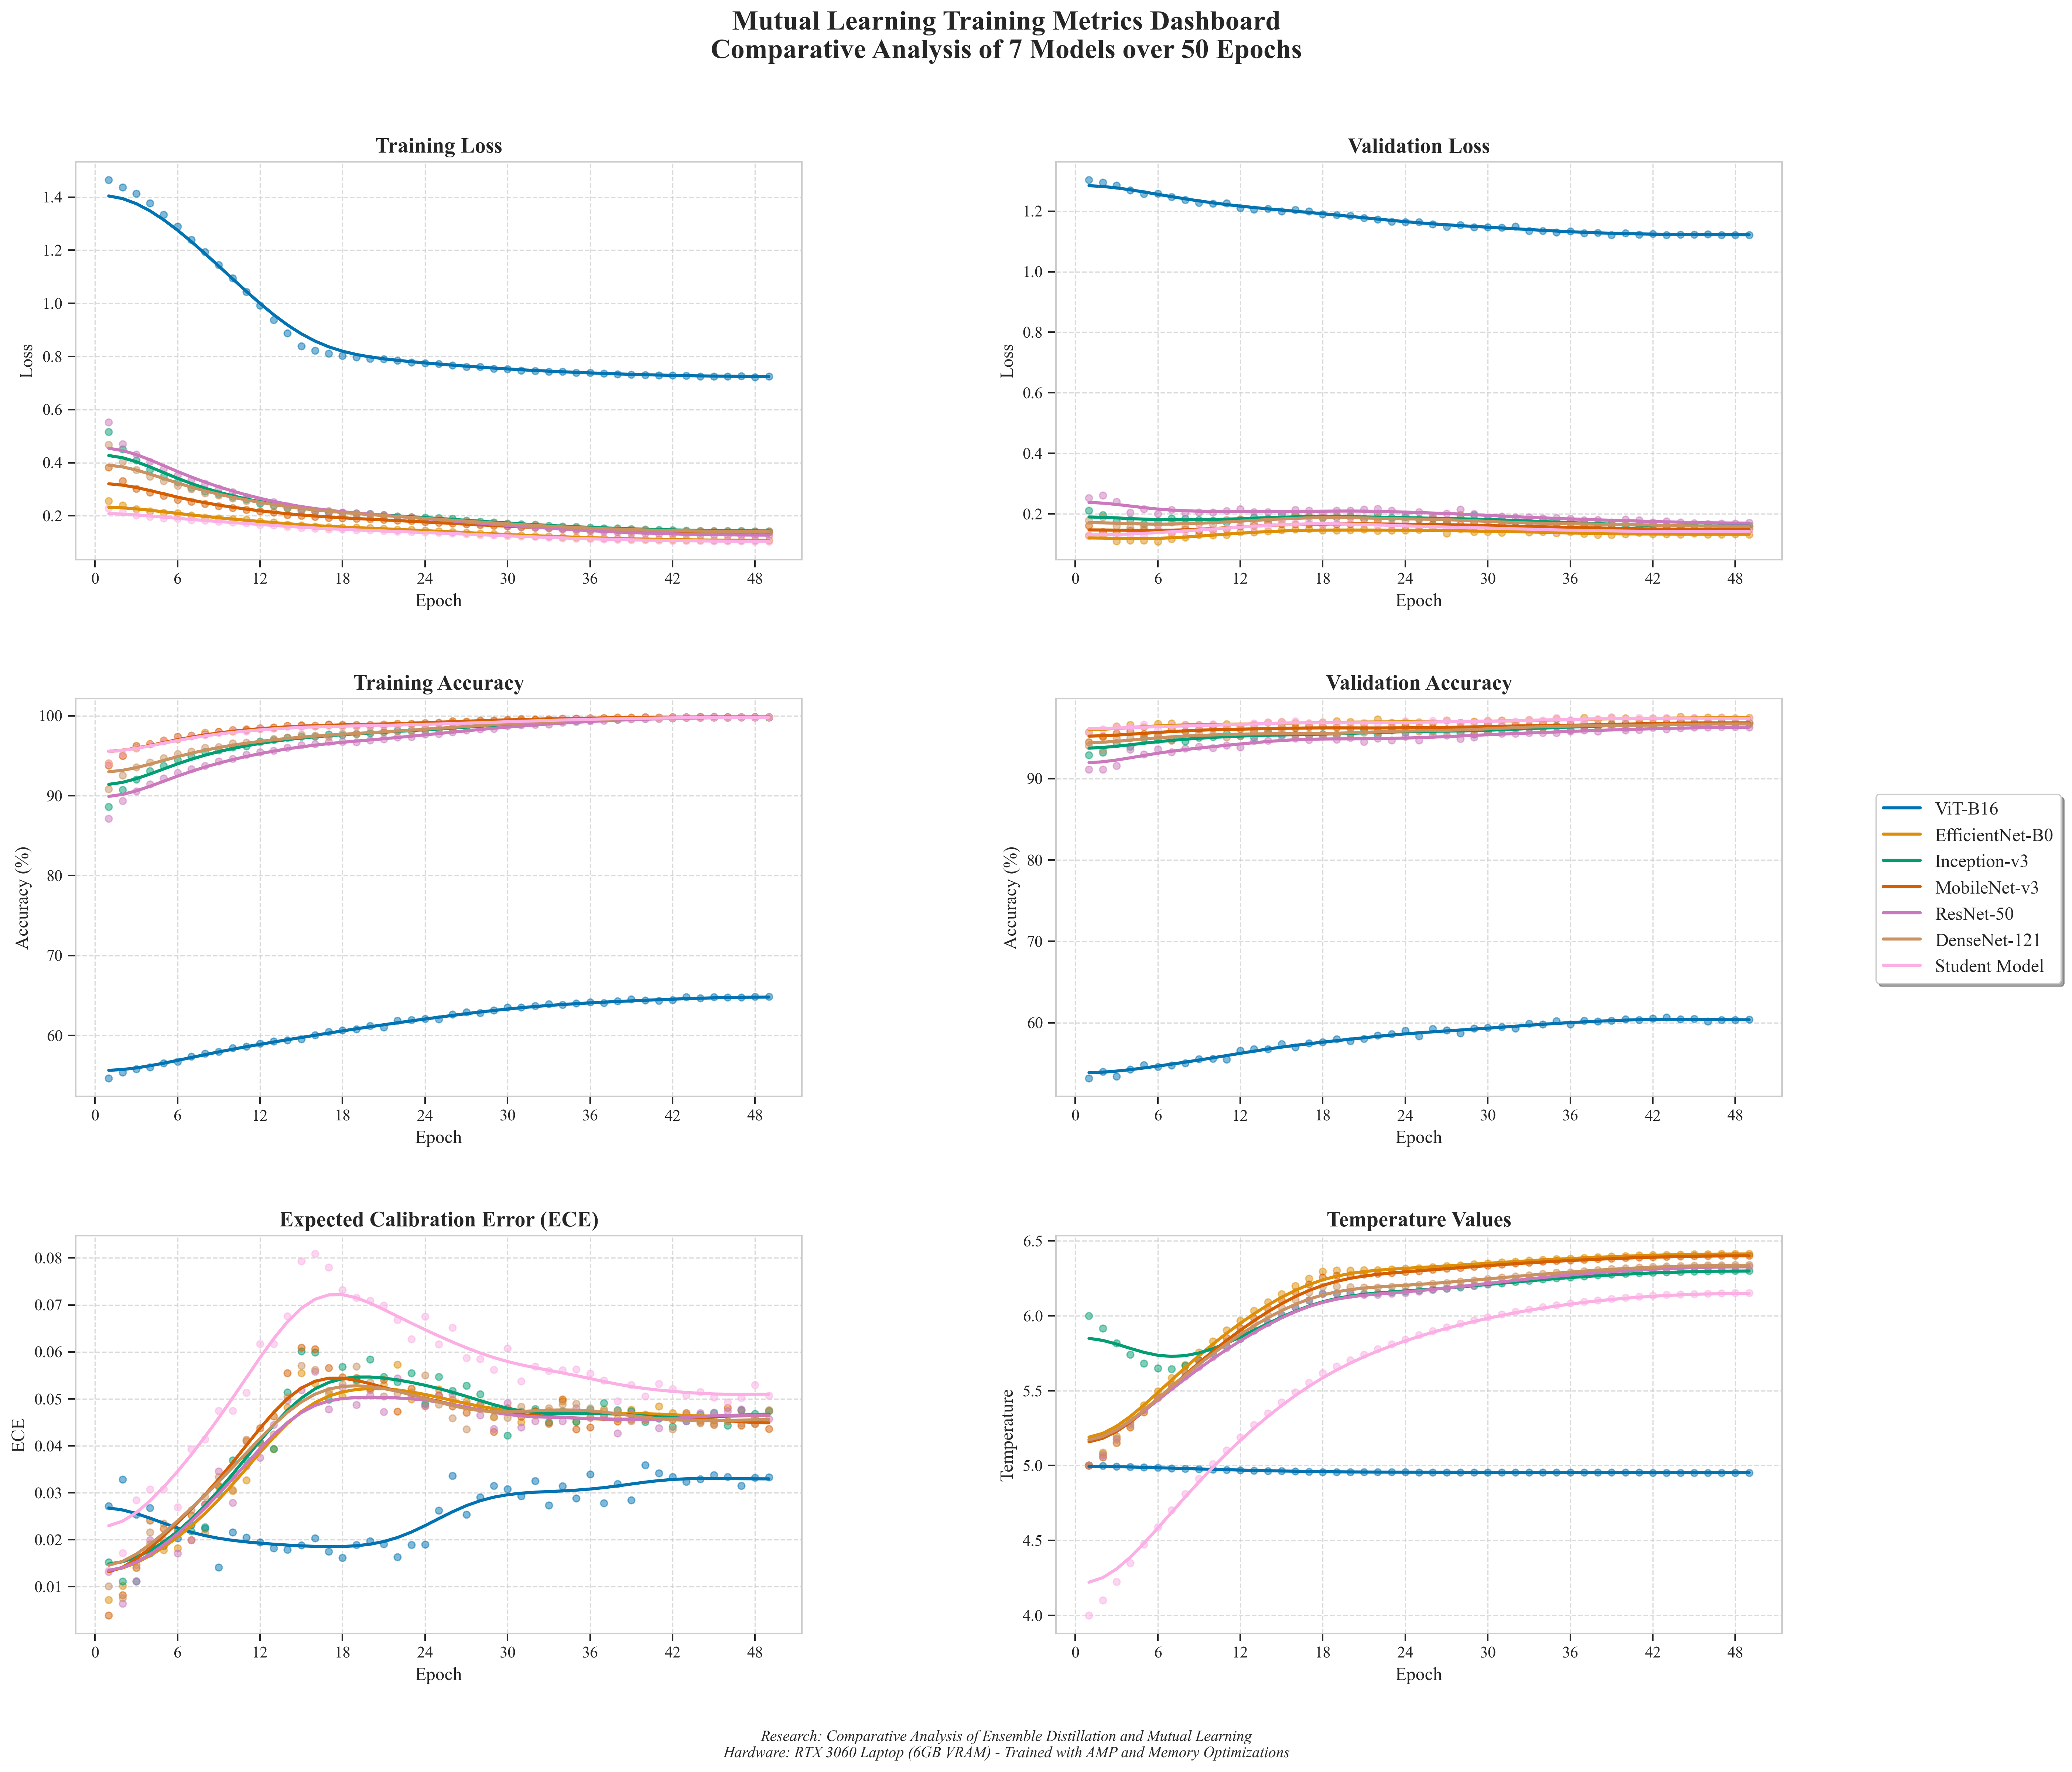

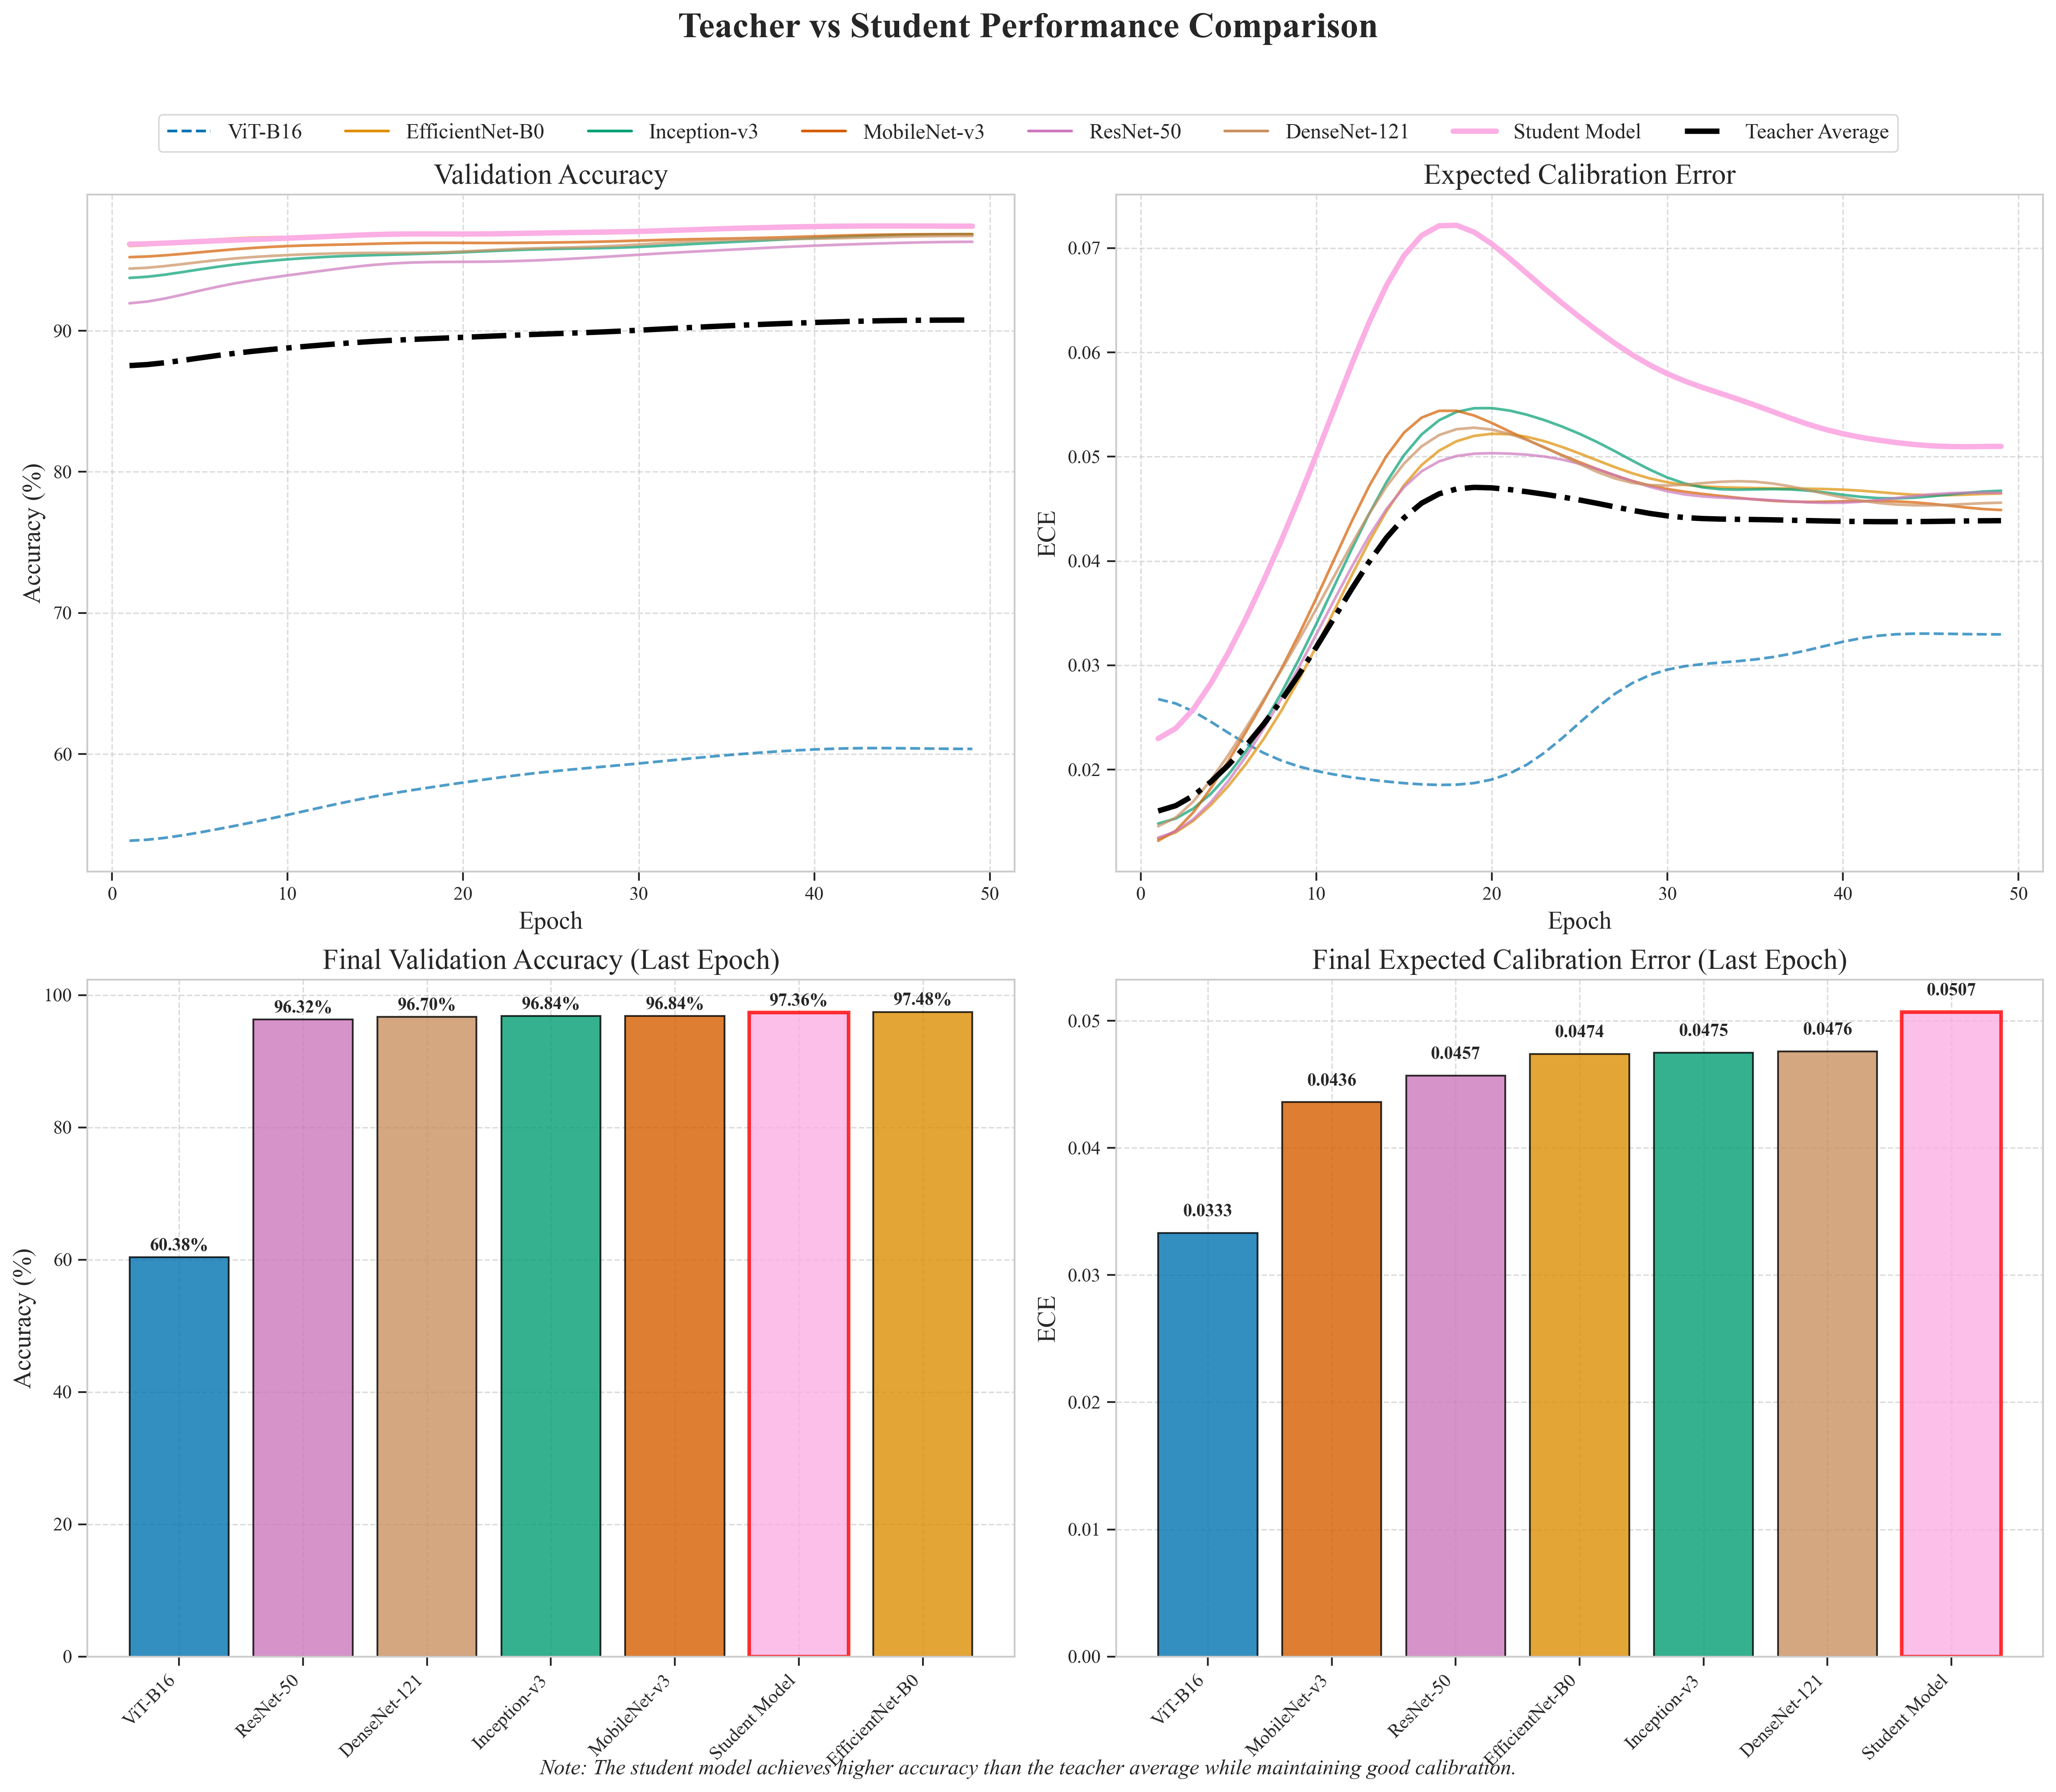

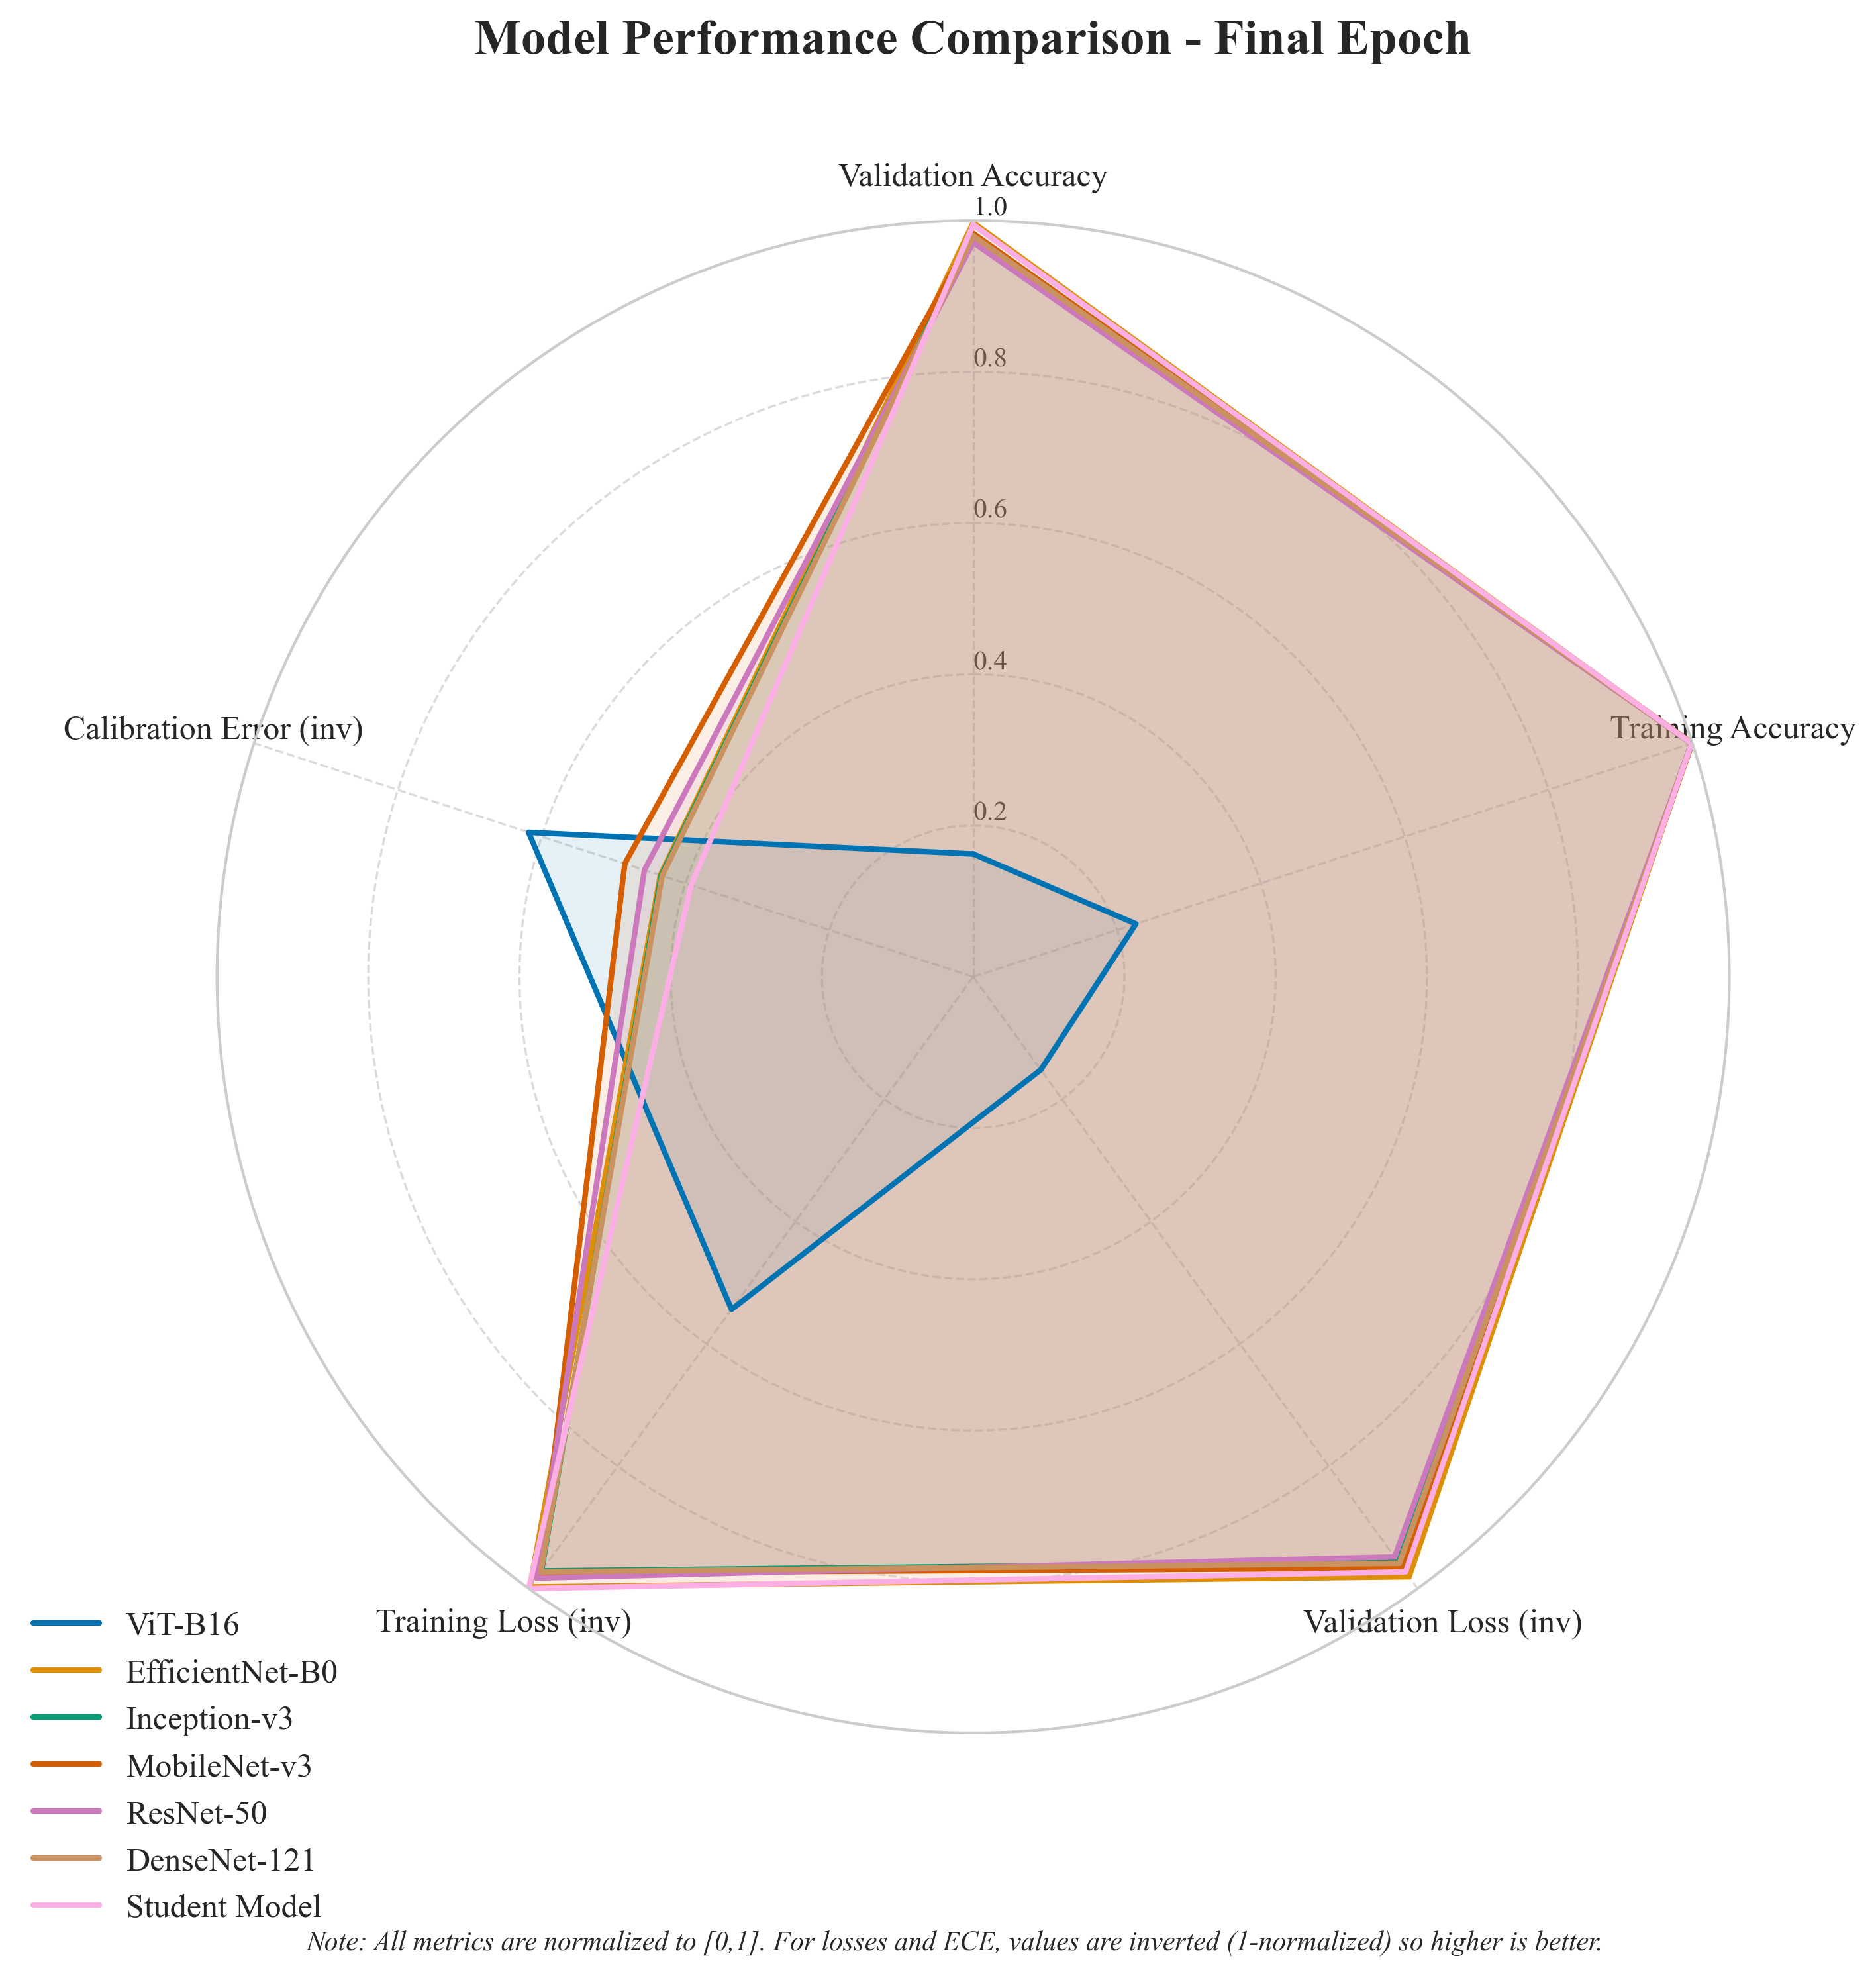

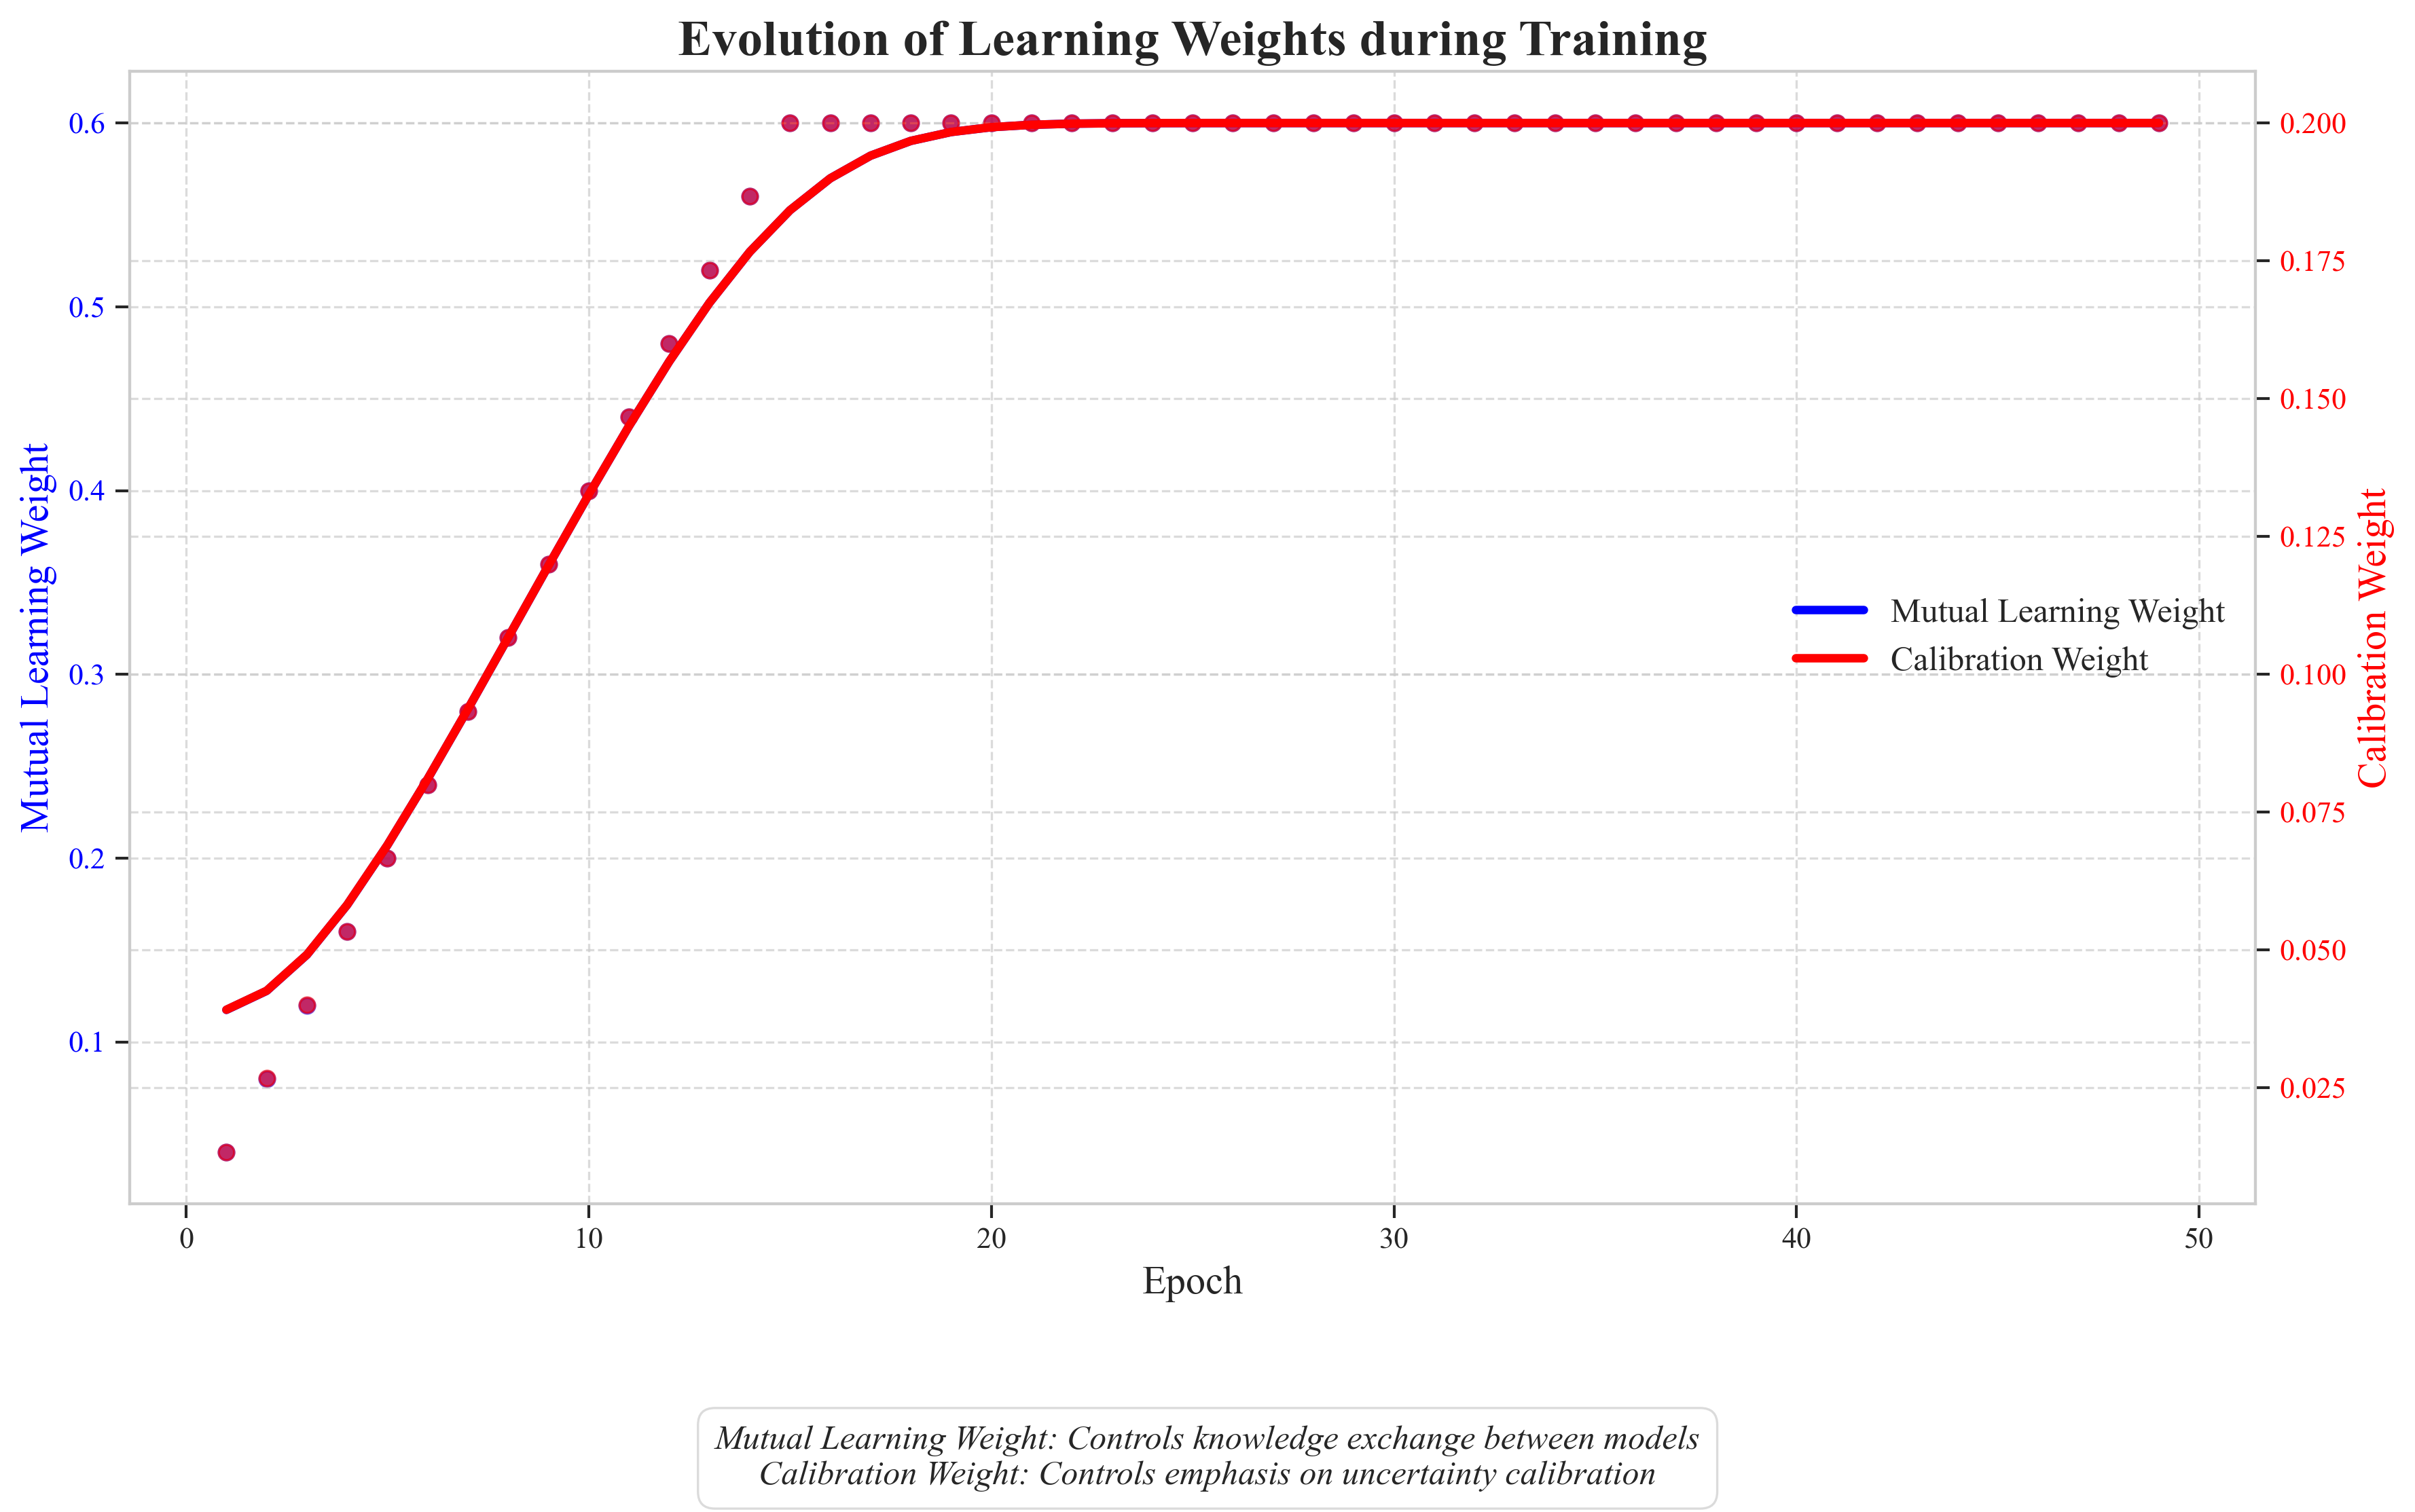

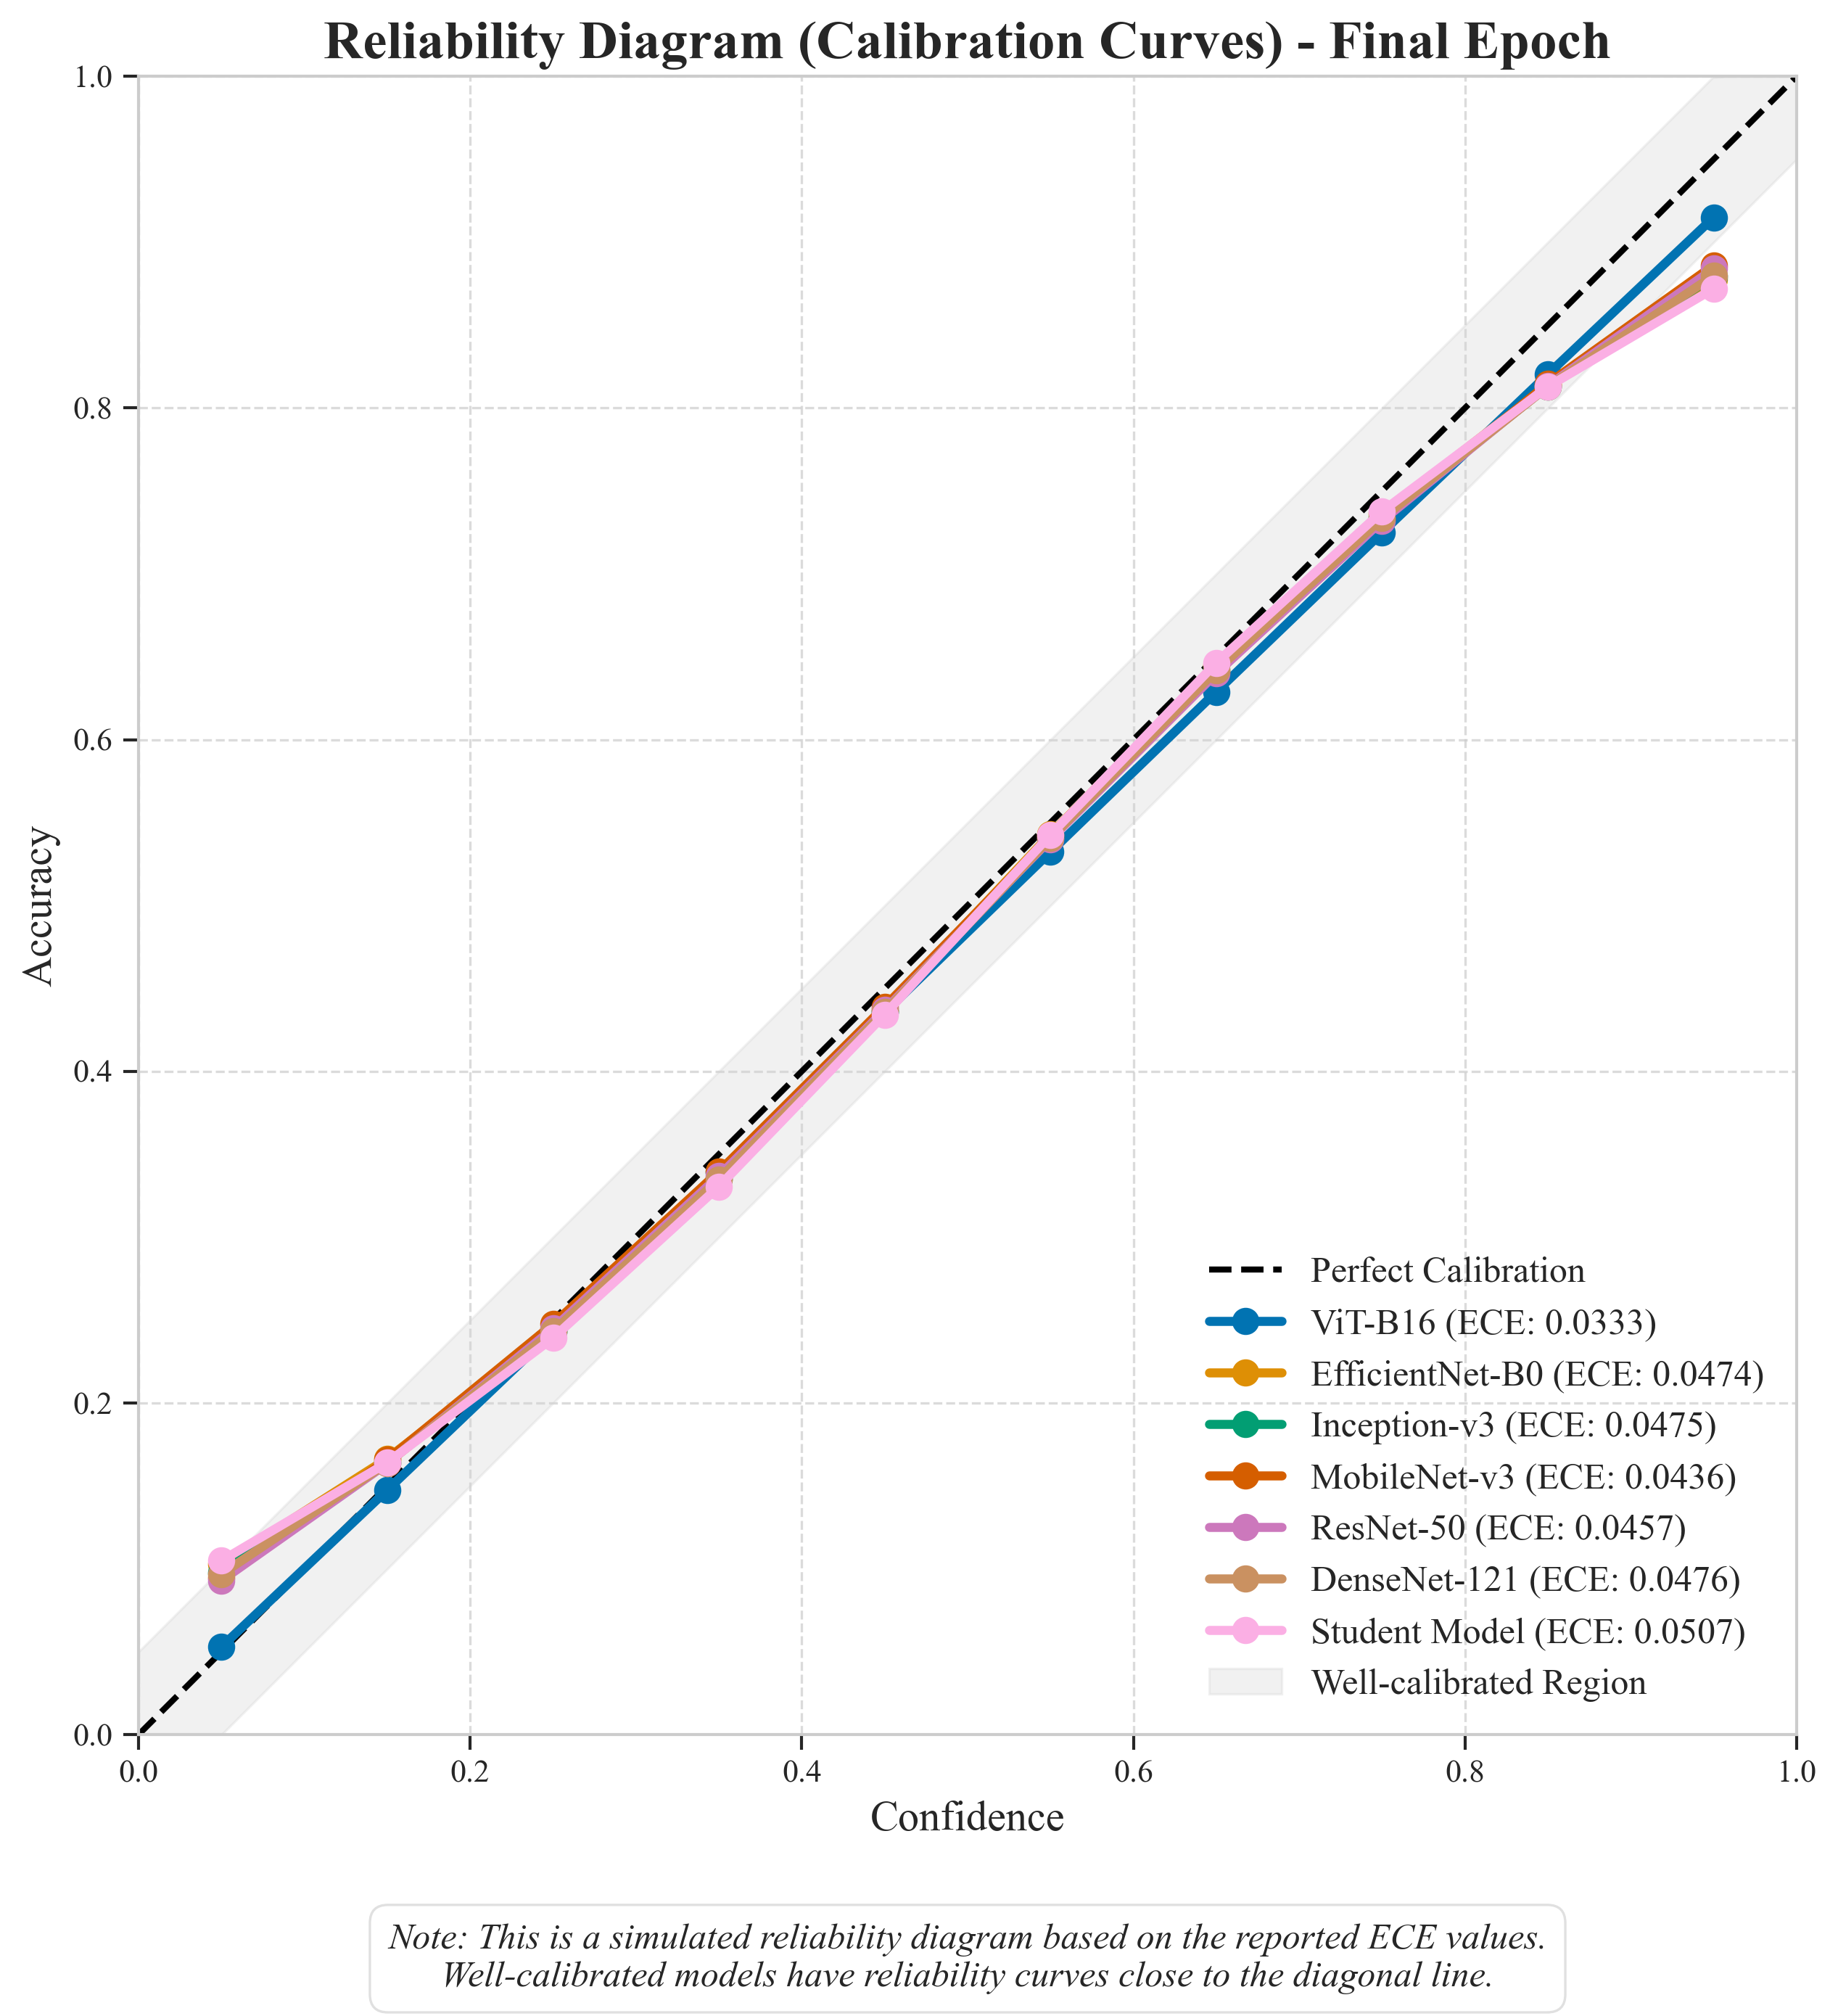

In [2]:
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
import matplotlib as mpl
from scipy.interpolate import make_interp_spline, BSpline
from scipy.ndimage import gaussian_filter1d
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from sklearn.calibration import calibration_curve
import matplotlib.colors as mcolors

# Set style for professional IEEE-compatible plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("paper", font_scale=1.2)
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Times New Roman', 'DejaVu Serif', 'serif']
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['axes.linewidth'] = 1.0
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.alpha'] = 0.7
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['axes.titlesize'] = 14
mpl.rcParams['axes.labelsize'] = 12

# Define paths
BASE_PATH = Path(r"C:\Users\Gading\Downloads\Research")
LOG_PATH = BASE_PATH / "Results" / "MutualLearning" / "logs" / "error.log"
PLOT_PATH = BASE_PATH / "Results" / "MutualLearning" / "plots"
PLOT_PATH.mkdir(exist_ok=True)

# Define models and metrics
MODELS = ['vit', 'efficientnet', 'inception', 'mobilenet', 'resnet', 'densenet', 'student']
TEACHER_MODELS = ['vit', 'efficientnet', 'inception', 'mobilenet', 'resnet', 'densenet']
METRICS = ['Train Loss', 'Train Acc', 'Val Loss', 'Val Acc', 'ECE', 'Temperature']

# Define color palette - colorblind-friendly palette
COLORS = sns.color_palette("colorblind", n_colors=7)
MODEL_COLORS = {model: color for model, color in zip(MODELS, COLORS)}

# Add model display names for better labeling
MODEL_DISPLAY_NAMES = {
    'vit': 'ViT-B16', 
    'efficientnet': 'EfficientNet-B0', 
    'inception': 'Inception-v3',
    'mobilenet': 'MobileNet-v3', 
    'resnet': 'ResNet-50', 
    'densenet': 'DenseNet-121', 
    'student': 'Student Model'
}

def extract_metrics_from_log(log_file):
    """Extract training metrics from the log file"""
    with open(log_file, 'r') as f:
        log_content = f.read()
    
    # Initialize data structure
    data = {
        'epoch': [],
        'model': [],
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'ece': [],
        'temperature': []
    }
    
    # Also extract mutual learning and calibration weights
    weights_data = {
        'epoch': [],
        'mutual_weight': [],
        'calibration_weight': []
    }
    
    # Extract epoch data
    pattern_epoch = re.compile(r"Mutual learning epoch (\d+) completed")
    epochs = pattern_epoch.findall(log_content)
    
    # Extract model metrics for each epoch
    for epoch in range(1, len(epochs) + 1):
        # Find the section for this epoch
        epoch_pattern = f"Mutual learning epoch {epoch} completed"
        start_idx = log_content.find(epoch_pattern)
        if start_idx == -1:
            continue
        
        # Find the previous section to get the start of this epoch's data
        prev_section = f"Mutual Learning Epoch {epoch}/50"
        prev_idx = log_content.rfind(prev_section, 0, start_idx)
        if prev_idx == -1:
            continue
        
        # Extract weights data
        weights_pattern = r"Mutual weight: (\d+\.\d+), Calibration weight: (\d+\.\d+)"
        weights_match = re.search(weights_pattern, log_content[prev_idx:start_idx])
        if weights_match:
            mutual_weight = float(weights_match.group(1))
            calibration_weight = float(weights_match.group(2))
            weights_data['epoch'].append(epoch)
            weights_data['mutual_weight'].append(mutual_weight)
            weights_data['calibration_weight'].append(calibration_weight)
        
        # Extract temperature values
        temp_pattern = re.compile(r"Current temperatures: (\{.*?\})", re.DOTALL)
        temp_match = temp_pattern.search(log_content[prev_idx:start_idx])
        temperatures = {}
        if temp_match:
            temp_str = temp_match.group(1)
            # Parse the temperature dictionary string
            for model in MODELS:
                # Fix: Use raw string for regex pattern
                model_temp_pattern = r"'" + model + r"': (\d+\.\d+)"
                model_temp_match = re.search(model_temp_pattern, temp_str)
                if model_temp_match:
                    temperatures[model] = float(model_temp_match.group(1))
        
        # Extract model metrics
        for model in MODELS:
            # Fix: Use raw string for regex pattern
            metrics_pattern = r"" + re.escape(model) + r": Train Loss=(\d+\.\d+), Train Acc=(\d+\.\d+)%, Val Loss=(\d+\.\d+), Val Acc=(\d+\.\d+)%, ECE=(\d+\.\d+)"
            metrics_match = re.search(metrics_pattern, log_content[prev_idx:start_idx])
            
            if metrics_match:
                train_loss = float(metrics_match.group(1))
                train_acc = float(metrics_match.group(2))
                val_loss = float(metrics_match.group(3))
                val_acc = float(metrics_match.group(4))
                ece = float(metrics_match.group(5))
                
                data['epoch'].append(epoch)
                data['model'].append(model)
                data['train_loss'].append(train_loss)
                data['train_acc'].append(train_acc)
                data['val_loss'].append(val_loss)
                data['val_acc'].append(val_acc)
                data['ece'].append(ece)
                data['temperature'].append(temperatures.get(model, None))
    
    # Convert to DataFrames
    metrics_df = pd.DataFrame(data)
    weights_df = pd.DataFrame(weights_data)
    
    return metrics_df, weights_df

def smooth_curve(x, y, smoothing_factor=3):
    """Apply smoothing to a curve for more professional appearance"""
    if len(x) <= 3:  # Not enough points to smooth effectively
        return x, y
        
    # Ensure enough data points for smoothing
    if len(x) > smoothing_factor:
        # Apply Gaussian smoothing for a more natural appearance
        y_smooth = gaussian_filter1d(y, sigma=smoothing_factor)
    else:
        y_smooth = y
    
    return x, y_smooth

def create_metrics_dashboard(metrics_df, weights_df, save_path):
    """Create a comprehensive dashboard with all training metrics (with smoothed curves)"""
    # Set figure size
    fig = plt.figure(figsize=(20, 16), dpi=300)
    
    # Create grid for subplots with more control over spacing
    gs = gridspec.GridSpec(3, 2, figure=fig, hspace=0.35, wspace=0.35)
    
    # 1. Training Loss Plot
    ax1 = fig.add_subplot(gs[0, 0])
    for model in MODELS:
        model_data = metrics_df[metrics_df['model'] == model]
        x = model_data['epoch'].values
        y = model_data['train_loss'].values
        x_smooth, y_smooth = smooth_curve(x, y)
        ax1.plot(x_smooth, y_smooth, label=MODEL_DISPLAY_NAMES[model], color=MODEL_COLORS[model], linewidth=2)
        ax1.scatter(x, y, s=20, color=MODEL_COLORS[model], alpha=0.5)
    
    ax1.set_title('Training Loss', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # 2. Validation Loss Plot
    ax2 = fig.add_subplot(gs[0, 1])
    for model in MODELS:
        model_data = metrics_df[metrics_df['model'] == model]
        x = model_data['epoch'].values
        y = model_data['val_loss'].values
        x_smooth, y_smooth = smooth_curve(x, y)
        ax2.plot(x_smooth, y_smooth, label=MODEL_DISPLAY_NAMES[model], color=MODEL_COLORS[model], linewidth=2)
        ax2.scatter(x, y, s=20, color=MODEL_COLORS[model], alpha=0.5)
    
    ax2.set_title('Validation Loss', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.grid(True, linestyle='--', alpha=0.7)
    
    # 3. Training Accuracy Plot
    ax3 = fig.add_subplot(gs[1, 0])
    for model in MODELS:
        model_data = metrics_df[metrics_df['model'] == model]
        x = model_data['epoch'].values
        y = model_data['train_acc'].values
        x_smooth, y_smooth = smooth_curve(x, y)
        ax3.plot(x_smooth, y_smooth, label=MODEL_DISPLAY_NAMES[model], color=MODEL_COLORS[model], linewidth=2)
        ax3.scatter(x, y, s=20, color=MODEL_COLORS[model], alpha=0.5)
    
    ax3.set_title('Training Accuracy', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Epoch', fontsize=12)
    ax3.set_ylabel('Accuracy (%)', fontsize=12)
    ax3.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax3.grid(True, linestyle='--', alpha=0.7)
    
    # 4. Validation Accuracy Plot
    ax4 = fig.add_subplot(gs[1, 1])
    for model in MODELS:
        model_data = metrics_df[metrics_df['model'] == model]
        x = model_data['epoch'].values
        y = model_data['val_acc'].values
        x_smooth, y_smooth = smooth_curve(x, y)
        ax4.plot(x_smooth, y_smooth, label=MODEL_DISPLAY_NAMES[model], color=MODEL_COLORS[model], linewidth=2)
        ax4.scatter(x, y, s=20, color=MODEL_COLORS[model], alpha=0.5)
    
    ax4.set_title('Validation Accuracy', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Epoch', fontsize=12)
    ax4.set_ylabel('Accuracy (%)', fontsize=12)
    ax4.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax4.grid(True, linestyle='--', alpha=0.7)
    
    # 5. ECE Plot
    ax5 = fig.add_subplot(gs[2, 0])
    for model in MODELS:
        model_data = metrics_df[metrics_df['model'] == model]
        x = model_data['epoch'].values
        y = model_data['ece'].values
        x_smooth, y_smooth = smooth_curve(x, y)
        ax5.plot(x_smooth, y_smooth, label=MODEL_DISPLAY_NAMES[model], color=MODEL_COLORS[model], linewidth=2)
        ax5.scatter(x, y, s=20, color=MODEL_COLORS[model], alpha=0.5)
    
    ax5.set_title('Expected Calibration Error (ECE)', fontsize=14, fontweight='bold')
    ax5.set_xlabel('Epoch', fontsize=12)
    ax5.set_ylabel('ECE', fontsize=12)
    ax5.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax5.grid(True, linestyle='--', alpha=0.7)
    
    # 6. Temperature Plot
    ax6 = fig.add_subplot(gs[2, 1])
    for model in MODELS:
        model_data = metrics_df[metrics_df['model'] == model]
        x = model_data['epoch'].values
        y = model_data['temperature'].values
        x_smooth, y_smooth = smooth_curve(x, y)
        ax6.plot(x_smooth, y_smooth, label=MODEL_DISPLAY_NAMES[model], color=MODEL_COLORS[model], linewidth=2)
        ax6.scatter(x, y, s=20, color=MODEL_COLORS[model], alpha=0.5)
    
    ax6.set_title('Temperature Values', fontsize=14, fontweight='bold')
    ax6.set_xlabel('Epoch', fontsize=12)
    ax6.set_ylabel('Temperature', fontsize=12)
    ax6.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax6.grid(True, linestyle='--', alpha=0.7)
    
    # Create a single legend for the entire figure - MODIFIED PLACEMENT
    handles, labels = ax1.get_legend_handles_labels()
    
    # Move legend to right side of the figure instead of overlapping with title
    legend = fig.legend(
        handles, labels, 
        loc='center right', 
        bbox_to_anchor=(0.98, 0.5),
        frameon=True,
        fontsize=12, 
        fancybox=True, 
        shadow=True,
        ncol=1  # Stack models vertically for better readability
    )
    
    # Add overall title with more space
    fig.suptitle(
        'Mutual Learning Training Metrics Dashboard\nComparative Analysis of 7 Models over 50 Epochs', 
        fontsize=18, fontweight='bold', y=0.995
    )
    
    # Add footer with additional information
    fig.text(
        0.5, 0.01, 
        "Research: Comparative Analysis of Ensemble Distillation and Mutual Learning\n"
        "Hardware: RTX 3060 Laptop (6GB VRAM) - Trained with AMP and Memory Optimizations",
        ha='center', fontsize=10, fontstyle='italic'
    )
    
    # Adjust layout to make room for the legend on the right side
    plt.subplots_adjust(top=0.91, bottom=0.08, left=0.08, right=0.85)
    
    # Save the figure
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    print(f"Metrics dashboard saved to {save_path}")

def create_teacher_vs_student_comparison(metrics_df, save_path):
    """Create a plot comparing teacher models with the student model"""
    # Filter data for the final epoch to get final performance
    max_epoch = metrics_df['epoch'].max()
    final_metrics = metrics_df[metrics_df['epoch'] == max_epoch]
    
    # Create figure with 4 subplots (2x2)
    fig, axes = plt.subplots(2, 2, figsize=(16, 14), dpi=300)
    fig.suptitle("Teacher vs Student Performance Comparison", fontsize=20, fontweight='bold', y=0.98)
    
    # Get data for student and calculate teacher average
    student_data = metrics_df[metrics_df['model'] == 'student']
    
    # 1. Validation Accuracy Plot (Top Left)
    ax = axes[0, 0]
    for model in TEACHER_MODELS:
        model_data = metrics_df[metrics_df['model'] == model]
        x = model_data['epoch'].values
        y = model_data['val_acc'].values
        x_smooth, y_smooth = smooth_curve(x, y)
        if model == 'vit':  # Make ViT dashed as it's the outlier
            ax.plot(x_smooth, y_smooth, linestyle='--', label=MODEL_DISPLAY_NAMES[model], color=MODEL_COLORS[model], linewidth=1.5, alpha=0.7)
        else:
            ax.plot(x_smooth, y_smooth, linestyle='-', label=MODEL_DISPLAY_NAMES[model], color=MODEL_COLORS[model], linewidth=1.5, alpha=0.7)
    
    # Highlight student model with thicker line
    student_x = student_data['epoch'].values
    student_y = student_data['val_acc'].values
    student_x_smooth, student_y_smooth = smooth_curve(student_x, student_y)
    ax.plot(student_x_smooth, student_y_smooth, label=MODEL_DISPLAY_NAMES['student'], color=MODEL_COLORS['student'], linewidth=3)
    
    # Calculate average of all teachers
    teacher_avg = metrics_df[metrics_df['model'].isin(TEACHER_MODELS)].groupby('epoch')['val_acc'].mean().reset_index()
    teacher_x = teacher_avg['epoch'].values
    teacher_y = teacher_avg['val_acc'].values
    teacher_x_smooth, teacher_y_smooth = smooth_curve(teacher_x, teacher_y)
    ax.plot(teacher_x_smooth, teacher_y_smooth, label='Teacher Average', color='black', linestyle='-.', linewidth=3)
    
    ax.set_title('Validation Accuracy', fontsize=16)
    ax.set_xlabel('Epoch', fontsize=14)
    ax.set_ylabel('Accuracy (%)', fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # 2. ECE Plot (Top Right)
    ax = axes[0, 1]
    for model in TEACHER_MODELS:
        model_data = metrics_df[metrics_df['model'] == model]
        x = model_data['epoch'].values
        y = model_data['ece'].values
        x_smooth, y_smooth = smooth_curve(x, y)
        if model == 'vit':
            ax.plot(x_smooth, y_smooth, linestyle='--', label=MODEL_DISPLAY_NAMES[model], color=MODEL_COLORS[model], linewidth=1.5, alpha=0.7)
        else:
            ax.plot(x_smooth, y_smooth, linestyle='-', label=MODEL_DISPLAY_NAMES[model], color=MODEL_COLORS[model], linewidth=1.5, alpha=0.7)
    
    # Highlight student model
    student_x = student_data['epoch'].values
    student_y = student_data['ece'].values
    student_x_smooth, student_y_smooth = smooth_curve(student_x, student_y)
    ax.plot(student_x_smooth, student_y_smooth, label=MODEL_DISPLAY_NAMES['student'], color=MODEL_COLORS['student'], linewidth=3)
    
    # Calculate average of all teachers
    teacher_avg = metrics_df[metrics_df['model'].isin(TEACHER_MODELS)].groupby('epoch')['ece'].mean().reset_index()
    teacher_x = teacher_avg['epoch'].values
    teacher_y = teacher_avg['ece'].values
    teacher_x_smooth, teacher_y_smooth = smooth_curve(teacher_x, teacher_y)
    ax.plot(teacher_x_smooth, teacher_y_smooth, label='Teacher Average', color='black', linestyle='-.', linewidth=3)
    
    ax.set_title('Expected Calibration Error', fontsize=16)
    ax.set_xlabel('Epoch', fontsize=14)
    ax.set_ylabel('ECE', fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # 3. Bar chart of final validation accuracy (Bottom Left)
    ax = axes[1, 0]
    
    # Sort by accuracy
    final_metrics_sorted = final_metrics.sort_values('val_acc')
    
    # Prepare data for bar chart
    models = [MODEL_DISPLAY_NAMES[m] for m in final_metrics_sorted['model']]
    accuracies = final_metrics_sorted['val_acc']
    colors = [MODEL_COLORS[m] for m in final_metrics_sorted['model']]
    
    # Create a gradient to highlight the student
    student_highlight = ['#f0f0f0' if m != 'student' else '#ffeeaa' for m in final_metrics_sorted['model']]
    
    # Create bar chart
    bars = ax.bar(models, accuracies, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.2f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Highlight the student model with a different edge color
    for i, m in enumerate(final_metrics_sorted['model']):
        if m == 'student':
            bars[i].set_edgecolor('red')
            bars[i].set_linewidth(2)
    
    ax.set_title('Final Validation Accuracy (Last Epoch)', fontsize=16)
    ax.set_ylabel('Accuracy (%)', fontsize=14)
    ax.set_xticklabels(models, rotation=45, ha='right')
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # 4. Bar chart of final ECE (Bottom Right)
    ax = axes[1, 1]
    
    # Sort by ECE (lower is better)
    final_metrics_sorted = final_metrics.sort_values('ece')
    
    # Prepare data for bar chart
    models = [MODEL_DISPLAY_NAMES[m] for m in final_metrics_sorted['model']]
    ece_values = final_metrics_sorted['ece']
    colors = [MODEL_COLORS[m] for m in final_metrics_sorted['model']]
    
    # Create bar chart
    bars = ax.bar(models, ece_values, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                f'{height:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Highlight the student model with a different edge color
    for i, m in enumerate(final_metrics_sorted['model']):
        if m == 'student':
            bars[i].set_edgecolor('red')
            bars[i].set_linewidth(2)
    
    ax.set_title('Final Expected Calibration Error (Last Epoch)', fontsize=16)
    ax.set_ylabel('ECE', fontsize=14)
    ax.set_xticklabels(models, rotation=45, ha='right')
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # Add a single legend for the line plots
    custom_lines = []
    custom_labels = []
    
    # Add teacher models
    for model in TEACHER_MODELS:
        custom_lines.append(Line2D([0], [0], color=MODEL_COLORS[model], 
                           linewidth=1.5, linestyle='-' if model != 'vit' else '--'))
        custom_labels.append(MODEL_DISPLAY_NAMES[model])
    
    # Add student and average
    custom_lines.append(Line2D([0], [0], color=MODEL_COLORS['student'], linewidth=3))
    custom_labels.append(MODEL_DISPLAY_NAMES['student'])
    
    custom_lines.append(Line2D([0], [0], color='black', linestyle='-.', linewidth=3))
    custom_labels.append('Teacher Average')
    
    fig.legend(custom_lines, custom_labels, loc='upper center', 
               bbox_to_anchor=(0.5, 0.93), ncol=8, frameon=True, fontsize=12)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)  # Make room for the legend and title
    
    # Add annotation about the experiment
    plt.figtext(0.5, 0.01, 
              "Note: The student model achieves higher accuracy than the teacher average while maintaining good calibration.",
              ha='center', fontsize=12, fontstyle='italic')
    
    # Save the figure
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    print(f"Teacher vs Student comparison saved to {save_path}")

def create_final_performance_radar(metrics_df, save_path):
    """Create a radar chart showing final model performance across multiple metrics"""
    # Get data for the last epoch
    max_epoch = metrics_df['epoch'].max()
    final_metrics = metrics_df[metrics_df['epoch'] == max_epoch]
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 10), dpi=300, subplot_kw=dict(polar=True))
    
    # Metrics to include in the radar chart
    radar_metrics = ['val_acc', 'train_acc', '1-val_loss', '1-train_loss', '1-ece']
    
    # Number of metrics
    N = len(radar_metrics)
    
    # Normalize all metrics to [0, 1]
    normalized_df = pd.DataFrame()
    for metric in radar_metrics:
        if metric.startswith('1-'):
            # For loss and ECE, lower is better, so we do 1-normalized value
            base_metric = metric[2:]  # Remove the '1-' prefix
            min_val = metrics_df[base_metric].min()
            max_val = metrics_df[base_metric].max()
            range_val = max_val - min_val
            if range_val == 0:
                normalized_df[metric] = 1  # Avoid division by zero
            else:
                normalized_df[metric] = 1 - ((final_metrics[base_metric] - min_val) / range_val)
        else:
            min_val = metrics_df[metric].min()
            max_val = metrics_df[metric].max()
            range_val = max_val - min_val
            if range_val == 0:
                normalized_df[metric] = 1  # Avoid division by zero
            else:
                normalized_df[metric] = (final_metrics[metric] - min_val) / range_val
    
    normalized_df['model'] = final_metrics['model'].values
    
    # Angles for each metric (in radians)
    angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
    
    # Close the plot (connect back to the first point)
    angles.append(angles[0])
    
    # Set up the radar chart
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_rlabel_position(0)
    
    # Add metric labels
    plt.xticks(angles[:-1], [
        'Validation Accuracy',
        'Training Accuracy',
        'Validation Loss (inv)',
        'Training Loss (inv)',
        'Calibration Error (inv)'
    ], fontsize=12)
    
    # Set y-ticks
    plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=10)
    plt.ylim(0, 1)
    
    # Plot each model
    for model in MODELS:
        model_data = normalized_df[normalized_df['model'] == model]
        if len(model_data) == 0:
            continue
            
        values = []
        for metric in radar_metrics:
            values.append(model_data[metric].values[0])
        
        # Close the polygon
        values.append(values[0])
        
        # Plot the model
        ax.plot(angles, values, linewidth=2, label=MODEL_DISPLAY_NAMES[model], color=MODEL_COLORS[model])
        ax.fill(angles, values, alpha=0.1, color=MODEL_COLORS[model])
    
    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1), fontsize=12)
    
    # Add title
    plt.title('Model Performance Comparison - Final Epoch', size=18, y=1.1, fontweight='bold')
    
    # Add annotation explaining the metrics
    plt.figtext(0.5, 0.01, 
              "Note: All metrics are normalized to [0,1]. For losses and ECE, values are inverted (1-normalized) so higher is better.",
              ha='center', fontsize=10, fontstyle='italic')
    
    # Save the figure
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    print(f"Final performance radar chart saved to {save_path}")

def create_weights_evolution_plot(weights_df, save_path):
    """Create a plot showing the evolution of mutual and calibration weights"""
    fig, ax1 = plt.subplots(figsize=(12, 8), dpi=300)
    
    # Plot mutual weight
    x = weights_df['epoch'].values
    y1 = weights_df['mutual_weight'].values
    x_smooth, y1_smooth = smooth_curve(x, y1)
    ln1 = ax1.plot(x_smooth, y1_smooth, 'b-', linewidth=3, label='Mutual Learning Weight')
    ax1.scatter(x, y1, color='blue', s=30, alpha=0.6)
    ax1.set_xlabel('Epoch', fontsize=14)
    ax1.set_ylabel('Mutual Learning Weight', color='blue', fontsize=14)
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # Create second y-axis for calibration weight
    ax2 = ax1.twinx()
    y2 = weights_df['calibration_weight'].values
    x_smooth, y2_smooth = smooth_curve(x, y2)
    ln2 = ax2.plot(x_smooth, y2_smooth, 'r-', linewidth=3, label='Calibration Weight')
    ax2.scatter(x, y2, color='red', s=30, alpha=0.6)
    ax2.set_ylabel('Calibration Weight', color='red', fontsize=14)
    ax2.tick_params(axis='y', labelcolor='red')
    
    # Add title
    plt.title('Evolution of Learning Weights during Training', fontsize=18, fontweight='bold')
    
    # Add legend
    lns = ln1 + ln2
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc='center right', fontsize=12)
    
    # Adjust layout to create space for explanatory text
    plt.tight_layout(rect=[0, 0.12, 1, 0.95])
    
    # Add annotations explaining the weights with a nice background box
    fig.text(0.5, 0.03,
             "Mutual Learning Weight: Controls knowledge exchange between models\n"
             "Calibration Weight: Controls emphasis on uncertainty calibration",
             ha='center', fontsize=12, fontstyle='italic',
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='lightgray', 
                      boxstyle='round,pad=0.5'))
    
    # Save the figure
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    print(f"Weight evolution plot saved to {save_path}")

def create_simulated_reliability_diagram(metrics_df, save_path):
    """Create a simulated reliability diagram for calibration visualization"""
    # We don't have actual confidence and accuracy distributions, so we'll simulate them
    # based on the ECE values from the last epoch
    
    max_epoch = metrics_df['epoch'].max()
    final_metrics = metrics_df[metrics_df['epoch'] == max_epoch]
    
    # Create figure with increased bottom margin for explanatory note
    fig, ax = plt.subplots(figsize=(14, 10), dpi=300)
    
    # Perfect calibration line
    perfect_calibration = np.linspace(0, 1, 100)
    ax.plot(perfect_calibration, perfect_calibration, 'k--', label='Perfect Calibration', linewidth=2)
    
    # Generate simulated reliability curves based on the ECE values
    bins = np.linspace(0, 1, 11)  # 10 confidence bins
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    # Plot a reliability curve for each model
    for _, row in final_metrics.iterrows():
        model = row['model']
        ece = row['ece']
        val_acc = row['val_acc'] / 100  # Convert to [0,1]
        
        # Generate a simulated reliability curve with the given ECE
        # For simplicity, we'll model the curve as a distortion from perfect calibration
        # where the amount of distortion is proportional to the ECE
        
        # Shape parameter - controls the shape of the calibration curve
        # Higher values make the curve more S-shaped
        shape_param = 3 * (1 + ece * 10)  
        
        # Generate a reliability curve that follows a sigmoid distortion pattern
        # This creates an S-shaped curve that deviates from perfect calibration
        # in a way that's proportional to the ECE value
        confidence = bin_centers
        reliability = 1 / (1 + np.exp(-shape_param * (confidence - 0.5))) * val_acc
        
        # Adjust the curve so it reflects the ECE
        # Calculate actual ECE of our simulated curve
        simulated_ece = np.mean(np.abs(confidence - reliability))
        
        # Scale to match the reported ECE
        scaling_factor = ece / simulated_ece if simulated_ece > 0 else 1
        reliability = (reliability - confidence) * scaling_factor * 0.5 + confidence
        
        # Plot the reliability diagram
        ax.plot(confidence, reliability, 'o-', label=f"{MODEL_DISPLAY_NAMES[model]} (ECE: {ece:.4f})",
                color=MODEL_COLORS[model], linewidth=3, markersize=8)
    
    # Add shaded area for well-calibrated region
    well_calibrated_threshold = 0.05  # 5% deviation
    x = np.linspace(0, 1, 100)
    upper_bound = np.minimum(x + well_calibrated_threshold, 1)
    lower_bound = np.maximum(x - well_calibrated_threshold, 0)
    ax.fill_between(x, lower_bound, upper_bound, color='lightgray', alpha=0.3, label='Well-calibrated Region')
    
    # Add labels and title
    ax.set_xlabel('Confidence', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_title('Reliability Diagram (Calibration Curves) - Final Epoch', fontsize=18, fontweight='bold')
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(fontsize=12, loc='lower right')
    
    # Add axis settings
    ax.set_aspect('equal')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    
    # Adjust layout with increased bottom margin
    plt.tight_layout(rect=[0, 0.08, 1, 0.95])
    
    # Add explanation text in the newly created space
    # Moved up from very bottom of figure to just below the plot
    fig.text(0.5, 0.03,
             "Note: This is a simulated reliability diagram based on the reported ECE values.\n"
             "Well-calibrated models have reliability curves close to the diagonal line.",
             ha='center', fontsize=12, fontstyle='italic', 
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='lightgray', boxstyle='round,pad=0.5'))
    
    # Save the figure
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    print(f"Reliability diagram saved to {save_path}")

def main():
    # Extract metrics and weights from log
    metrics_df, weights_df = extract_metrics_from_log(LOG_PATH)
    
    # Create and save the comprehensive dashboard with smooth curves
    dashboard_path = PLOT_PATH / "mutual_learning_metrics_dashboard_smooth.png"
    create_metrics_dashboard(metrics_df, weights_df, dashboard_path)
    
    # Create teacher vs student comparison
    teacher_student_path = PLOT_PATH / "teacher_vs_student_comparison.png"
    create_teacher_vs_student_comparison(metrics_df, teacher_student_path)
    
    # Create radar chart of final performance
    radar_path = PLOT_PATH / "final_performance_radar.png"
    create_final_performance_radar(metrics_df, radar_path)
    
    # Create weight evolution plot
    weights_path = PLOT_PATH / "weight_evolution.png"
    create_weights_evolution_plot(weights_df, weights_path)
    
    # Create simulated reliability diagram
    reliability_path = PLOT_PATH / "calibration_reliability_diagram.png"
    create_simulated_reliability_diagram(metrics_df, reliability_path)

if __name__ == "__main__":
    main()


In [4]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.amp import autocast
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score, precision_score, recall_score
from datetime import datetime
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import json
import logging
import gc

# Import specific model classes for proper model loading
from torchvision.models import (
    vit_b_16, 
    efficientnet_b0, 
    inception_v3, 
    mobilenet_v3_large, 
    resnet50, 
    densenet121
)

# Set the style for plots
plt.style.use('seaborn-v0_8-whitegrid')

# Set environment variables for better performance
os.environ['OMP_NUM_THREADS'] = '4'  # Optimize CPU threading
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:128'  # Limit memory fragmentation

# Setup logging
log_file = os.path.join(r"C:\Users\Gading\Downloads\Research\Results\MutualLearning\logs", "mutual_test.log")
os.makedirs(os.path.dirname(log_file), exist_ok=True)

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s [%(levelname)s] - %(message)s',
    handlers=[
        logging.FileHandler(log_file),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger()

####################################
# 1. Configuration Class
####################################
class MutualEvalConfig:
    def __init__(self):
        # Base paths
        self.base_path = r"C:\Users\Gading\Downloads\Research"
        
        # Dataset path
        self.dataset_path = os.path.join(self.base_path, "Dataset", "CIFAR-10")
        
        # Model paths - all trained models from mutual learning
        self.models_base_path = os.path.join(self.base_path, "Models", "MutualLearning", "exports")
        self.checkpoint_paths = {
            'student': os.path.join(self.models_base_path, "cal_aware_mutual_model.pth"),
            'vit': os.path.join(self.models_base_path, "mutual_vit_model.pth"),
            'efficientnet': os.path.join(self.models_base_path, "mutual_efficientnet_model.pth"),
            'inception': os.path.join(self.models_base_path, "mutual_inception_model.pth"),
            'mobilenet': os.path.join(self.models_base_path, "mutual_mobilenet_model.pth"),
            'resnet': os.path.join(self.models_base_path, "mutual_resnet_model.pth"),
            'densenet': os.path.join(self.models_base_path, "mutual_densenet_model.pth")
        }
        
        # Output directory for evaluation results
        self.output_dir = os.path.join(self.base_path, "Results", "MutualLearning", "evaluation")
        
        # Hardware settings - optimized for stability
        self.batch_size = 8  # Reduced for stability
        self.num_workers = 0  # Start with 0 workers to avoid hanging
        self.use_amp = True   # Use mixed precision for faster evaluation
        self.pin_memory = True
        
        # Model-specific input sizes
        self.model_input_sizes = {
            'vit': 224,
            'efficientnet': 224,
            'inception': 299,  # InceptionV3 requires 299x299 input
            'mobilenet': 224,
            'resnet': 224,
            'densenet': 224,
            'student': 224
        }
        
        # Evaluation options
        self.evaluate_all_models = True  # Set to False to only evaluate the student
        self.compare_models = True       # Compare models in the output
        
        # CIFAR-10 classes
        self.classes = ('airplane', 'automobile', 'bird', 'cat', 'deer',
                        'dog', 'frog', 'horse', 'ship', 'truck')
        
        # ImageNet normalization (used by pretrained models)
        self.mean = [0.485, 0.456, 0.406]
        self.std = [0.229, 0.224, 0.225]

    def get_input_size(self, model_name):
        """Get model-specific input size"""
        if model_name in self.model_input_sizes:
            return self.model_input_sizes[model_name]
        return 224  # Default size


####################################
# 2. Utilities
####################################
def setup_environment():
    """Setup environment and output directory"""
    # Create output directory
    config = MutualEvalConfig()
    os.makedirs(config.output_dir, exist_ok=True)
    
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    logger.info(f"Using device: {device}")
    
    # Show GPU info if available
    if device.type == 'cuda':
        logger.info(f"GPU: {torch.cuda.get_device_name(0)}")
        logger.info(f"Available memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    
    return config, device

def clear_gpu_cache():
    """Clear GPU cache to free up memory"""
    if torch.cuda.is_available():
        before_mem = torch.cuda.memory_allocated() / 1024**2
        torch.cuda.empty_cache()
        gc.collect()  # Explicit garbage collection
        after_mem = torch.cuda.memory_allocated() / 1024**2
        logger.info(f"GPU cache cleared: {before_mem:.2f}MB → {after_mem:.2f}MB (freed {before_mem-after_mem:.2f}MB)")


####################################
# 3. Dataset and DataLoader
####################################
def get_transform(config, model_name):
    """Get model-specific transforms for CIFAR-10 test dataset"""
    input_size = config.get_input_size(model_name)
    
    transform = transforms.Compose([
        transforms.Resize(input_size, interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.ToTensor(),
        transforms.Normalize(mean=config.mean, std=config.std),
    ])
    
    return transform

def get_test_dataset(config, model_name):
    """Create a CIFAR-10 test dataset with model-specific transformations"""
    logger.info(f"Preparing test dataset for {model_name} model...")
    
    transform = get_transform(config, model_name)
    
    # Load the dataset
    try:
        test_dataset = datasets.CIFAR10(
            root=config.dataset_path,
            train=False,
            download=True,
            transform=transform
        )
        logger.info(f"Test dataset loaded with {len(test_dataset)} samples")
        return test_dataset
    except Exception as e:
        logger.error(f"Failed to load dataset: {str(e)}")
        raise

def get_original_images(config, indices):
    """Get original 32x32 images for display purposes"""
    # Load dataset without transformations
    orig_dataset = datasets.CIFAR10(
        root=config.dataset_path,
        train=False,
        download=False
    )
    
    originals = []
    labels = []
    
    for idx in indices:
        img, label = orig_dataset.data[idx], orig_dataset.targets[idx]
        img = Image.fromarray(img)
        img_tensor = transforms.ToTensor()(img)
        originals.append(img_tensor)
        labels.append(label)
    
    return originals, labels

def create_data_loader(dataset, config):
    """Create a DataLoader with optimized settings"""
    logger.info(f"Creating DataLoader with batch size {config.batch_size}...")
    
    loader = DataLoader(
        dataset,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=config.num_workers,
        pin_memory=config.pin_memory,
        persistent_workers=False,
        drop_last=False
    )
    
    return loader


####################################
# 4. Model Loading
####################################
class InceptionV3Wrapper(torch.nn.Module):
    """
    A wrapper for InceptionV3 that safely handles auxiliary outputs for small inputs.
    This prevents the "Kernel size can't be greater than actual input size" error.
    """
    def __init__(self, inception_model):
        super(InceptionV3Wrapper, self).__init__()
        self.inception = inception_model
        # Directly access the internal model components we need
        self.Conv2d_1a_3x3 = inception_model.Conv2d_1a_3x3
        self.Conv2d_2a_3x3 = inception_model.Conv2d_2a_3x3
        self.Conv2d_2b_3x3 = inception_model.Conv2d_2b_3x3
        self.maxpool1 = inception_model.maxpool1
        self.Conv2d_3b_1x1 = inception_model.Conv2d_3b_1x1
        self.Conv2d_4a_3x3 = inception_model.Conv2d_4a_3x3
        self.maxpool2 = inception_model.maxpool2
        self.Mixed_5b = inception_model.Mixed_5b
        self.Mixed_5c = inception_model.Mixed_5c
        self.Mixed_5d = inception_model.Mixed_5d
        self.Mixed_6a = inception_model.Mixed_6a
        self.Mixed_6b = inception_model.Mixed_6b
        self.Mixed_6c = inception_model.Mixed_6c
        self.Mixed_6d = inception_model.Mixed_6d
        self.Mixed_6e = inception_model.Mixed_6e
        self.Mixed_7a = inception_model.Mixed_7a
        self.Mixed_7b = inception_model.Mixed_7b
        self.Mixed_7c = inception_model.Mixed_7c
        self.avgpool = inception_model.avgpool
        self.dropout = inception_model.dropout
        self.fc = inception_model.fc
        
        # Important: mark that this is a wrapper
        self.is_wrapper = True
    
    def forward(self, x):
        # Get the batch size for reshaping later
        batch_size = x.size(0)
        
        # Basic stem
        x = self.Conv2d_1a_3x3(x)
        x = self.Conv2d_2a_3x3(x)
        x = self.Conv2d_2b_3x3(x)
        x = self.maxpool1(x)
        x = self.Conv2d_3b_1x1(x)
        x = self.Conv2d_4a_3x3(x)
        x = self.maxpool2(x)
        
        # Inception blocks
        x = self.Mixed_5b(x)
        x = self.Mixed_5c(x)
        x = self.Mixed_5d(x)
        x = self.Mixed_6a(x)
        x = self.Mixed_6b(x)
        x = self.Mixed_6c(x)
        x = self.Mixed_6d(x)
        x = self.Mixed_6e(x)
        
        # No auxiliary classifier usage - skip those layers that cause issues
        
        x = self.Mixed_7a(x)
        x = self.Mixed_7b(x)
        x = self.Mixed_7c(x)
        
        # Final pooling and prediction
        x = self.avgpool(x)
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x

def create_model_architecture(model_name, num_classes=10):
    """Create a model architecture based on the model name"""
    logger.info(f"Creating {model_name} model architecture...")
    
    if model_name == 'vit':
        model = vit_b_16(weights=None)
        if hasattr(model, 'heads'):
            input_dim = model.heads.head.in_features
            model.heads.head = torch.nn.Linear(input_dim, num_classes)
        else:
            input_dim = model.head.in_features
            model.head = torch.nn.Linear(input_dim, num_classes)
            
    elif model_name == 'efficientnet' or model_name == 'student':
        model = efficientnet_b0(weights=None)
        if hasattr(model, 'classifier'):
            in_features = model.classifier[1].in_features
            model.classifier[1] = torch.nn.Linear(in_features, num_classes)
            
    elif model_name == 'inception':
        base_inception = inception_v3(weights=None)
        base_inception.fc = torch.nn.Linear(base_inception.fc.in_features, num_classes)
        model = InceptionV3Wrapper(base_inception)
        
    elif model_name == 'mobilenet':
        model = mobilenet_v3_large(weights=None)
        model.classifier[-1] = torch.nn.Linear(model.classifier[-1].in_features, num_classes)
        
    elif model_name == 'resnet':
        model = resnet50(weights=None)
        model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
        
    elif model_name == 'densenet':
        model = densenet121(weights=None)
        model.classifier = torch.nn.Linear(model.classifier.in_features, num_classes)
        
    else:
        raise ValueError(f"Unknown model name: {model_name}")
    
    return model

def load_model(config, device, model_name):
    """Load a model from checkpoint"""
    checkpoint_path = config.checkpoint_paths.get(model_name)
    
    if not checkpoint_path or not os.path.exists(checkpoint_path):
        logger.warning(f"Checkpoint for {model_name} not found at {checkpoint_path}")
        return None
    
    logger.info(f"Loading {model_name} model from: {checkpoint_path}")
    
    try:
        # Create model architecture
        model = create_model_architecture(model_name)
        
        # Load checkpoint
        checkpoint = torch.load(
            checkpoint_path, 
            map_location=device
        )
        
        # Handle different checkpoint formats
        if 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
            logger.info(f"Model {model_name} state loaded from 'model_state_dict'")
            
            # Print additional metadata if available
            if 'test_metrics' in checkpoint:
                logger.info(f"Previous test metrics found for {model_name}:")
                for k, v in checkpoint['test_metrics'].items():
                    logger.info(f"  - {k}: {v}")
        else:
            model.load_state_dict(checkpoint)
            logger.info(f"Model {model_name} state loaded directly from checkpoint")
        
        model.to(device)
        model.eval()
        logger.info(f"Model {model_name} loaded successfully and set to evaluation mode")
        
        return model
    except Exception as e:
        logger.error(f"Failed to load {model_name} model: {str(e)}")
        import traceback
        logger.error(traceback.format_exc())
        return None

def load_models(config, device):
    """Load all models for evaluation"""
    models = {}
    
    # Define which models to load
    if config.evaluate_all_models:
        model_names = ['student', 'vit', 'efficientnet', 'inception', 'mobilenet', 'resnet', 'densenet']
    else:
        model_names = ['student']
    
    # Load each model
    for model_name in model_names:
        model = load_model(config, device, model_name)
        if model is not None:
            models[model_name] = model
    
    logger.info(f"Loaded {len(models)} models for evaluation")
    return models


####################################
# 5. Inference
####################################
def run_inference(model, loader, config, device, model_name):
    """Run inference on the test set"""
    logger.info(f"Running inference for {model_name} model...")
    
    # Store predictions, targets and probabilities
    all_targets = []
    all_preds = []
    all_probs = []
    
    # Clear GPU memory
    clear_gpu_cache()
    
    # Disable gradient computation for inference
    with torch.no_grad():
        for images, targets in tqdm(loader, desc=f"Evaluating {model_name}"):
            # Move data to device
            images = images.to(device)
            
            # Use mixed precision if available and enabled
            if config.use_amp and device.type == 'cuda':
                with autocast(device_type='cuda'):
                    outputs = model(images)
                    # Handle inception output format
                    if model_name == 'inception' and isinstance(outputs, tuple):
                        outputs = outputs[0]
            else:
                outputs = model(images)
                # Handle inception output format
                if model_name == 'inception' and isinstance(outputs, tuple):
                    outputs = outputs[0]
            
            # Get predictions
            probs = F.softmax(outputs, dim=1)
            _, preds = torch.max(probs, dim=1)
            
            # Store results (on CPU to save GPU memory)
            all_targets.extend(targets.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.append(probs.cpu().numpy())
            
            # Free memory
            del images, outputs, probs, preds
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
    
    # Convert to numpy arrays
    all_probs = np.concatenate(all_probs, axis=0)
    
    logger.info(f"Inference complete on {len(all_targets)} samples for {model_name}")
    return np.array(all_targets), np.array(all_preds), all_probs


####################################
# 6. Evaluation Metrics
####################################
def compute_ece(probs, targets, n_bins=15):
    """Compute Expected Calibration Error (ECE)"""
    # Convert targets to numpy array if it's not already
    if isinstance(targets, torch.Tensor):
        targets = targets.numpy()
    
    # Get the predicted class and its confidence
    confidences = np.max(probs, axis=1)
    predictions = np.argmax(probs, axis=1)
    accuracies = (predictions == targets).astype(np.float32)
    
    # Sort by confidence
    sorted_indices = np.argsort(confidences)
    sorted_confidences = confidences[sorted_indices]
    sorted_accuracies = accuracies[sorted_indices]
    
    # Create bins
    bin_size = 1.0 / n_bins
    bins = np.linspace(0, 1.0, n_bins+1)
    ece = 0.0
    
    bin_confidences = []
    bin_accuracies = []
    bin_counts = []
    
    for i in range(n_bins):
        # Determine bin boundaries
        bin_start = bins[i]
        bin_end = bins[i+1]
        
        # Find samples in bin
        in_bin = (sorted_confidences >= bin_start) & (sorted_confidences < bin_end)
        bin_count = np.sum(in_bin)
        bin_counts.append(bin_count)
        
        if bin_count > 0:
            bin_conf = np.mean(sorted_confidences[in_bin])
            bin_acc = np.mean(sorted_accuracies[in_bin])
            bin_confidences.append(bin_conf)
            bin_accuracies.append(bin_acc)
            # Add weighted absolute difference to ECE
            ece += (bin_count / len(confidences)) * np.abs(bin_acc - bin_conf)
        else:
            bin_confidences.append((bin_start + bin_end) / 2)
            bin_accuracies.append(0)
    
    return ece, bin_confidences, bin_accuracies, bin_counts

def analyze_results(y_true, y_pred, y_probs, class_names, config, model_name):
    """Generate and save evaluation metrics for a single model"""
    logger.info(f"Analyzing {model_name} model performance...")
    
    # Create output directory for this model
    model_output_dir = os.path.join(config.output_dir, model_name)
    os.makedirs(model_output_dir, exist_ok=True)
    
    # 1. Calculate and print accuracy
    accuracy = np.mean(y_true == y_pred) * 100
    logger.info(f"[{model_name}] Test Accuracy: {accuracy:.2f}%")
    
    # 2. Calculate F1 score, precision, and recall
    f1 = f1_score(y_true, y_pred, average='macro') * 100
    precision = precision_score(y_true, y_pred, average='macro') * 100
    recall = recall_score(y_true, y_pred, average='macro') * 100
    logger.info(f"[{model_name}] F1 Score (macro): {f1:.2f}%")
    logger.info(f"[{model_name}] Precision (macro): {precision:.2f}%")
    logger.info(f"[{model_name}] Recall (macro): {recall:.2f}%")
    
    # 3. Calculate Expected Calibration Error
    ece, bin_confs, bin_accs, bin_counts = compute_ece(y_probs, y_true)
    logger.info(f"[{model_name}] Expected Calibration Error: {ece:.4f}")
    
    # 4. Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix - {model_name} (Accuracy: {accuracy:.2f}%)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(f"{model_output_dir}/confusion_matrix.png", dpi=300)
    plt.close()
    
    # 5. Generate classification report
    report = classification_report(y_true, y_pred, target_names=class_names, digits=3)
    logger.info(f"\n[{model_name}] Classification Report:")
    logger.info(report)
    
    # Save report to file
    with open(f"{model_output_dir}/classification_report.txt", "w") as f:
        f.write(f"Model: {model_name}\n")
        f.write(f"Test Accuracy: {accuracy:.2f}%\n")
        f.write(f"F1 Score (macro): {f1:.2f}%\n")
        f.write(f"Precision (macro): {precision:.2f}%\n")
        f.write(f"Recall (macro): {recall:.2f}%\n")
        f.write(f"Expected Calibration Error: {ece:.4f}\n\n")
        f.write(report)
    
    # 6. Per-class accuracy
    class_acc = cm.diagonal() / cm.sum(axis=1) * 100
    plt.figure(figsize=(12, 6))
    sns.barplot(x=list(class_names), y=class_acc)
    plt.title(f"{model_name}: Per-Class Accuracy")
    plt.xlabel("Class")
    plt.ylabel("Accuracy (%)")
    plt.ylim(0, 100)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"{model_output_dir}/per_class_accuracy.png", dpi=300)
    plt.close()
    
    # 7. Plot calibration reliability diagram
    plt.figure(figsize=(10, 8))
    
    # Plot perfect calibration line
    plt.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
    
    # Plot actual calibration
    bin_edges = np.linspace(0, 1, 16)  # 15 bins
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Plot bins with their accuracies
    bin_counts_norm = np.array(bin_counts) / sum(bin_counts)
    plt.bar(bin_centers, bin_accs, width=1/15, alpha=0.3, label='Accuracy in bin')
    
    # Add histogram of confidence distribution
    twin_ax = plt.twinx()
    twin_ax.bar(bin_centers, bin_counts_norm, width=1/15, alpha=0.2, color='g', label='Proportion of samples')
    twin_ax.set_ylabel('Proportion of Samples')
    
    # Connect actual calibration points
    plt.plot(bin_confs, bin_accs, 'ro-', label=f'Actual Calibration (ECE={ece:.4f})')
    
    plt.title(f'{model_name} - Calibration Reliability Diagram')
    plt.xlabel('Confidence')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"{model_output_dir}/calibration_curve.png", dpi=300)
    plt.close()
    
    # Save all metrics as a dictionary
    metrics = {
        'model_name': model_name,
        'accuracy': accuracy,
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
        'ece': ece,
        'per_class_accuracy': class_acc.tolist()
    }
    
    # Save metrics as JSON
    with open(f"{model_output_dir}/metrics.json", "w") as f:
        json.dump(metrics, f, indent=4)
    
    logger.info(f"[{model_name}] Evaluation results saved to {model_output_dir}")
    return metrics

def compare_models(all_metrics, config):
    """Create comparison visualizations for all models"""
    logger.info("Generating model comparison visualizations...")
    
    if len(all_metrics) <= 1:
        logger.info("Not enough models to compare.")
        return
    
    # Extract model names and metrics
    model_names = [metrics['model_name'] for metrics in all_metrics]
    accuracies = [metrics['accuracy'] for metrics in all_metrics]
    f1_scores = [metrics['f1_score'] for metrics in all_metrics]
    precisions = [metrics['precision'] for metrics in all_metrics]
    recalls = [metrics['recall'] for metrics in all_metrics]
    eces = [metrics['ece'] for metrics in all_metrics]
    
    # Set colors - make student model stand out
    colors = ['#1f77b4' if name != 'student' else '#d62728' for name in model_names]
    
    # 1. Accuracy comparison
    plt.figure(figsize=(14, 7))
    ax = plt.subplot(111)
    bars = ax.bar(model_names, accuracies, color=colors)
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f"{height:.2f}%", ha='center', va='bottom', fontsize=10)
    
    plt.title('Accuracy Comparison Across Models')
    plt.ylabel('Accuracy (%)')
    plt.ylim(0, max(accuracies) + 5)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"{config.output_dir}/accuracy_comparison.png", dpi=300)
    plt.close()
    
    # 2. F1, Precision, Recall comparison
    plt.figure(figsize=(14, 7))
    x = np.arange(len(model_names))
    width = 0.25
    
    ax = plt.subplot(111)
    bars1 = ax.bar(x - width, f1_scores, width, label='F1 Score', alpha=0.7)
    bars2 = ax.bar(x, precisions, width, label='Precision', alpha=0.7)
    bars3 = ax.bar(x + width, recalls, width, label='Recall', alpha=0.7)
    
    ax.set_xticks(x)
    ax.set_xticklabels(model_names)
    ax.set_ylabel('Score (%)')
    ax.set_title('F1, Precision, and Recall Comparison')
    ax.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"{config.output_dir}/f1_precision_recall_comparison.png", dpi=300)
    plt.close()
    
    # 3. ECE comparison (lower is better)
    plt.figure(figsize=(14, 7))
    ax = plt.subplot(111)
    bars = ax.bar(model_names, eces, color=colors)
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.0005,
                f"{height:.4f}", ha='center', va='bottom', fontsize=10)
    
    plt.title('Calibration (ECE) Comparison Across Models (Lower is Better)')
    plt.ylabel('Expected Calibration Error')
    plt.ylim(0, max(eces) + 0.01)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"{config.output_dir}/ece_comparison.png", dpi=300)
    plt.close()
    
    # 4. Combined radar chart for all metrics
    metrics_names = ['Accuracy (%)', 'F1 Score (%)', 'Precision (%)', 'Recall (%)', 
                      'Calibration (1-ECE)']
    
    # Normalize ECE to be between 0-100 like other metrics, but inverted (1-ECE)*100
    ece_normalized = [(1 - ece) * 100 for ece in eces]
    
    # For each model, create a radar chart
    for i, model_name in enumerate(model_names):
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, polar=True)
        
        # Prepare data - all metrics should be 0-100 scale
        values = [accuracies[i], f1_scores[i], precisions[i], recalls[i], ece_normalized[i]]
        
        # Duplicate the first value to close the loop
        values.append(values[0])
        metrics_with_first = metrics_names + [metrics_names[0]]
        
        # Plot radar chart
        angles = np.linspace(0, 2*np.pi, len(metrics_names), endpoint=False).tolist()
        angles += angles[:1]  # Close the loop
        
        ax.plot(angles, values, 'o-', linewidth=2, label=model_name, color=colors[i])
        ax.fill(angles, values, alpha=0.25, color=colors[i])
        
        # Set labels and grid
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(metrics_names)
        ax.set_yticks([20, 40, 60, 80, 100])
        ax.set_title(f"{model_name} Performance Metrics", size=15, pad=20)
        
        plt.tight_layout()
        plt.savefig(f"{config.output_dir}/{model_name}_radar_chart.png", dpi=300)
        plt.close()
    
    # 5. Combined radar chart for all models
    plt.figure(figsize=(12, 10))
    ax = plt.subplot(111, polar=True)
    
    # Plot for each model
    for i, model_name in enumerate(model_names):
        values = [accuracies[i], f1_scores[i], precisions[i], recalls[i], ece_normalized[i]]
        values.append(values[0])  # Close the loop
        
        ax.plot(angles, values, 'o-', linewidth=2, label=model_name)
        
    # Set labels and grid
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics_names)
    ax.set_yticks([20, 40, 60, 80, 100])
    ax.set_ylim(0, 100)
    ax.set_title("Model Performance Comparison", size=15, pad=20)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    
    plt.tight_layout()
    plt.savefig(f"{config.output_dir}/all_models_radar_chart.png", dpi=300)
    plt.close()
    
    # Save comparison metrics as JSON
    comparison = {
        'models': model_names,
        'accuracy': accuracies,
        'f1_score': f1_scores,
        'precision': precisions,
        'recall': recalls,
        'ece': eces
    }
    
    with open(f"{config.output_dir}/model_comparison.json", "w") as f:
        json.dump(comparison, f, indent=4)
    
    logger.info(f"Model comparison visualizations saved to {config.output_dir}")


####################################
# 7. Visualization Helpers
####################################
def visualize_predictions(model, test_dataset, config, device, model_name, num_examples=5):
    """Visualize random predictions with original CIFAR-10 images"""
    logger.info(f"Generating prediction visualizations for {model_name}...")
    
    # Create output directory for this model
    model_output_dir = os.path.join(config.output_dir, model_name)
    os.makedirs(model_output_dir, exist_ok=True)
    
    # Use a professional style
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans'],
        'font.size': 9,
        'axes.titlesize': 10,
        'axes.labelsize': 9
    })
    
    # Define colors for correct and incorrect predictions
    correct_color = '#1f77b4'  # Professional blue
    incorrect_color = '#d62728'  # Professional red
    
    # Select random indices
    indices = np.random.choice(len(test_dataset), size=num_examples*len(config.classes), replace=False)
    
    # Get original images and labels
    originals, true_labels = get_original_images(config, indices)
    
    # Prepare a batch of transformed images for the model
    batch_images = torch.stack([test_dataset[idx][0] for idx in indices]).to(device)
    
    # Get predictions
    model.eval()
    with torch.no_grad():
        if config.use_amp and device.type == 'cuda':
            with autocast(device_type='cuda'):
                outputs = model(batch_images)
                # Handle inception output format
                if model_name == 'inception' and isinstance(outputs, tuple):
                    outputs = outputs[0]
        else:
            outputs = model(batch_images)
            # Handle inception output format
            if model_name == 'inception' and isinstance(outputs, tuple):
                outputs = outputs[0]
    
    # Get prediction probabilities and classes
    probs = torch.softmax(outputs, dim=1)
    pred_scores, pred_labels = torch.max(probs, dim=1)
    
    # Convert to numpy
    pred_labels = pred_labels.cpu().numpy()
    pred_scores = pred_scores.cpu().numpy()
    
    # Plot results - create a figure with better proportions
    fig, axes = plt.subplots(len(config.classes), num_examples, figsize=(num_examples*2.5, len(config.classes)*2))
    fig.suptitle(f"CIFAR-10 Prediction Examples ({model_name})", fontsize=14, y=0.98)
    
    # Group samples by true class
    class_indices = {i: [] for i in range(len(config.classes))}
    for i, label in enumerate(true_labels):
        if len(class_indices[label]) < num_examples:
            class_indices[label].append(i)
    
    for class_idx in range(len(config.classes)):
        for example_idx in range(num_examples):
            ax = axes[class_idx, example_idx]
            
            # Check if we have enough examples for this class
            if example_idx < len(class_indices[class_idx]):
                i = class_indices[class_idx][example_idx]
                
                # Plot image with a border
                img = originals[i].permute(1, 2, 0).numpy()
                ax.imshow(img)
                
                # Add prediction info with better formatting
                true_label = true_labels[i]
                pred_label = pred_labels[i]
                color = correct_color if true_label == pred_label else incorrect_color
                
                # Create a clean title with proper formatting
                ax.set_title(f"True: {config.classes[true_label]}\nPred: {config.classes[pred_label]}\nConf: {pred_scores[i]:.3f}", 
                            color=color, fontsize=9, pad=3)
                
                # Add a professional border
                for spine in ax.spines.values():
                    spine.set_edgecolor(color)
                    spine.set_linewidth(1.5)
            else:
                # If not enough examples, hide the empty subplot
                ax.set_visible(False)
            
            # Remove ticks for all subplots (whether they have content or not)
            ax.set_xticks([])
            ax.set_yticks([])
    
    # Add row labels on the left
    for class_idx in range(len(config.classes)):
        if axes[class_idx, 0].get_visible():  # Only add label if the first subplot in row is visible
            axes[class_idx, 0].set_ylabel(config.classes[class_idx], fontsize=10, 
                                        rotation=90, labelpad=10, va='center')
    
    # Add a footer with model information
    plt.figtext(0.5, 0.01, 
               f"{model_name} model evaluation on CIFAR-10 test set", 
               ha="center", fontsize=10, style='italic')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.95, bottom=0.05)
    plt.savefig(f"{model_output_dir}/prediction_examples.png", dpi=300, bbox_inches='tight')
    plt.close()
    
    logger.info(f"Prediction visualizations saved to {model_output_dir}/prediction_examples.png")


####################################
# 8. Feature Extraction and Comparison
####################################
class FeatureExtractor:
    """Feature extraction helper for comparing intermediate representations"""
    def __init__(self, model, layer_name):
        self.model = model
        self.features = None
        
        # Flag to track if hook was registered successfully
        self.hook_registered = False
        
        # Register hook to extract features
        for name, module in model.named_modules():
            if layer_name in name:  # More flexible matching
                module.register_forward_hook(self.hook)
                self.hook_registered = True
                logger.info(f"Hook registered for {name}")
                break
        
        if not self.hook_registered:
            logger.warning(f"Could not find layer {layer_name} in model, using fallback")
            
            # Use fallback approach - register hook on the last substantial layer
            modules = list(model.named_modules())
            
            # Try to find a good feature layer heuristically
            for name, module in reversed(modules):
                if any(x in name.lower() for x in ['avgpool', 'layer4', 'features', 'block', 'encoder']):
                    if not any(x in name.lower() for x in ['dropout', 'head', 'fc', 'classification']):
                        module.register_forward_hook(self.hook)
                        self.hook_registered = True
                        logger.info(f"Fallback hook registered for {name}")
                        break
                        
    def hook(self, module, input, output):
        self.features = output
        
    def get_features(self, x):
        _ = self.model(x)
        return self.features

def compare_features(models, config, device):
    """Compare feature representations between models"""
    logger.info("Comparing feature representations between models...")
    
    if len(models) <= 1:
        logger.info("Not enough models to compare features.")
        return
    
    # Define feature extraction layers for each model
    feature_layers = {
        'vit': 'encoder.ln',
        'efficientnet': 'features.8',
        'inception': 'Mixed_7c',
        'mobilenet': 'features',
        'resnet': 'layer4',
        'densenet': 'features',
        'student': 'features.8'
    }
    
    # Create feature extractors
    feature_extractors = {}
    for name, model in models.items():
        layer_name = feature_layers.get(name)
        if layer_name:
            feature_extractors[name] = FeatureExtractor(model, layer_name)
            
    # Skip if no extractors were created
    if not feature_extractors:
        logger.warning("No feature extractors could be created.")
        return
            
    # Use CIFAR-10 test images for visualization
    test_dataset = get_test_dataset(config, 'student')  # Use student transform as default
    
    # Select random samples
    sample_indices = np.random.choice(len(test_dataset), size=100, replace=False)
    sample_images = torch.stack([test_dataset[idx][0] for idx in sample_indices])
    
    # Extract features for each model
    features = {}
    for name, extractor in feature_extractors.items():
        if extractor.hook_registered:
            # Process in batches to avoid OOM
            batch_size = 10
            all_features = []
            
            for i in range(0, sample_images.shape[0], batch_size):
                batch = sample_images[i:i+batch_size].to(device)
                with torch.no_grad():
                    if config.use_amp and device.type == 'cuda':
                        with autocast(device_type='cuda'):
                            _ = models[name](batch)
                    else:
                        _ = models[name](batch)
                
                # Get features from extractor
                if extractor.features is not None:
                    # For feature maps, use global average pooling to get a vector
                    if len(extractor.features.shape) == 4:  # B x C x H x W
                        batch_features = F.adaptive_avg_pool2d(extractor.features, (1, 1))
                        batch_features = batch_features.view(batch_features.size(0), -1)
                    else:
                        batch_features = extractor.features
                        
                        # If features are still not 2D, flatten them
                        if len(batch_features.shape) > 2:
                            batch_features = batch_features.view(batch_features.shape[0], -1)
                    
                    all_features.append(batch_features.cpu())
            
            # Concatenate all batches
            if all_features:
                features[name] = torch.cat(all_features, dim=0)
                logger.info(f"Extracted features for {name}: shape {features[name].shape}")
    
    # Skip if features couldn't be extracted
    if len(features) <= 1:
        logger.warning("Could not extract features from multiple models for comparison.")
        return
    
    # Compute pairwise cosine similarity between model features
    from sklearn.metrics.pairwise import cosine_similarity
    import pandas as pd
    
    # Normalize features for each model
    normalized_features = {}
    for name, feat in features.items():
        # Convert to numpy for sklearn
        feat_np = feat.numpy()
        
        # Normalize each feature vector
        norms = np.linalg.norm(feat_np, axis=1, keepdims=True)
        norms[norms == 0] = 1  # Avoid division by zero
        normalized_features[name] = feat_np / norms
    
    # Create cosine similarity matrix
    model_names = list(normalized_features.keys())
    similarity_matrix = np.zeros((len(model_names), len(model_names)))
    
    for i, name1 in enumerate(model_names):
        for j, name2 in enumerate(model_names):
            # For each pair of models, compute average pairwise cosine similarity
            # between their feature vectors for the same images
            if i <= j:  # Compute only upper triangle (matrix is symmetric)
                feat1 = normalized_features[name1]
                feat2 = normalized_features[name2]
                
                # Compute cosine similarity for each sample and average
                similarities = np.sum(feat1 * feat2, axis=1)
                avg_similarity = np.mean(similarities)
                
                similarity_matrix[i, j] = avg_similarity
                similarity_matrix[j, i] = avg_similarity  # Mirror to lower triangle
    
    # Create similarity dataframe
    similarity_df = pd.DataFrame(
        similarity_matrix, 
        index=model_names,
        columns=model_names
    )
    
    # Plot the similarity matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(similarity_df, annot=True, cmap='viridis', vmin=0, vmax=1, 
                square=True, fmt='.3f', linewidths=0.5)
    plt.title('Feature Representation Similarity Between Models', fontsize=16)
    plt.tight_layout()
    plt.savefig(f"{config.output_dir}/feature_similarity_matrix.png", dpi=300)
    plt.close()
    
    # Save similarity matrix as CSV
    similarity_df.to_csv(f"{config.output_dir}/feature_similarity_matrix.csv")
    
    logger.info(f"Feature similarity analysis saved to {config.output_dir}")
    return similarity_df


####################################
# 9. GradCAM Implementation
####################################
class GradCAM:
    """Gradient-weighted Class Activation Mapping"""
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None
        self.hook_handles = []
        self._register_hooks()
    
    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()
        
        # Register hooks
        self.hook_handles.append(self.target_layer.register_forward_hook(forward_hook))
        self.hook_handles.append(self.target_layer.register_full_backward_hook(backward_hook))
    
    def generate_cam(self, input_tensor, target_class=None):
        # Forward pass
        self.model.zero_grad()
        
        # Get prediction if target class not specified
        if target_class is None:
            with torch.no_grad():
                output = self.model(input_tensor)
                target_class = output.argmax(dim=1)
        
        # Forward pass with gradients
        output = self.model(input_tensor)
        loss = output[:, target_class].sum()
        
        # Backward pass
        self.model.zero_grad()
        loss.backward(retain_graph=False)
        
        # Generate CAM
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = torch.relu(cam)
        
        # Upsample CAM to input size
        cam = torch.nn.functional.interpolate(
            cam, 
            size=input_tensor.shape[2:], 
            mode='bilinear', 
            align_corners=False
        )
        
        # Normalize CAM
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        
        return cam
    
    def remove_hooks(self):
        for handle in self.hook_handles:
            handle.remove()


def visualize_gradcam(model, test_dataset, config, device, model_name):
    """Create GradCAM visualizations for each class with improved scientific appearance"""
    logger.info(f"Generating GradCAM visualizations for {model_name}...")
    
    # Create output directory for this model
    model_output_dir = os.path.join(config.output_dir, model_name)
    os.makedirs(model_output_dir, exist_ok=True)
    
    # Set scientific plotting style
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans'],
        'font.size': 10,
        'axes.titlesize': 11,
        'axes.labelsize': 10
    })
    
    # Find one sample per class
    samples_by_class = {c: None for c in range(len(config.classes))}
    indices_by_class = {c: None for c in range(len(config.classes))}
    
    for idx in tqdm(range(len(test_dataset)), desc=f"Finding class samples for {model_name}"):
        _, label = test_dataset[idx]
        if samples_by_class[label] is None:
            samples_by_class[label] = test_dataset[idx][0].unsqueeze(0)
            indices_by_class[label] = idx
        if all(v is not None for v in samples_by_class.values()):
            break
    
    # Find appropriate target layer for GradCAM
    target_layer = None
    
    # Model-specific target layer selection
    if model_name == 'vit':
        for name, module in model.named_modules():
            if 'encoder.ln' in name or 'blocks.11' in name:
                target_layer = module
                break
    elif model_name in ['efficientnet', 'student']:
        target_layer = model.features[-1]
    elif model_name == 'inception':
        if hasattr(model, 'Mixed_7c'):
            target_layer = model.Mixed_7c
        else:
            target_layer = model.inception.Mixed_7c
    elif model_name == 'mobilenet':
        target_layer = model.features[-1]
    elif model_name == 'resnet':
        target_layer = model.layer4[-1]
    elif model_name == 'densenet':
        target_layer = model.features.denseblock4.denselayer16
    
    if target_layer is None:
        logger.warning(f"Could not find suitable target layer for GradCAM in {model_name}")
        return
    
    # Initialize GradCAM
    grad_cam = GradCAM(model, target_layer)
    
    # Use a scientific colormap
    cmap = 'inferno'  # Scientific colormap that works well for heatmaps
    
    # Create a figure with 2 rows (original and heatmap) x 5 columns
    fig, axes = plt.subplots(4, 5, figsize=(15, 12))
    fig.suptitle(f"GradCAM Visualizations for CIFAR-10 Classes ({model_name})", fontsize=14, y=0.98)
    
    # Create a mapping for 2x5 grid with proper organization
    class_to_position = {
        0: (0, 0),  # airplane
        1: (0, 1),  # automobile
        2: (0, 2),  # bird
        3: (0, 3),  # cat
        4: (0, 4),  # deer
        5: (2, 0),  # dog
        6: (2, 1),  # frog
        7: (2, 2),  # horse
        8: (2, 3),  # ship
        9: (2, 4),  # truck
    }
    
    for class_idx in range(len(config.classes)):
        logger.info(f"[{model_name}] Generating GradCAM for class '{config.classes[class_idx]}'")
        
        # Get the sample
        input_tensor = samples_by_class[class_idx].to(device)
        
        # Generate CAM
        try:
            with autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu', enabled=config.use_amp):
                cam = grad_cam.generate_cam(input_tensor, target_class=class_idx)
            cam = cam.cpu().numpy()[0, 0]
        except Exception as e:
            logger.error(f"Error generating GradCAM for {model_name}, class {class_idx}: {str(e)}")
            continue
        
        # Get original image
        orig_imgs, _ = get_original_images(config, [indices_by_class[class_idx]])
        orig_img = orig_imgs[0].permute(1, 2, 0).numpy()
        
        # Upsample original image to match model input size
        input_size = config.get_input_size(model_name)
        img_upsampled = transforms.Resize(input_size)(orig_imgs[0])
        img_upsampled = img_upsampled.permute(1, 2, 0).numpy()
        
        # Get row, col position
        row, col = class_to_position[class_idx]
        
        # Plot original image
        ax_orig = axes[row, col]
        ax_orig.imshow(img_upsampled)
        ax_orig.set_title(f"{config.classes[class_idx]} (Original)", fontsize=11)
        ax_orig.set_xticks([])
        ax_orig.set_yticks([])
        
        # Plot heatmap overlay
        ax_overlay = axes[row+1, col]
        ax_overlay.imshow(img_upsampled)
        heatmap = ax_overlay.imshow(cam, cmap=cmap, alpha=0.6)
        ax_overlay.set_title(f"{config.classes[class_idx]} (GradCAM)", fontsize=11)
        ax_overlay.set_xticks([])
        ax_overlay.set_yticks([])
    
    # Add a colorbar for the heatmap
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(heatmap, cax=cbar_ax)
    cbar.set_label('Activation Strength', fontsize=10)
    
    # Add a footer with model information
    plt.figtext(0.5, 0.01, 
                f"GradCAM visualizations show regions the {model_name} model focuses on when classifying each category",
                ha="center", fontsize=10, style='italic')
    
    plt.tight_layout()
    plt.subplots_adjust(right=0.9, top=0.95, bottom=0.05)
    plt.savefig(f"{model_output_dir}/gradcam_visualization.png", dpi=300, bbox_inches='tight')
    plt.close()
    
    # Clean up
    grad_cam.remove_hooks()
    
    logger.info(f"GradCAM visualizations saved to {model_output_dir}/gradcam_visualization.png")


####################################
# 10. Main Evaluation Function
####################################
def main():
    """Main evaluation pipeline"""
    print("=" * 50)
    print("Mutual Learning Models CIFAR-10 Evaluation Pipeline")
    print("=" * 50)
    
    # Setup
    config, device = setup_environment()
    
    try:
        # 1. Load all models
        models = load_models(config, device)
        
        if not models:
            logger.error("No models could be loaded. Check model paths.")
            return 1
        
        # Store all metrics for comparison
        all_metrics = []
        
        # 2. Evaluate each model
        for model_name, model in models.items():
            # Get model-specific test dataset
            test_dataset = get_test_dataset(config, model_name)
            test_loader = create_data_loader(test_dataset, config)
            
            # Run inference
            targets, predictions, probabilities = run_inference(model, test_loader, config, device, model_name)
            
            # Generate metrics
            metrics = analyze_results(targets, predictions, probabilities, config.classes, config, model_name)
            all_metrics.append(metrics)
            
            # Visualize predictions
            visualize_predictions(model, test_dataset, config, device, model_name)
            
            # Generate GradCAM visualizations
            visualize_gradcam(model, test_dataset, config, device, model_name)
            
            # Clear cache between models
            clear_gpu_cache()
        
        # 3. If more than one model evaluated, compare them
        if config.compare_models and len(models) > 1:
            compare_models(all_metrics, config)
            compare_features(models, config, device)
        
        logger.info("=" * 50)
        logger.info("Evaluation completed successfully!")
        logger.info(f"All results saved to '{config.output_dir}' directory")
        logger.info("=" * 50)
        
    except Exception as e:
        import traceback
        logger.error(f"[ERROR] An error occurred: {str(e)}")
        traceback.print_exc()
        logger.error("\nTry adjusting the batch_size or num_workers in MutualEvalConfig if experiencing memory issues.")
        return 1
    
    return 0


if __name__ == "__main__":
    main()


2025-04-03 13:47:43,484 [INFO] - Using device: cuda
2025-04-03 13:47:43,484 [INFO] - GPU: NVIDIA GeForce RTX 3060 Laptop GPU
2025-04-03 13:47:43,485 [INFO] - Available memory: 6.44 GB
2025-04-03 13:47:43,485 [INFO] - Loading student model from: C:\Users\Gading\Downloads\Research\Models\MutualLearning\exports\cal_aware_mutual_model.pth
2025-04-03 13:47:43,485 [INFO] - Creating student model architecture...


Mutual Learning Models CIFAR-10 Evaluation Pipeline


C:\Users\Gading\AppData\Local\Temp\ipykernel_9828\3853308445.py:346: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(
2025-04-03 13:47:43,739 [INFO] - 

Files already downloaded and verified


2025-04-03 13:47:44,353 [INFO] - Test dataset loaded with 10000 samples
2025-04-03 13:47:44,353 [INFO] - Creating DataLoader with batch size 8...
2025-04-03 13:47:44,355 [INFO] - Running inference for student model...
2025-04-03 13:47:44,593 [INFO] - GPU cache cleared: 23.70MB → 23.70MB (freed 0.00MB)
Evaluating student: 100%|██████████| 1250/1250 [00:32<00:00, 37.95it/s]
2025-04-03 13:48:17,533 [INFO] - Inference complete on 10000 samples for student
2025-04-03 13:48:17,539 [INFO] - Analyzing student model performance...
2025-04-03 13:48:17,540 [INFO] - [student] Test Accuracy: 96.86%
2025-04-03 13:48:17,548 [INFO] - [student] F1 Score (macro): 96.85%
2025-04-03 13:48:17,548 [INFO] - [student] Precision (macro): 96.88%
2025-04-03 13:48:17,549 [INFO] - [student] Recall (macro): 96.86%
2025-04-03 13:48:17,554 [INFO] - [student] Expected Calibration Error: 0.0500
2025-04-03 13:48:18,102 [INFO] - 
[student] Classification Report:
2025-04-03 13:48:18,104 [INFO] -               precision   